# Preparation

## Install libraries

In [ ]:
!pip install wheel
!pip install textstat
!pip install git+https://github.com/PhonologicalCorpusTools/CorpusTools.git
!pip install spacy
#!pip install stanza
!pip install gspread-pandas
!pip install git+https://github.com/pytorch/fairseq
!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install matplotlib
!pip install git+https://github.com/feralvam/easse.git
!pip install rouge-score

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 3.0MB 9.0MB/s 
  Cloning https://github.com/PhonologicalCorpusTools/CorpusTools.git to /tmp/pip-req-build-85ivsgeg
  Running command git clone -q https://github.com/PhonologicalCorpusTools/CorpusTools.git /tmp/pip-req-build-85ivsgeg
     |████████████████████████████████| 76.6MB 99kB/s 
     |████████████████████████████████| 286kB 39.1MB/s 
  Created wheel for corpustools: filename=corpustools-1.4.1-cp36-none-any.whl size=305531 sha256=2e64cc33a51c983277de8b68ec9eb3e89c2feb214259a97db75aa8e9f28818fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-e3o8isic/wheels/21/3f/df/81a309ef11deb94f2c01afa594c8260713b521953fbb735389
Successfully built corpustools
  Cloning https://github.com/pytorch/fairseq to /tmp/pip-req-build-q0kokzhz
  Running command git clone -q https://github.com/pytorch/fairseq /tmp/pip-req-build-q0kokzhz
  Running command git submodule update --init --recursive -q
  Installin

## Read data

In [27]:
from google.colab import drive
import pandas as pd
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from IPython.display import display
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive')

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

spreadsheet = gc.open('News titles')
worksheet = spreadsheet.worksheet("Data")
values = worksheet.get_all_values()
headers = values.pop(0)

data = pd.DataFrame(values, columns=headers)

LIMIT = 0.02

def clean_title(x):
  if '-' in x:
    x = ' '.join(x.split('-')[:-1])
  return x

sources = {'express.co.uk': 'express', 'spaceflightnow': 'spaceflight now', 'the new york times': 'new york times'\
           , 'the washington times': 'washington times', 'the washington post': 'washington post'}

def clean_source(x):
  x = x.lower()
  if x in sources.keys():
    return sources[x]
  else:
    return x

data_ = data.replace(r'^\s*$', np.nan, regex=True)#[['ID', 'Original title', 'Manually Simplified title', 'Source', 'Topic', 'Content']]
data_['Source'] = data_['Source'].apply(clean_source)
data_ = data_[data_['Manually Simplified title'].notnull() & data_['Content'].notnull()]
data_['Original title'] = data_['Original title'].apply(clean_title)
data_['Content'] = data_['Content'].apply(lambda x: "".join(x.splitlines()))
data_.drop_duplicates(subset=['Original title'], keep='first')
data_ = data_[data_['Classification'] != 'Opinion']
data_ = data_[data_['Classification'] != 'Non-Standard news']

print('Dataset Size: {}'.format(len(data_)))
print('Content to fix: {}'.format(len(data_[data_['Content'].str.contains(r'\[\+.+\]')])))
print('Topic to fix: {}'.format(len(data_[data_['Topic'].isna()])))
print('Classification to fix: {}'.format(len(data_[data_['Classification'].isna()])))

data_[data_['Content'].str.contains(r'\[\+.+\]')]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Size: 300
Content to fix: 0
Topic to fix: 0
Classification to fix: 0


,ID,Original title,Content,Automatically Simplified title (ACCESS),Automatically Simplified title (X-Sum) [10-60],Manually Simplified title,Referred title,Modifications,Classification,Classification reason,Source,Fixed grammar,Simplified words,Removed parts,Reordered,Added info,Direct speech to indirect,Simplified sentence as a whole,Topic,,Counts


## Analytics

### Sources and Topics


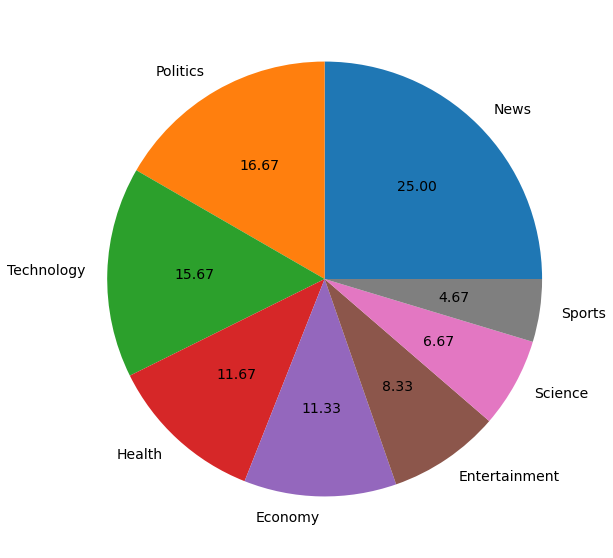

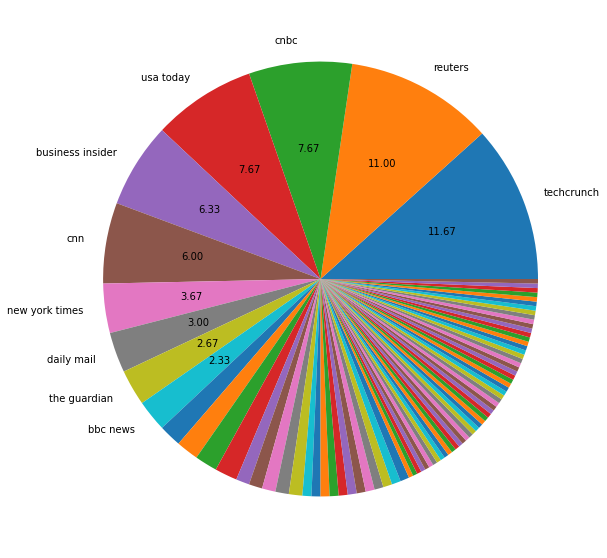

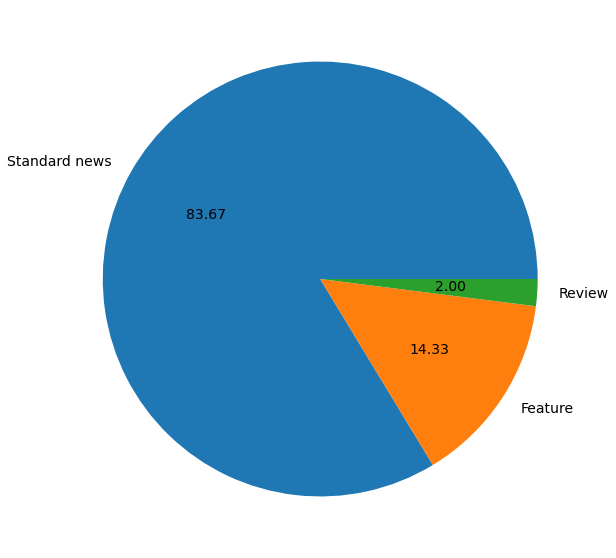

In [ ]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > LIMIT * 100 else ''

fig1, axes1 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig2, axes2 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig3, axes3 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))

topics = data_['Topic'].value_counts(normalize=True).plot.pie(label="", ax=axes1, autopct='%.2f', textprops={'fontsize': 14})
sources = data_['Source'].value_counts(normalize=True)
classification = data_['Classification'].value_counts(normalize=True).plot.pie(label="", ax=axes3, autopct='%.2f', textprops={'fontsize': 14})

labels = [n if v > LIMIT else '' for n, v in sources.iteritems()]                  
axes2.pie(sources, labels=labels, autopct=my_autopct)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_by_topic.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_by_source.svg')

### Modifications


Dataset Size: 300


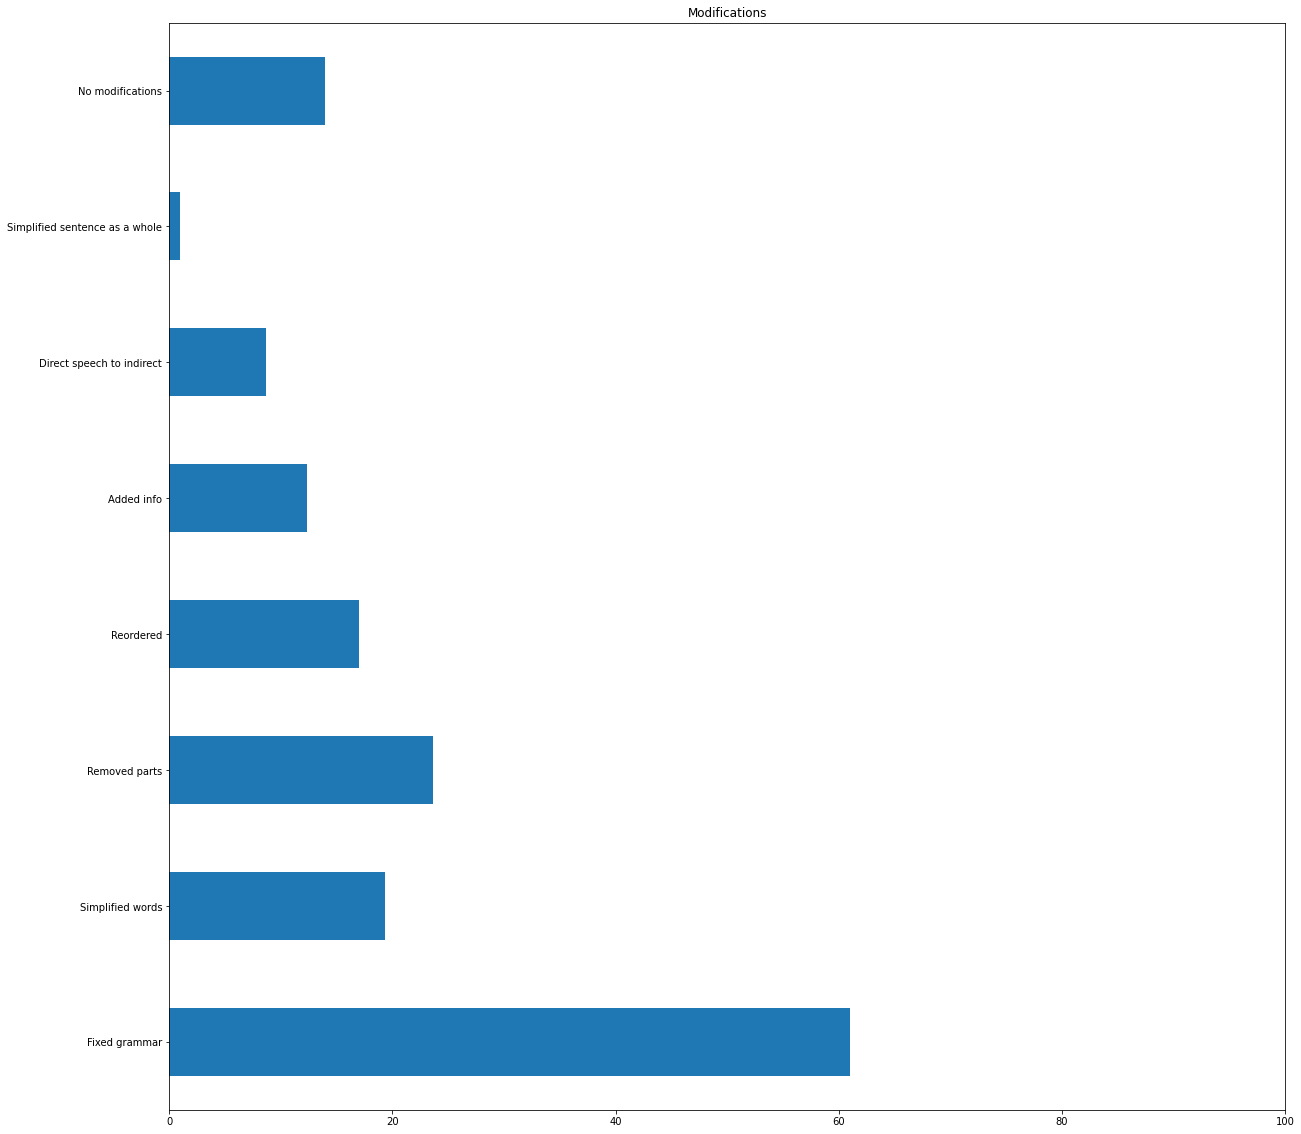

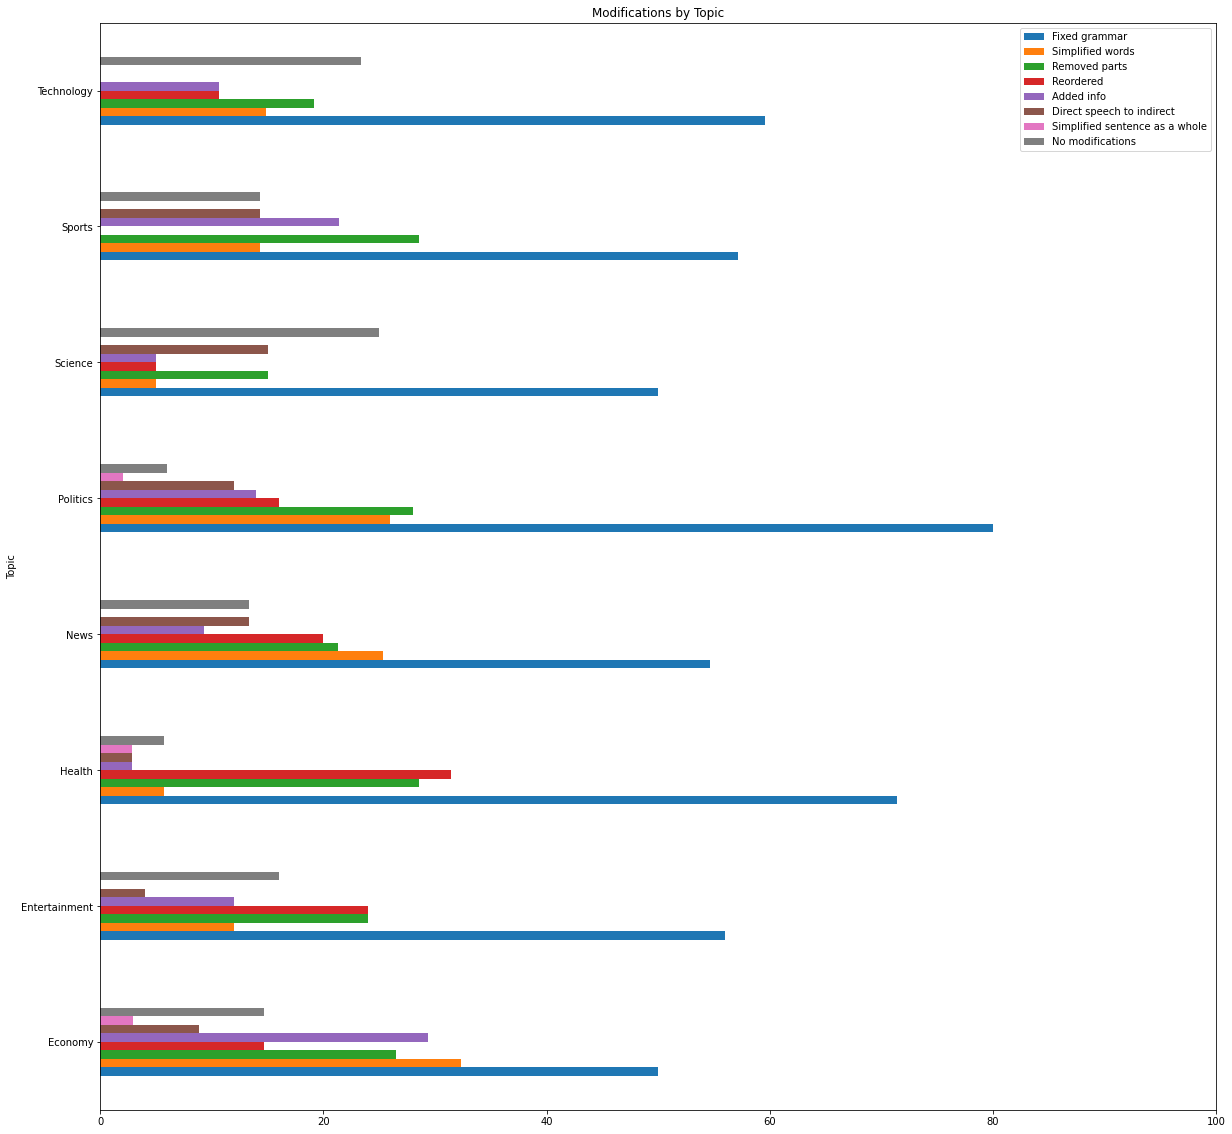

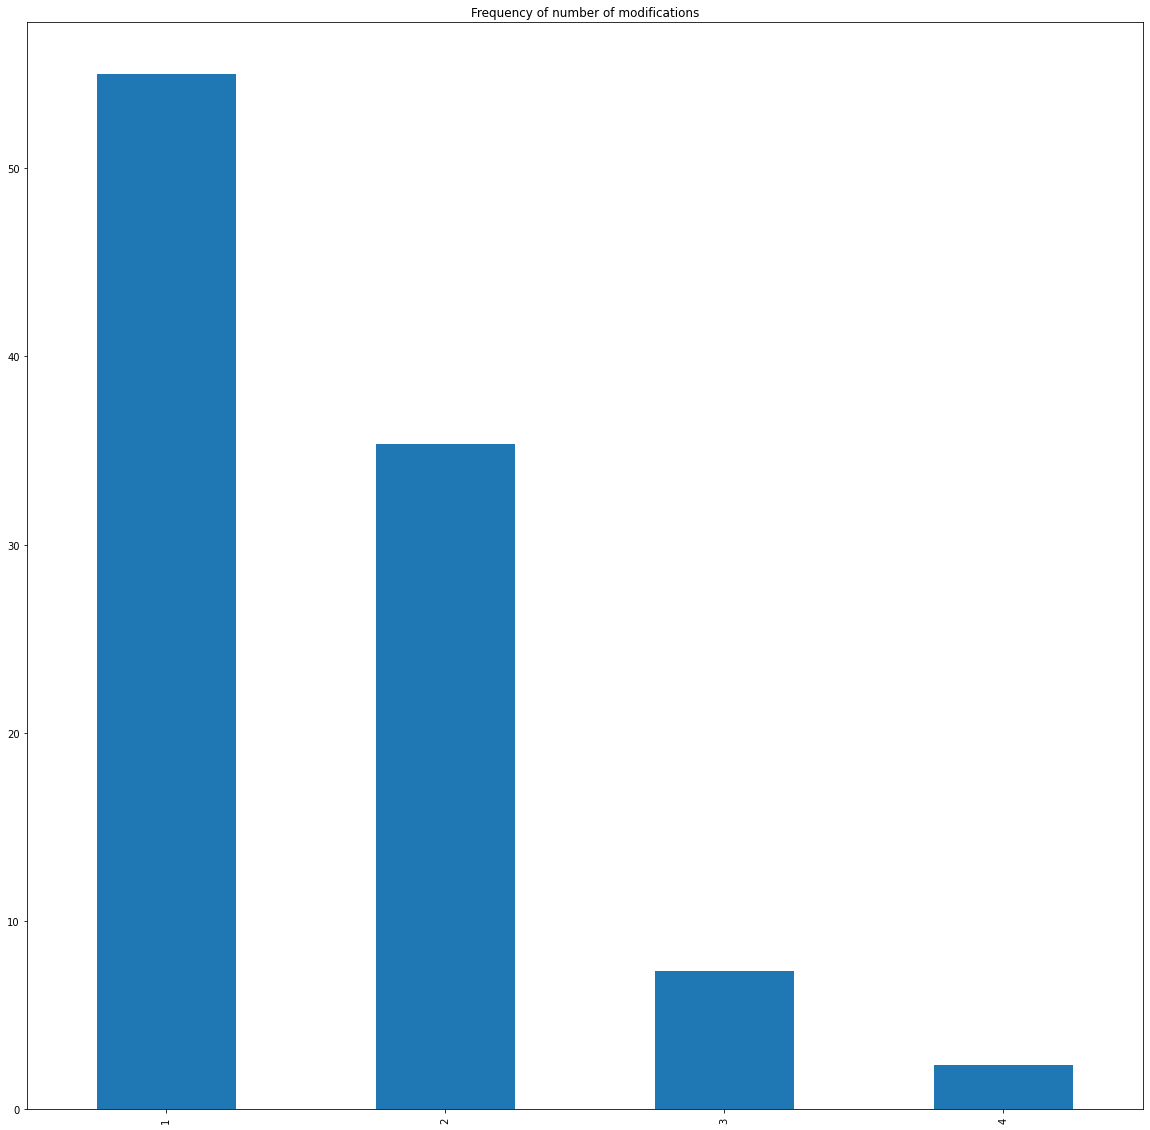

In [ ]:
def mapYesNo(x):
  if x == 'Yes':
    return 1 
  elif x == 'No':
    return 0
  else:
    return x

def noModifications(row):
  b = row['Fixed grammar'] or row['Simplified words'] or row['Removed parts'] or row['Reordered'] or row['Added info'] or row['Direct speech to indirect'] or row ['Simplified sentence as a whole']
  return not b

def percentage(x):
  return x.value_counts(normalize=True) * 100

def percentage_group_by(x):
  c = x.value_counts(normalize=True) * 100
  if len(c.keys()) > 1:
    return c[1]

def count_modifications(row):
  counter = 0
  for v in row:
    if v:
      counter = counter + 1
  return counter


data1 = data.replace(r'^\s*$', np.nan, regex=True)
data1['Source'] = data1['Source'].apply(str.lower)
data1 = data1[data1['Manually Simplified title'].notnull() & data1['Content'].notnull()]
data1['Original title'] = data1['Original title'].apply(clean_title)
data1 = data1[data1['Classification'] != 'Opinion']
data1 = data1[data1['Classification'] != 'Non-Standard news']
full_data = data1.copy(deep=True)
data1 = data1[['Source', 'Topic', 'Fixed grammar', 'Simplified words', 'Removed parts', 'Reordered', 'Added info', 'Direct speech to indirect', 'Simplified sentence as a whole']]
data1 = data1.applymap(mapYesNo)
data1['No modifications'] = data1.apply (lambda row: noModifications(row), axis=1)

# print(data1.columns)

print('Dataset Size: {}'.format(len(data1)))
data2 = data1.iloc[: , 2:]
data3 = data1.iloc[:, 1:]

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))

modifications = data2.apply(percentage).iloc[1]
#print(modifications)
modifications.plot(kind='barh', title = 'Modifications', xlim = (0,100), ax=axes1)

modifications_by_topic = data3.groupby('Topic').apply(lambda x: x.apply(percentage_group_by)).iloc[:, 1:]
#print(modifications_by_topic)
modifications_by_topic.plot(kind='barh', title = 'Modifications by Topic', xlim = (0,100), ax=axes2)

data4 = data1.iloc[:, 2:].apply(count_modifications, axis=1)
(data4.value_counts(sort=False, normalize=True) * 100).plot(kind='bar', title='Frequency of number of modifications', ax=axes3)

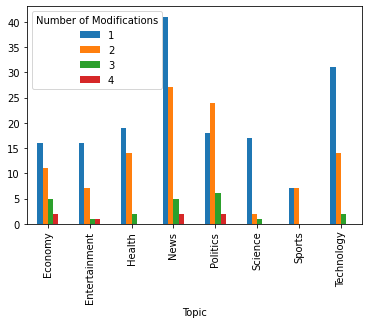

In [ ]:
data5 = pd.DataFrame()
data5['Number of Modifications'] = data4
data5['Topic'] = data1['Topic'] 

data5 = pd.DataFrame({'Count' : data5.groupby( ['Topic', 'Number of Modifications'] ).size()}).reset_index().pivot_table('Count', ['Topic'], 'Number of Modifications').fillna(0)
data5.plot(kind='bar')

## Data preparation for scripts

### Data split

In [ ]:
# X = data_[['ID', 'Original title', 'Content', 'Source', 'Topic']]
X = data_[['ID', 'Original title', 'Content', 'Source', 'Topic', 'Fixed grammar', 'Simplified words', 'Removed parts', 'Reordered', 'Added info', 'Direct speech to indirect', 'Simplified sentence as a whole', 'Classification']]
y = data_[['Manually Simplified title']]

X = X.applymap(mapYesNo)
print(X.head(5))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X[['Topic', 'Classification']])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=X_train[['Topic', 'Classification']])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X[['Topic']])
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=X_train['Topic'])

print('Train: {} | Test: {} | Validation: {}'.format(len(y_train), len(y_test), len(y_valid)))

path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines.'

  ID  ... Classification
0  1  ...  Standard news
1  2  ...  Standard news
2  3  ...  Standard news
4  5  ...        Feature
5  6  ...  Standard news

[5 rows x 13 columns]
Train: 210 | Test: 60 | Validation: 30


### Access

In [ ]:
with open(path+'train.complex', 'w') as tr_c, open(path+'train.simple', 'w') as tr_s, open(path+'test.complex', 'w') as te_c, open(path+'test.simple', 'w') as te_s, open(path+'valid.complex', 'w') as val_c, open(path+'valid.simple', 'w') as val_s:
  for c,s in zip(X_train['Original title'], y_train['Manually Simplified title']):
    tr_s.write(s+"\n")
    tr_c.write(c+"\n")
  for c,s in zip(X_test['Original title'], y_test['Manually Simplified title']):
    te_s.write(s+"\n")
    te_c.write(c+"\n")
  for c,s in zip(X_valid['Original title'], y_valid['Manually Simplified title']):
    val_s.write(s+"\n")
    val_c.write(c+"\n")

with open(path+'full', 'w') as f:
  for t in X['Original title']:
    f.write(t+"\n")

### X-SUM

In [ ]:
with open(path+'train.source', 'w') as tr_c, open(path+'train.target', 'w') as tr_s, open(path+'test.source', 'w') as te_c, open(path+'test.target', 'w') as te_s, open(path+'valid.source', 'w') as val_c, open(path+'valid.target', 'w') as val_s:
  for c,s in zip(X_train['Content'], y_train['Manually Simplified title']):
    tr_s.write(s+"\n")
    tr_c.write(c+"\n")
  for c,s in zip(X_test['Content'], y_test['Manually Simplified title']):
    # print(X_test['Original title'])
    te_s.write(s+"\n")
    te_c.write(c+"\n")
  for c,s in zip(X_valid['Content'], y_valid['Manually Simplified title']):
    val_s.write(s+"\n")
    val_c.write(c+"\n")

with open(path+'.articles.full', 'w') as f:
  for t in X['Content']:
    f.write(t+"\n")

# Pretrained models Evaluation

## Access

### Read data

In [ ]:
import pandas as pd 

data_access = pd.DataFrame()

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_full_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    print(len(l))
    data_access[name.format(i)] = l

data_access.index = data_.index
data_access['ID'] = data_['ID'].copy()
data_access['Original title'] = data_['Original title']
data_access['Source'] = data_['Source']
data_access['Topic'] = data_['Topic']
data_access['Manually Simplified title'] = data_['Manually Simplified title']
data_access['Classification'] = data_['Classification']

# This line limits the dataset to the test dataset used in the transfer learning phase
data_access = data_access[data_access['ID'].isin(X_test['ID'])]

s1 = set(data_access['ID'])
s2 = set(X_test['ID'])

print(data_access.head(5))

"{} | {} | {}".format(len(data_access), len(s1), len(s2))

300
300
300
300
300
                                      Configuration 1  ... Classification
0   Gunfire in DMZ across border between North Kor...  ...  Standard news
14  Trump campaign divided over how to attack Bide...  ...  Standard news
15  We Had to Do Something : Trying to Prevent Mas...  ...        Feature
22  A 'travel bubble between New Zealand and Austr...  ...        Feature
29  Coronavirus vaccine may never come in , becaus...  ...  Standard news

[5 rows x 11 columns]


'60 | 60 | 60'

Dataset Size: 60


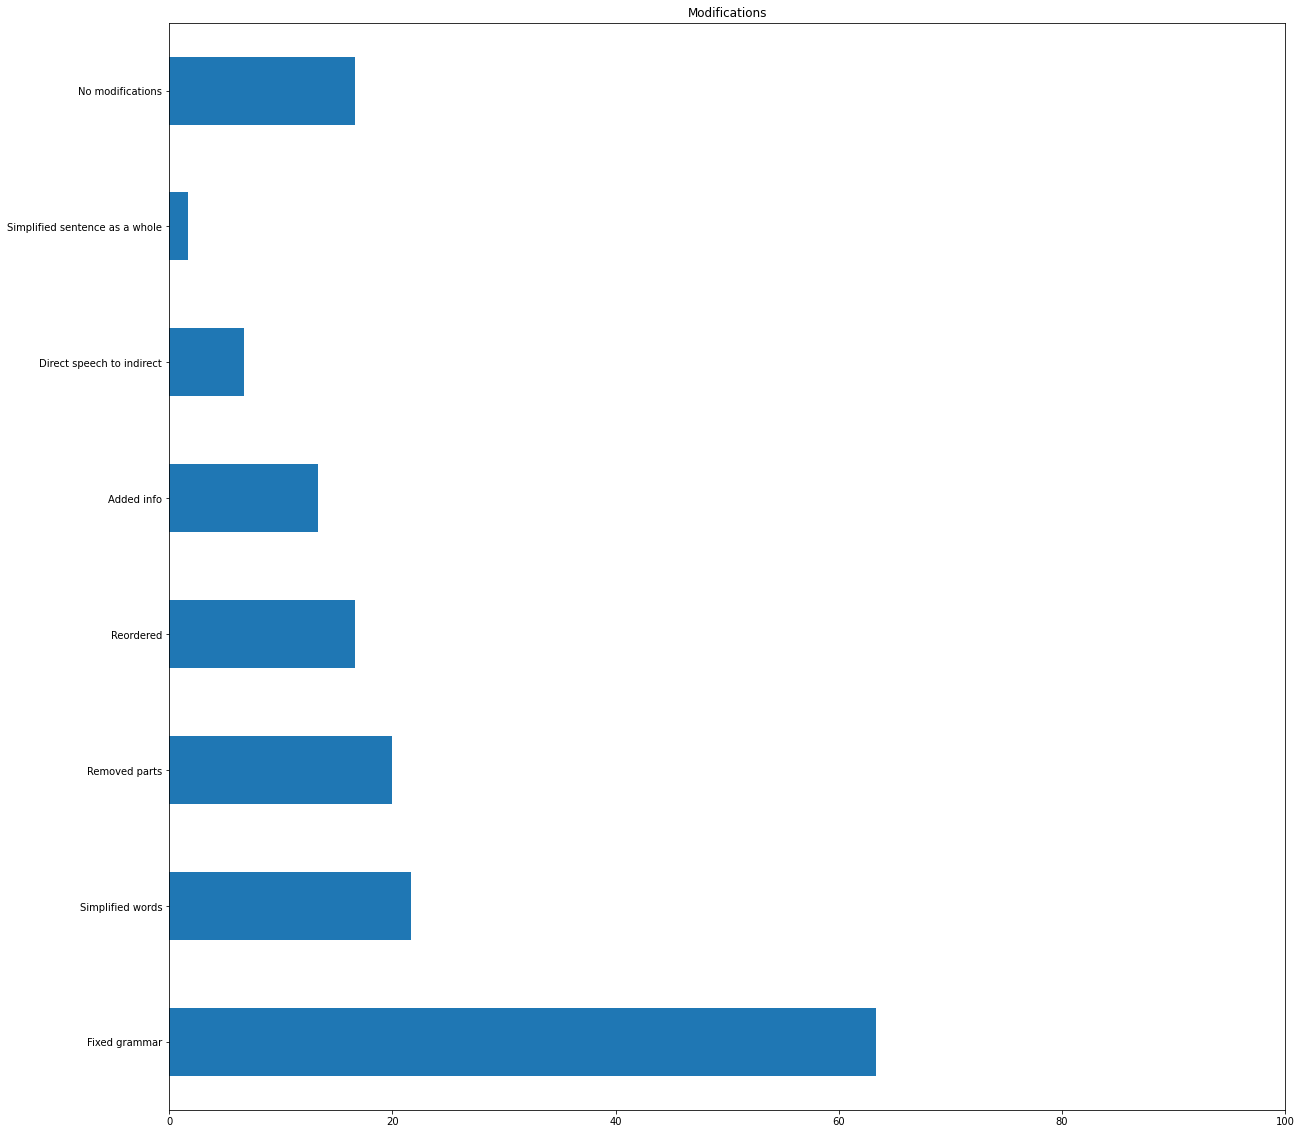

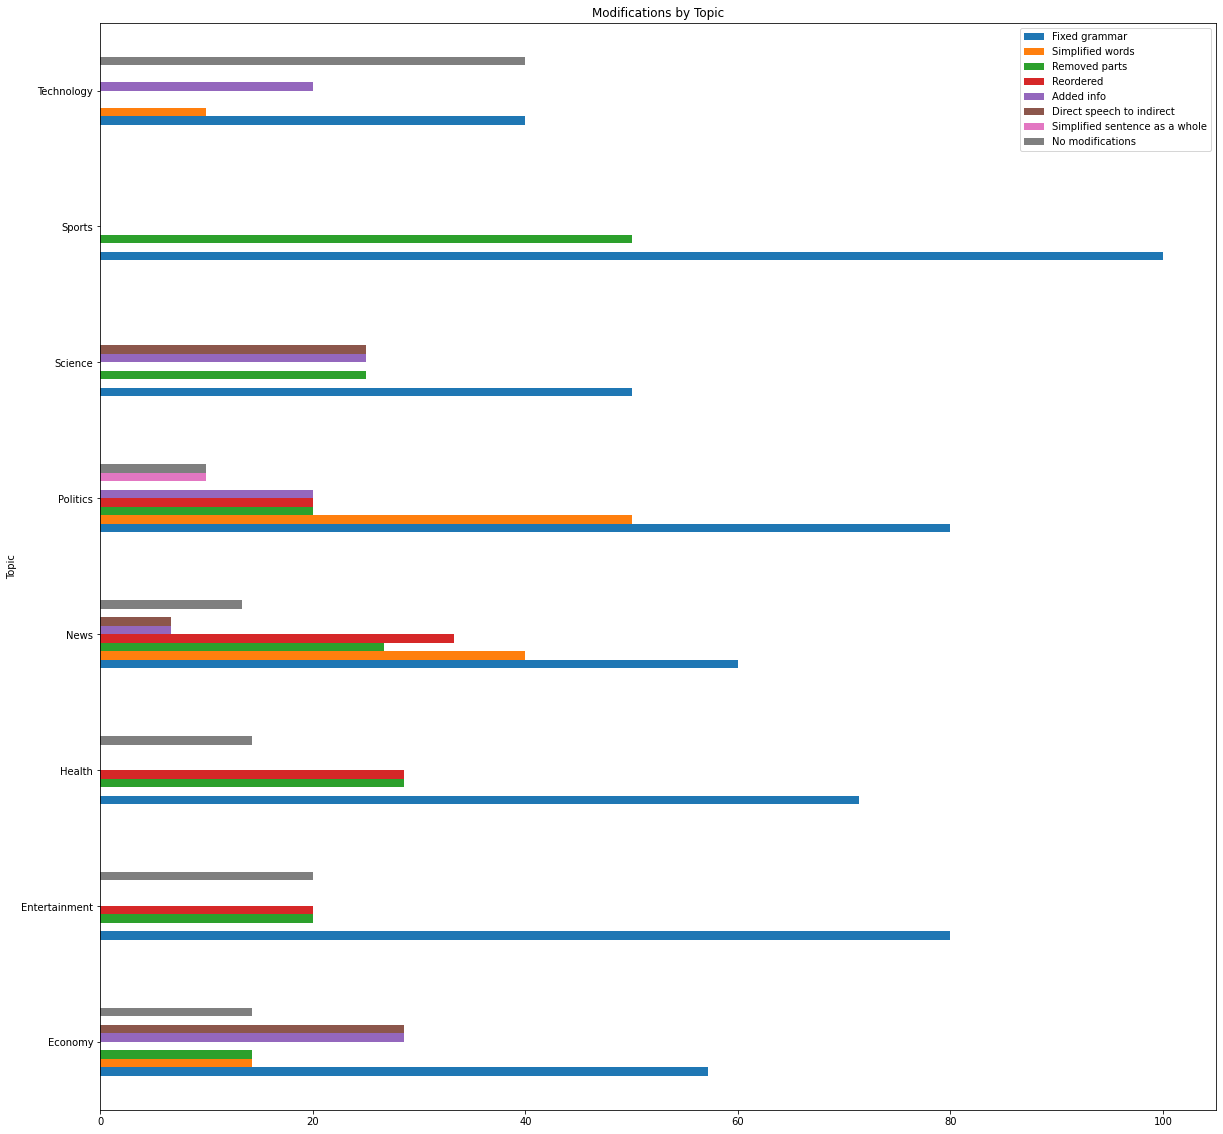

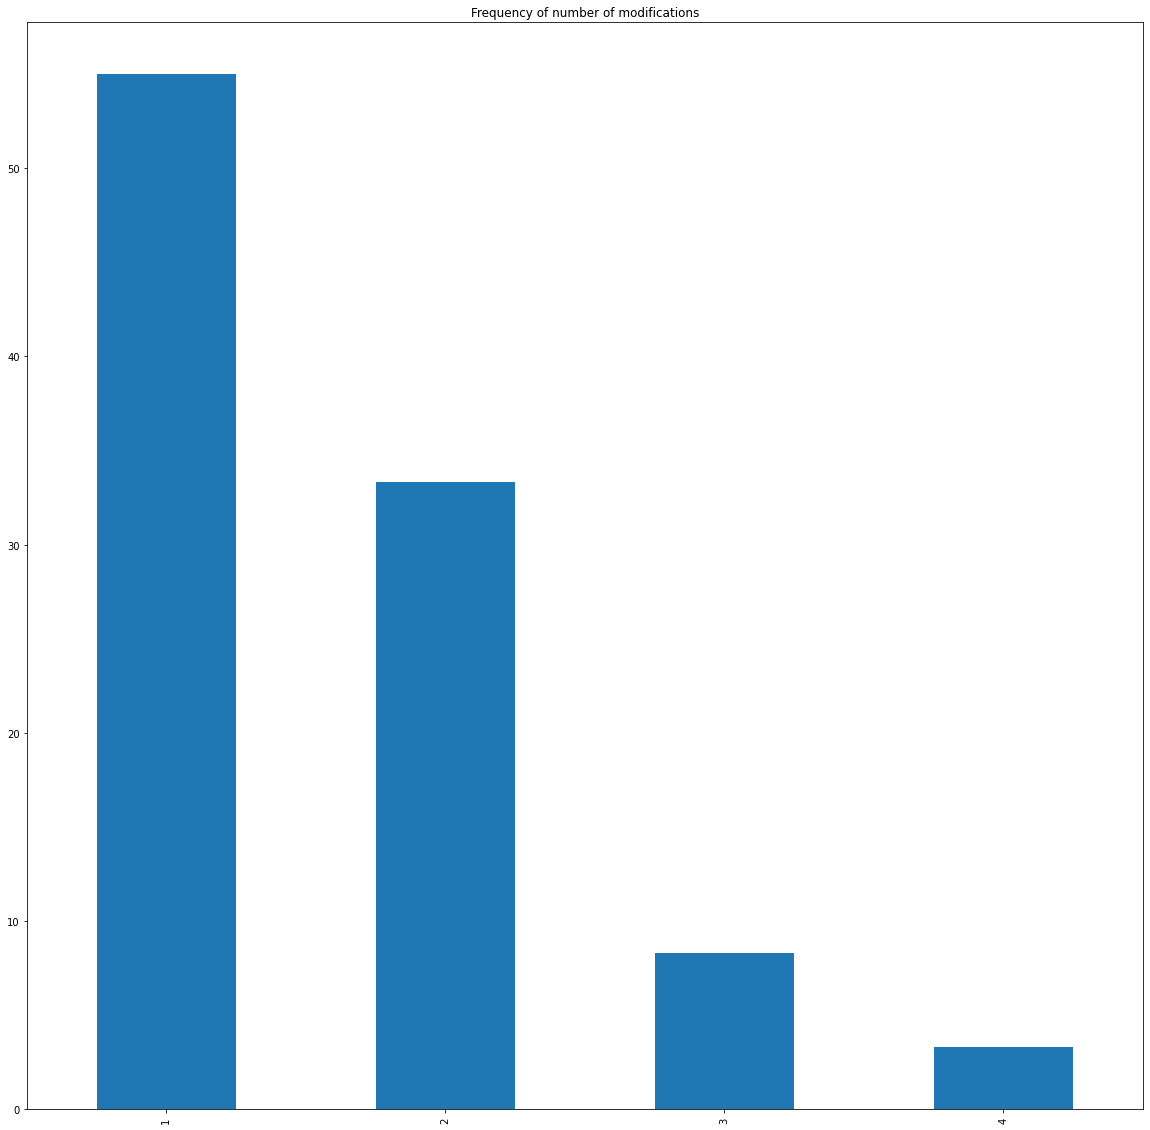

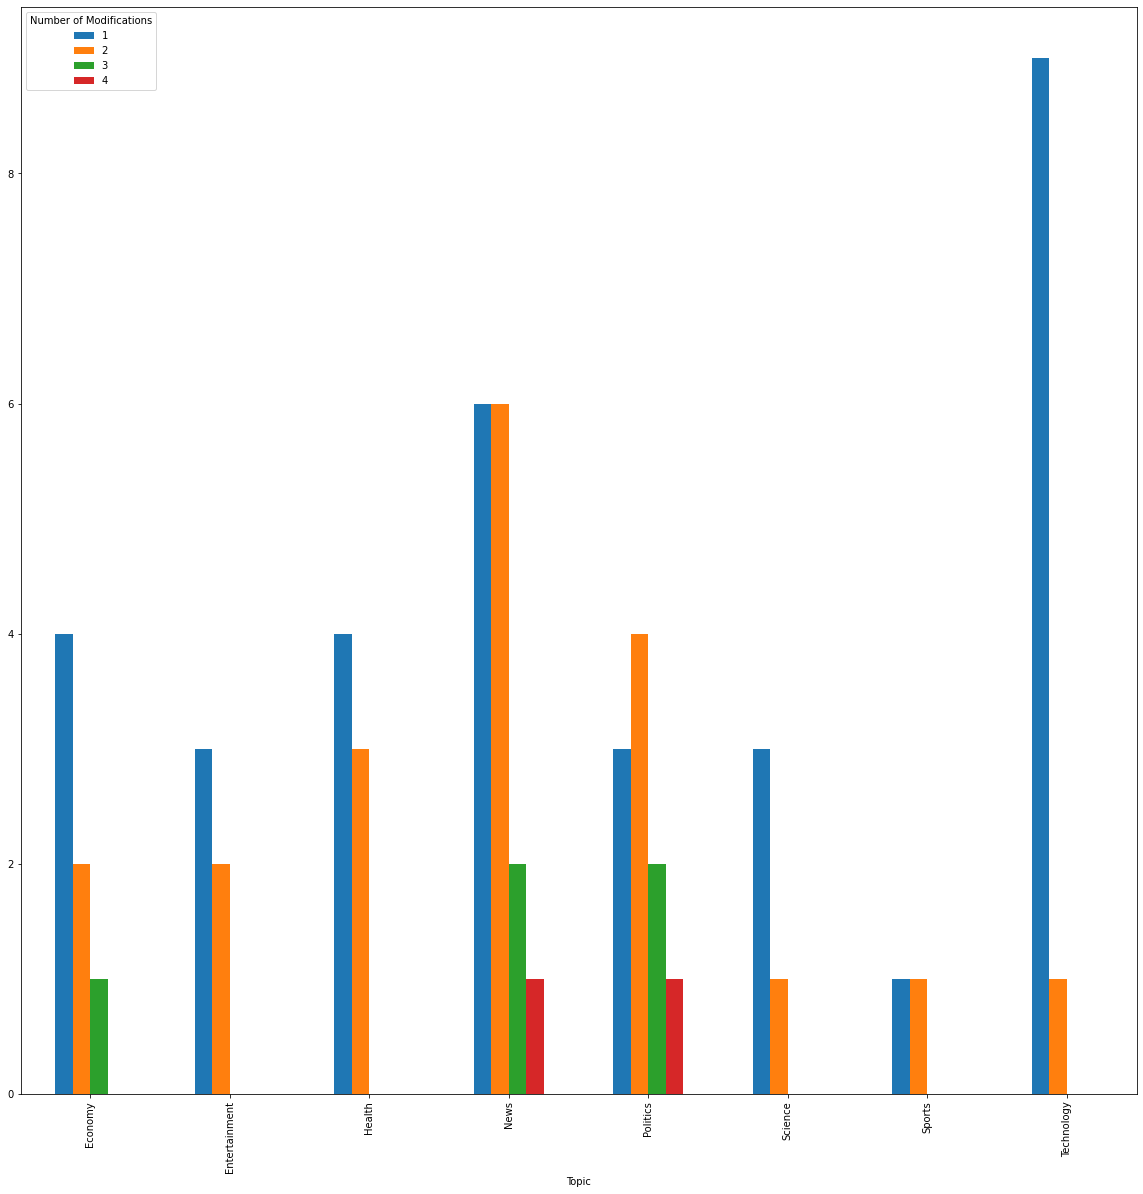

In [ ]:
data1 = full_data[full_data['ID'].isin(X_test['ID'])]
data1 = data1[['Source', 'Topic', 'Fixed grammar', 'Simplified words', 'Removed parts', 'Reordered', 'Added info', 'Direct speech to indirect', 'Simplified sentence as a whole']]
data1 = data1.applymap(mapYesNo)
data1['No modifications'] = data1.apply (lambda row: noModifications(row), axis=1)

# print(data1.columns)

print('Dataset Size: {}'.format(len(data1)))
data2 = data1.iloc[: , 2:]
data3 = data1.iloc[:, 1:]

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))

modifications = data2.apply(percentage).iloc[1]
#print(modifications)
modifications.plot(kind='barh', title = 'Modifications', xlim = (0,100), ax=axes1)

data3.iloc[:, 1:] = data3.iloc[:, 1:].applymap(lambda x: 1 if x else 0)

modifications_by_topic = data3.groupby('Topic').sum() / data3.groupby('Topic').count() * 100
#print(modifications_by_topic)
modifications_by_topic.plot(kind='barh', title = 'Modifications by Topic', ax=axes2)

data4 = data1.iloc[:, 2:].apply(count_modifications, axis=1)
(data4.value_counts(sort=False, normalize=True) * 100).plot(kind='bar', title='Frequency of number of modifications', ax=axes3)
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/modifications_by_topic_.svg')

data5 = pd.DataFrame()
data5['Number of Modifications'] = data4
data5['Topic'] = data1['Topic'] 

data5 = pd.DataFrame({'Count' : data5.groupby( ['Topic', 'Number of Modifications'] ).size()}).reset_index().pivot_table('Count', ['Topic'], 'Number of Modifications').fillna(0)
data5.plot(kind='bar', ax=axes4)

fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/number_modifications_by_topic.svg')

### Compute Scores


In [ ]:
import textstat

def compute_scores(column):
  return [textstat.text_standard(s, float_output=True) for s in column]

scores = pd.DataFrame(data=data_access.apply(compute_scores, axis=0), columns=data_access.columns)
scores['Source'] = data_access['Source']
scores['Topic'] = data_access['Topic']
scores['Classification'] = data_access['Classification']

# scores_test = pd.DataFrame(data=data_access_test.apply(compute_scores, axis=0), columns=data_access.columns)
# scores_test['Source'] = data_access_test['Source']
# scores_test['Topic'] = data_access_test['Topic']

print(len(scores))
scores.head(1)

60


,Configuration 1,Configuration 2,Configuration 3,Configuration 4,Configuration 5,ID,Original title,Source,Topic,Manually Simplified title,Classification
0,8.0,8.0,8.0,8.0,10.0,0.0,9.0,cnn,News,10.0,Standard news


### Analytics

#### Orginal title metrics

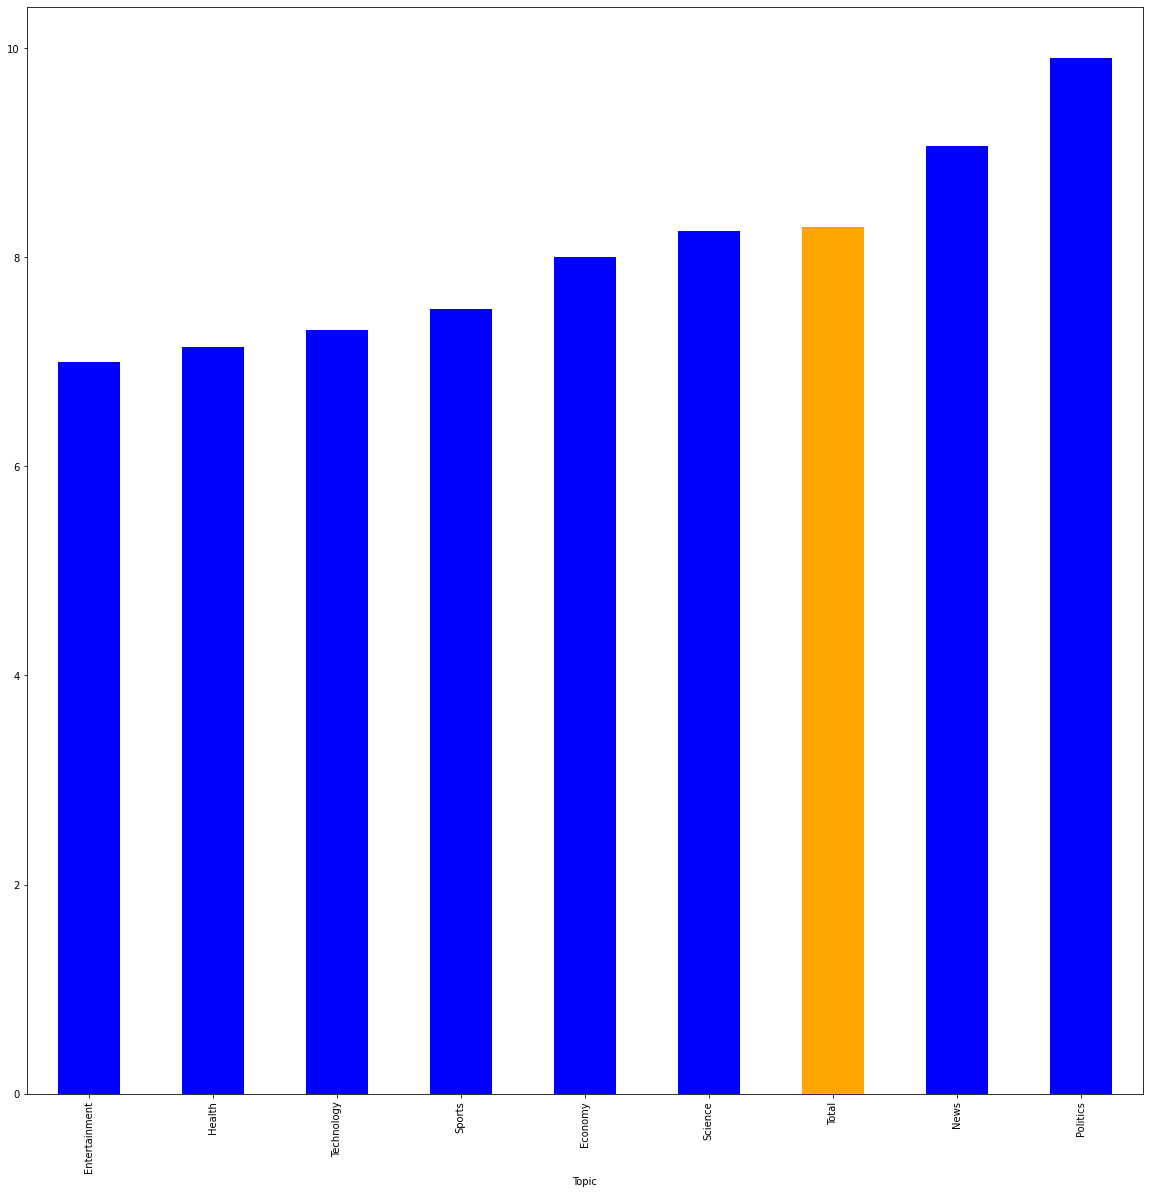

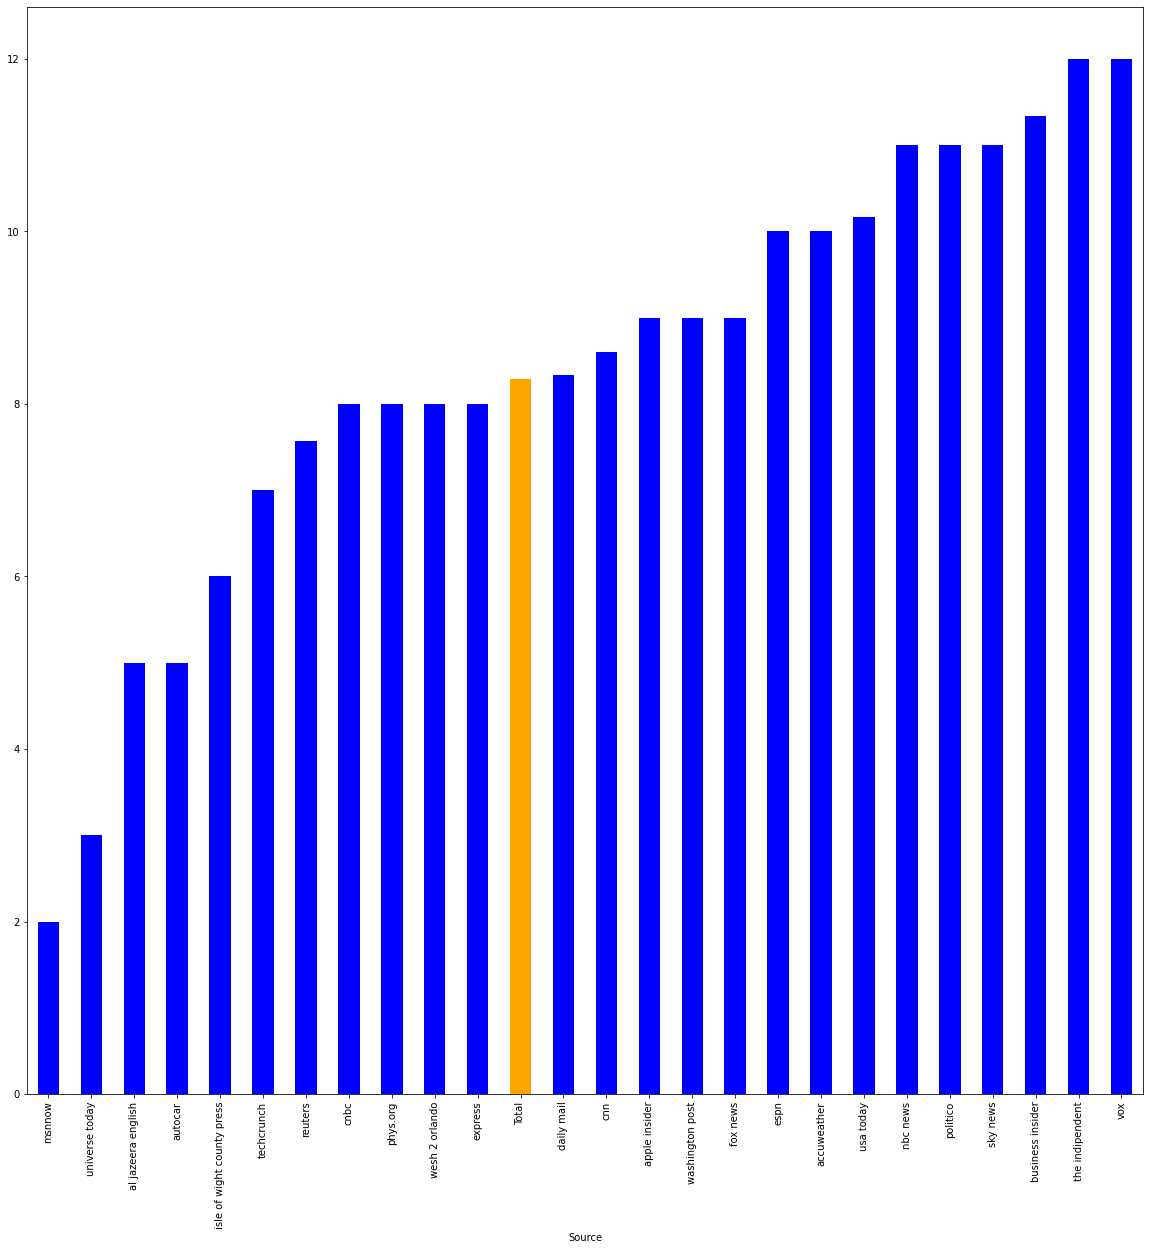

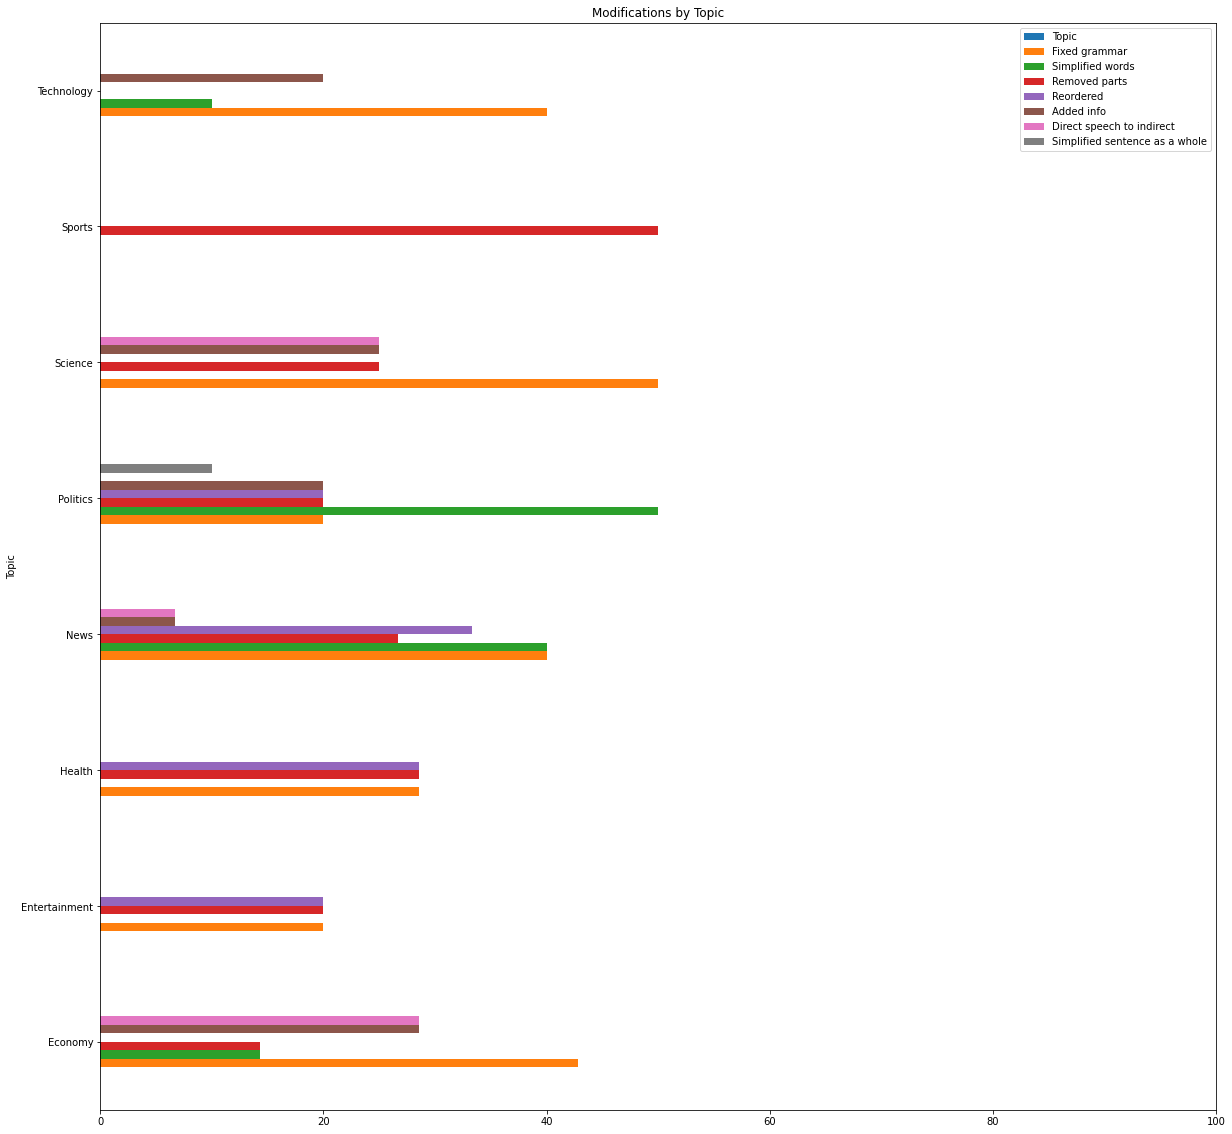

In [ ]:
# Global average of the original titles
avg = scores['Original title'].mean()

# Average by topic
avg_by_topic = scores.groupby('Topic')['Original title'].mean()
avg_by_topic['Total'] = avg
avg_by_topic = avg_by_topic.sort_values()
c1 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_topic.index]

# Average by source
avg_by_source = scores.groupby('Source')['Original title'].mean()
avg_by_source['Total'] = avg
avg_by_source = avg_by_source.sort_values()
c2 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_source.index]

#Plot
fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20,20))

avg_by_topic.plot(kind='bar', color=c1, ax=axes1)
avg_by_source.plot(kind='bar', color=c2, ax=axes2)

full_data = full_data[full_data['ID'].isin(X_test['ID'])]
full_data = full_data[['Source', 'Topic', 'Fixed grammar', 'Simplified words', 'Removed parts', 'Reordered', 'Added info', 'Direct speech to indirect', 'Simplified sentence as a whole']]
modifications_by_topic_2 = full_data.groupby('Topic').apply(lambda x: x.apply(percentage_group_by)).iloc[:, 1:]
modifications_by_topic_2.plot(kind='barh', title = 'Modifications by Topic', xlim = (0,100), ax=axes3)

fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/modifications_by_topic.svg')

#### Manually simplified metrics

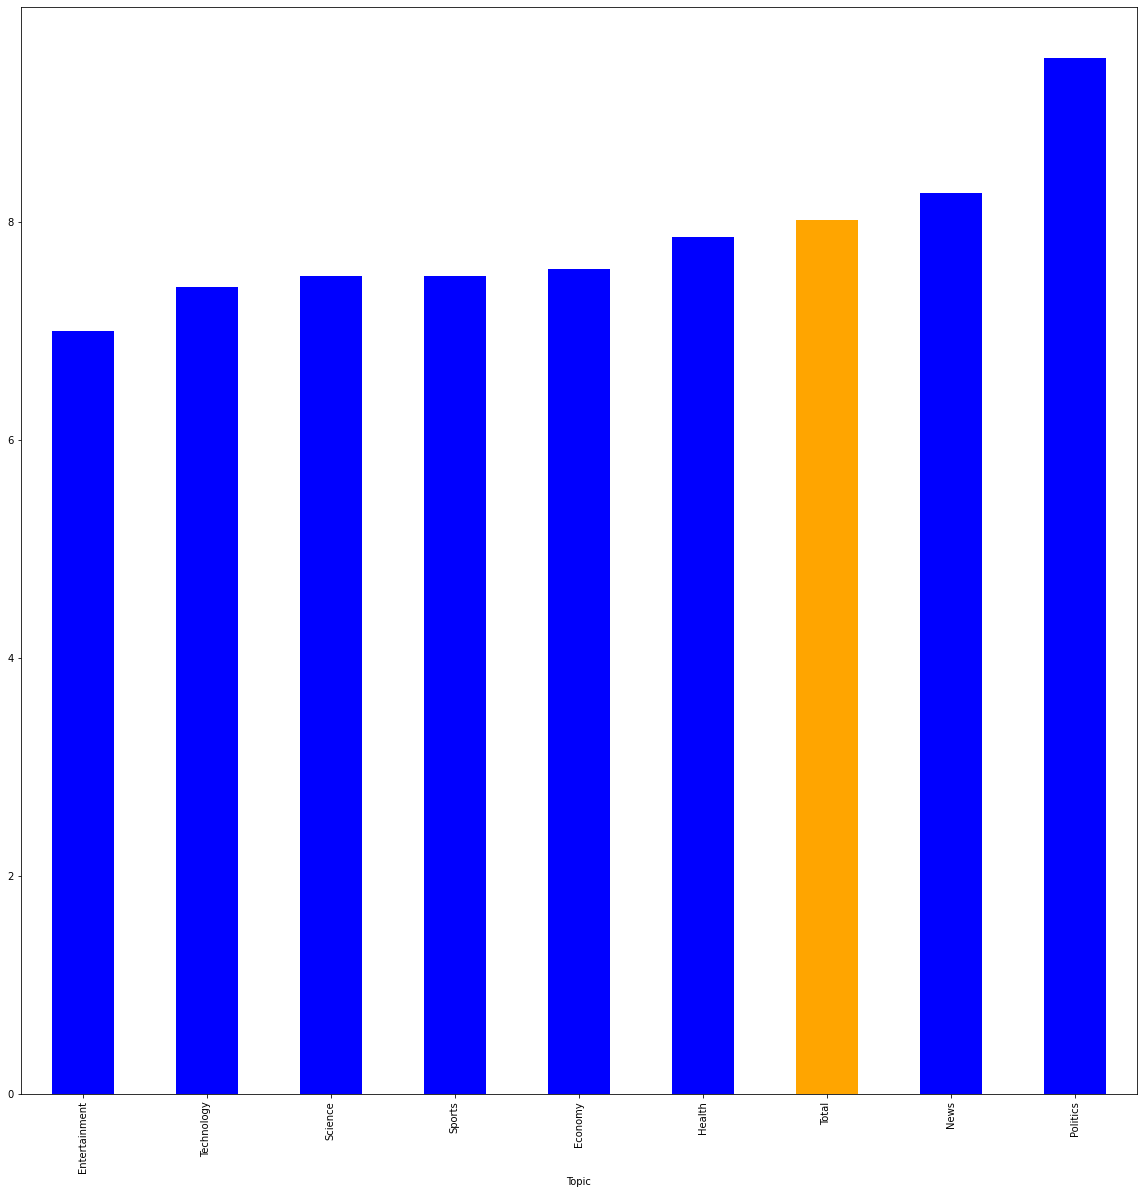

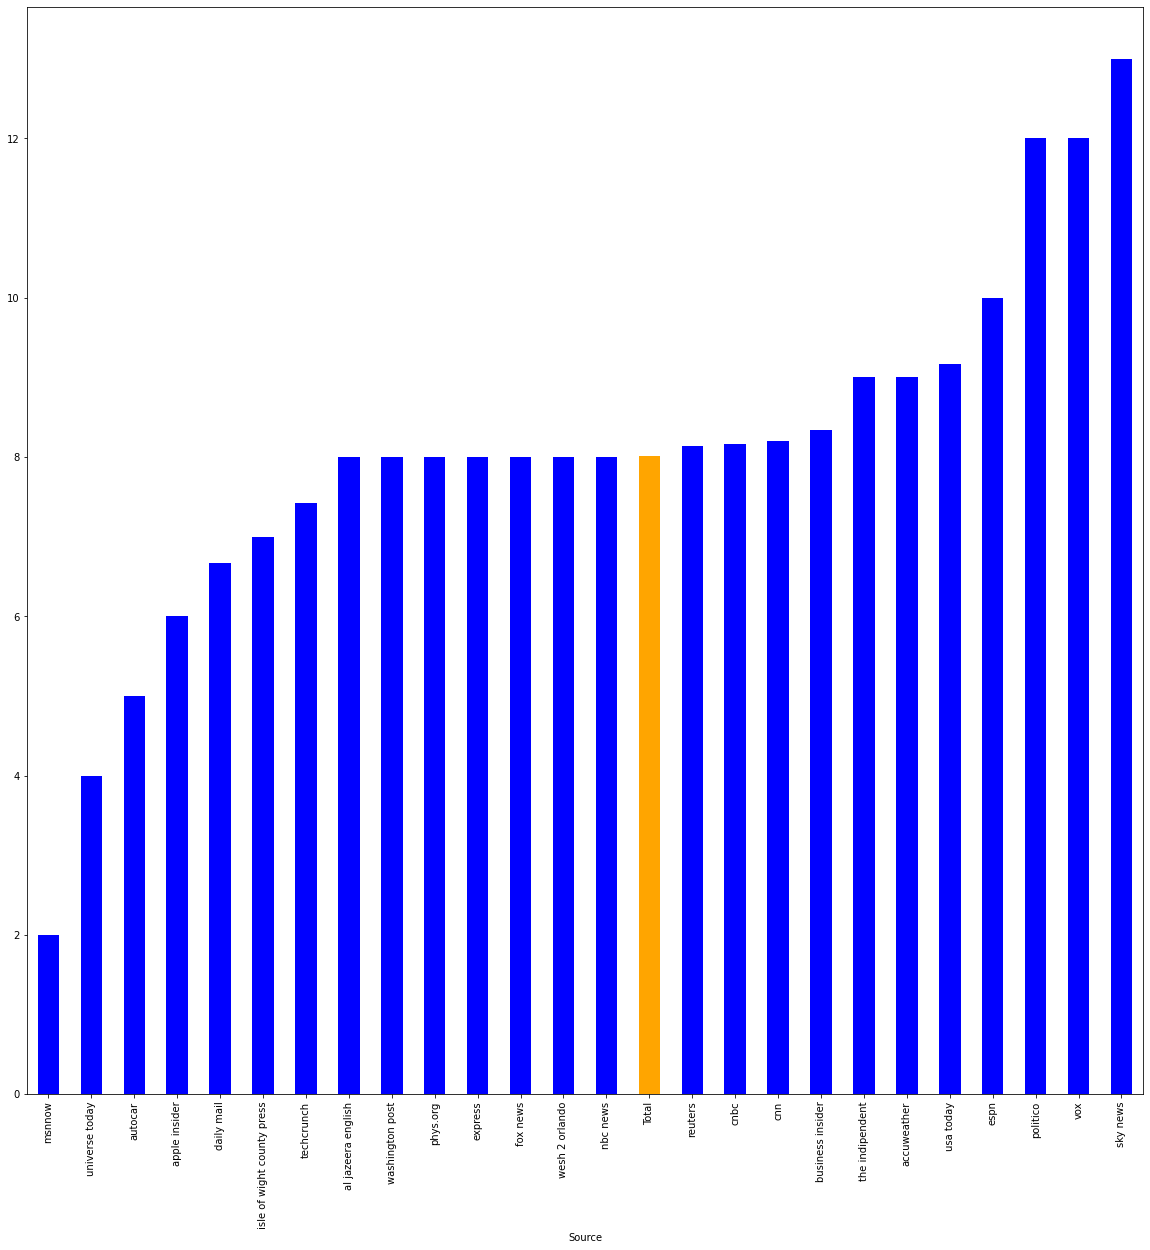

In [ ]:
# Global average of the manually simplified titles
avg = scores['Manually Simplified title'].mean()

# Average by topic
avg_by_topic = scores.groupby('Topic')['Manually Simplified title'].mean()
avg_by_topic['Total'] = avg
avg_by_topic = avg_by_topic.sort_values()
c1 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_topic.index]

# Average by source
avg_by_source = scores.groupby('Source')['Manually Simplified title'].mean()
avg_by_source['Total'] = avg
avg_by_source = avg_by_source.sort_values()
c2 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_source.index]

#Plot
fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))

avg_by_topic.plot(kind='bar', color=c1, ax=axes1)
avg_by_source.plot(kind='bar', color=c2, ax=axes2)

#### Access configurations metrics

60


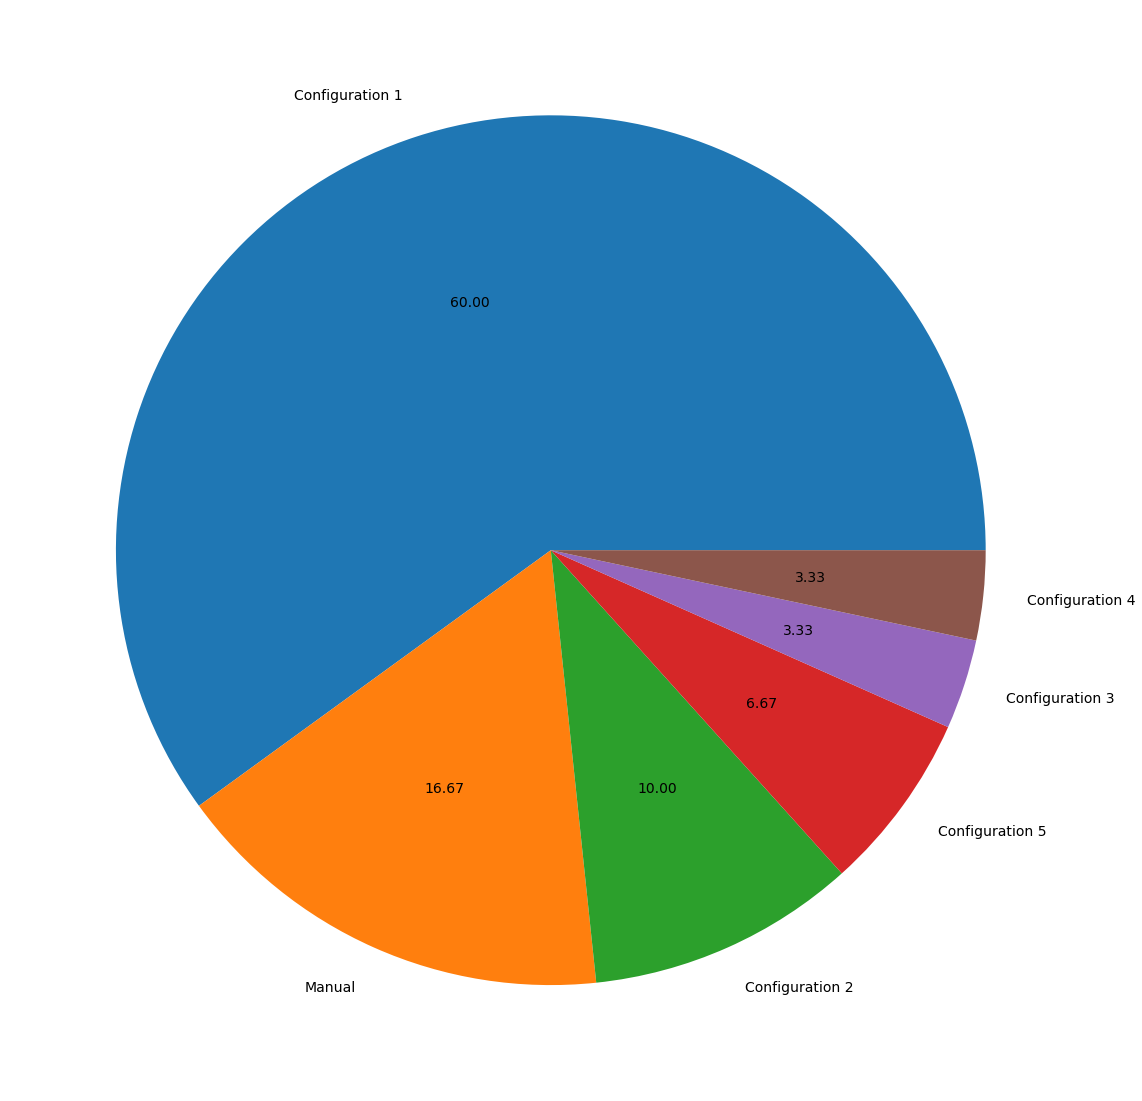

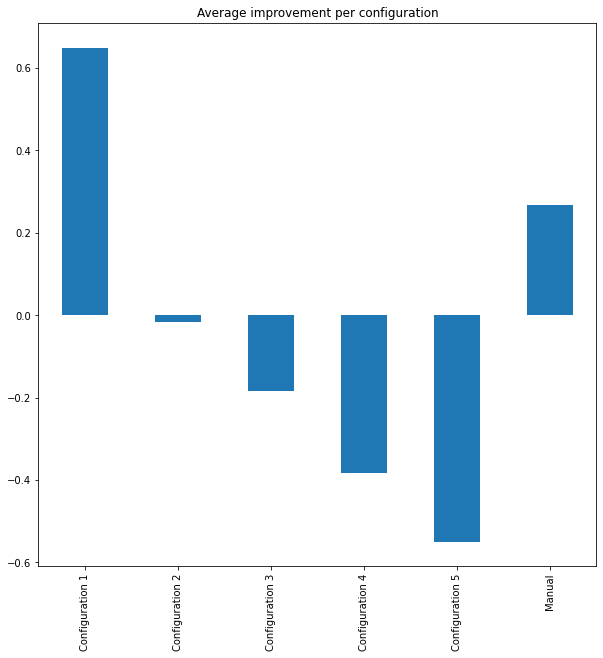

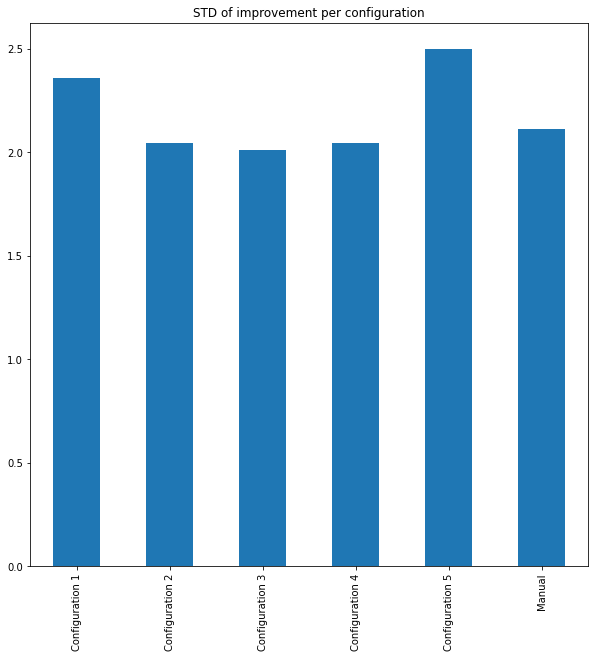

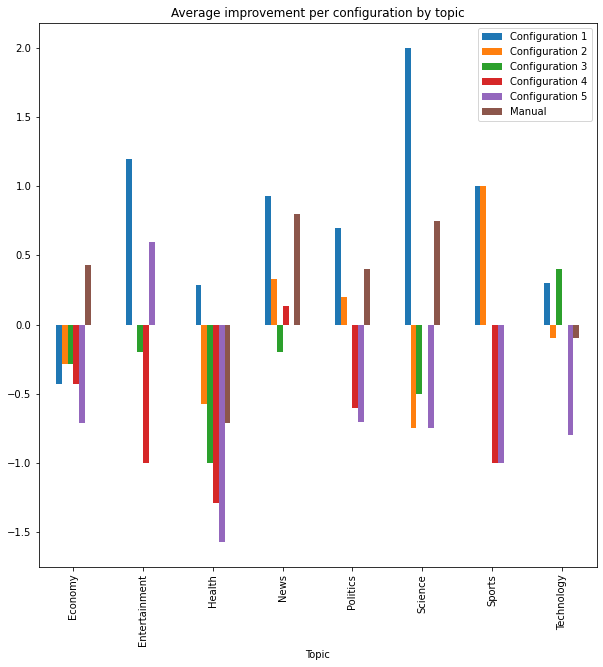

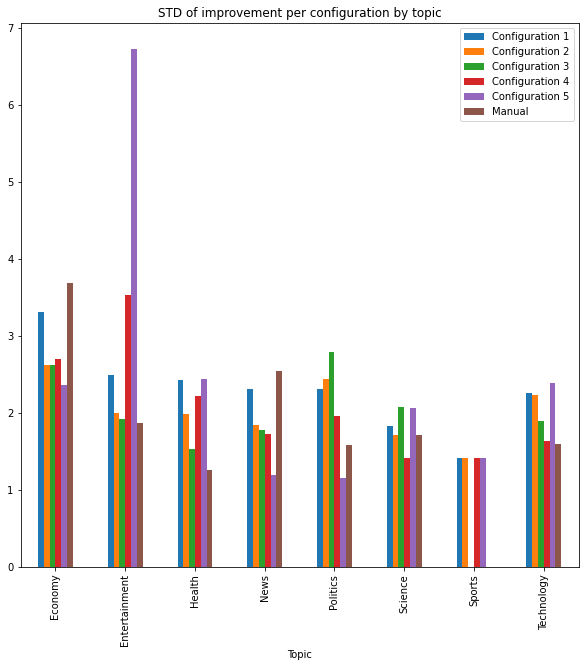

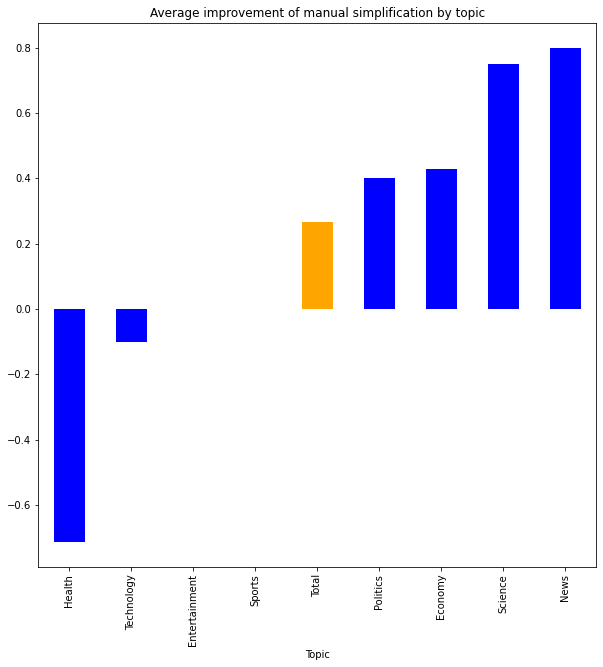

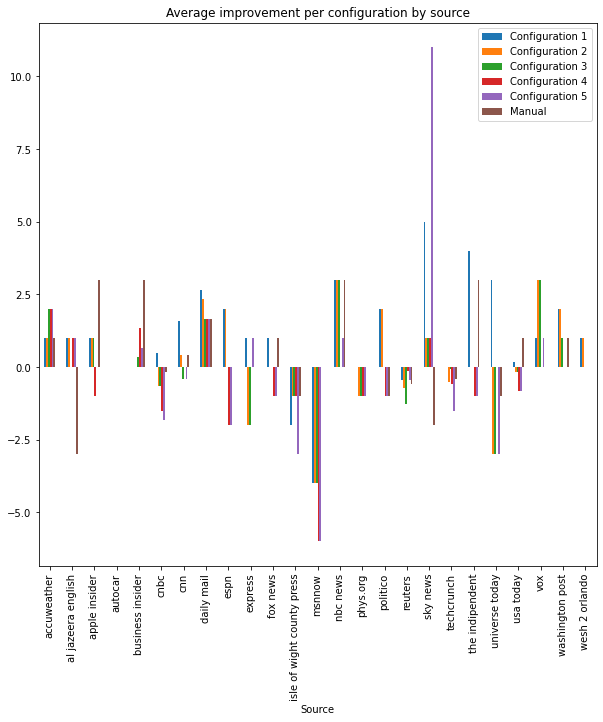

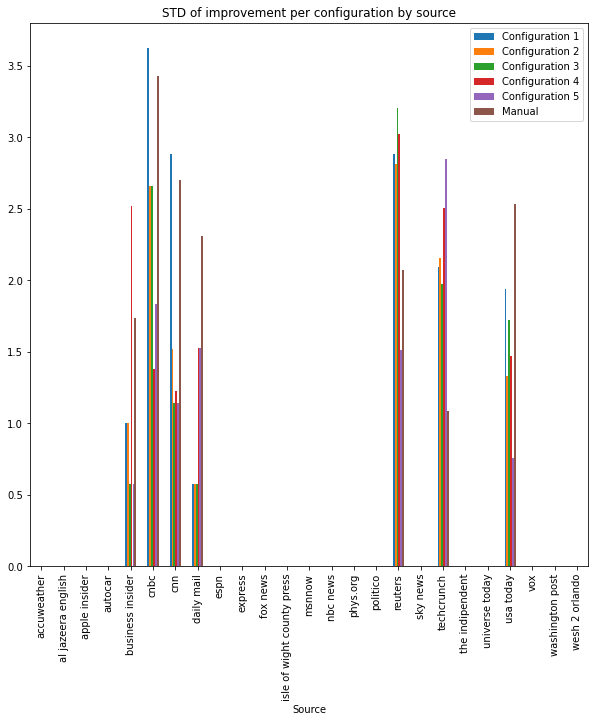

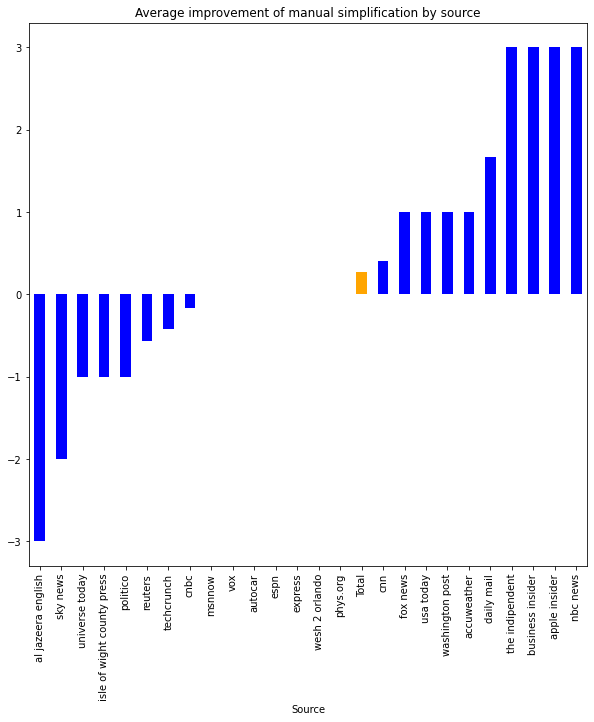

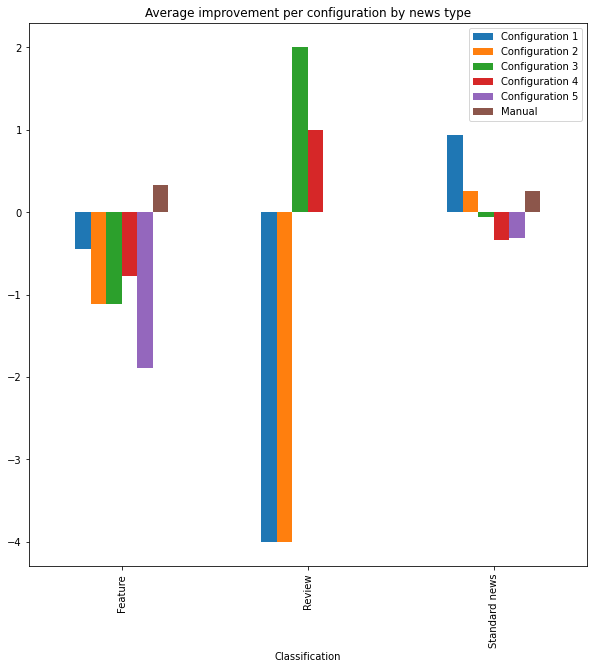

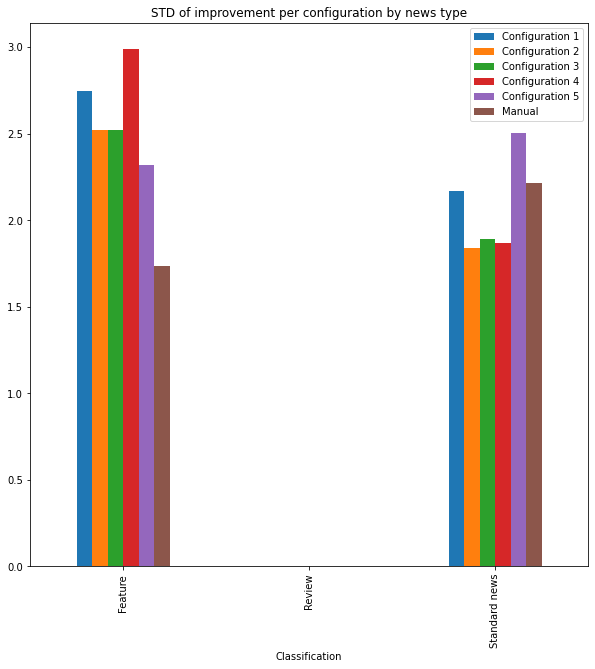

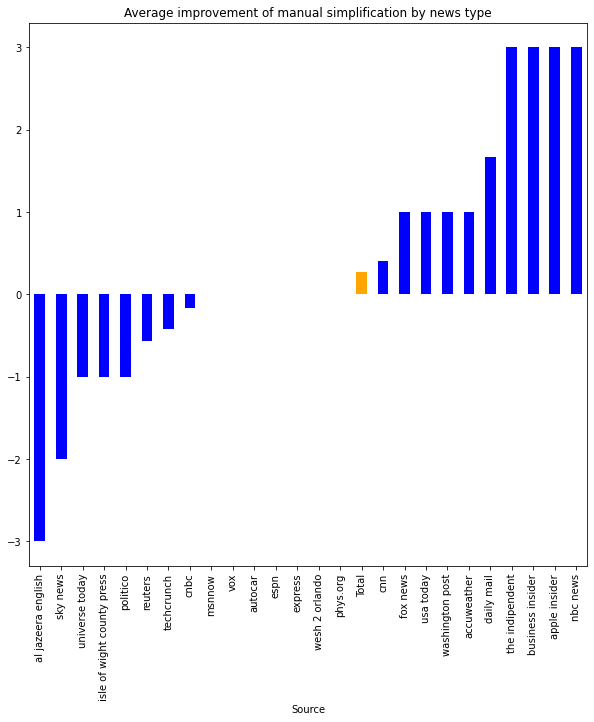

In [ ]:
# Compute improvements
scores2 = pd.DataFrame()
scores2['Configuration 1'] = scores['Original title'] - scores['Configuration 1']
scores2['Configuration 2'] = scores['Original title'] - scores['Configuration 2']
scores2['Configuration 3'] = scores['Original title'] - scores['Configuration 3']
scores2['Configuration 4'] = scores['Original title'] - scores['Configuration 4']
scores2['Configuration 5'] = scores['Original title'] - scores['Configuration 5']
scores2['Manual'] = scores['Original title'] - scores['Manually Simplified title']
bi = scores2.max(axis=1)

scores3 = scores2.mean(axis=0)
scores4 = scores2.std(axis=0)

fig5, axes5 = plt.subplots(figsize=(20, 20))
scores2.idxmax(axis=1).value_counts(normalize=True).plot.pie(label="", ax=axes5, autopct='%.2f', textprops={'fontsize': 14})

scores10 = scores2.copy()
scores20 = scores2.copy()

scores2['Topic'] = scores['Topic']
scores5 = scores2.groupby('Topic')
scores6 = scores5.mean()
scores7 = scores5.std()

#Manual simplification improvements
avg = scores2['Manual'].mean()
avg_by_topic = scores5['Manual'].mean()
avg_by_topic['Total'] = avg
avg_by_topic = avg_by_topic.sort_values()
c1 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_topic.index]

print(len(scores2))

#improvements by source
scores10['Source'] = scores['Source']
scores11 = scores10.groupby('Source')
scores12 = scores11.mean()
scores13 = scores11.std()

avg_by_source = scores11['Manual'].mean()
avg_by_source['Total'] = avg
avg_by_source = avg_by_source.sort_values()
c2 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_source.index]

#improvements by classification
scores20['Classification'] = scores['Classification']
scores21 = scores20.groupby('Classification')
scores22 = scores21.mean()
scores23 = scores21.std()

avg_by_classification = scores11['Manual'].mean()
avg_by_classification['Total'] = avg
avg_by_classification = avg_by_classification.sort_values()
c3 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_classification.index]

fig1, axes1 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig2, axes2 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig3, axes3 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig4, axes4 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig6, axes6 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))

# BY SOURCE
fig7, axes7 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig8, axes8 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig9, axes9 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))

# BY CLASSIFICATION
fig10, axes10 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig11, axes11 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig12, axes12 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))


scores3.plot(kind='bar', title='Average improvement per configuration', ax=axes1)
scores4.plot(kind='bar', title='STD of improvement per configuration', ax=axes2)
scores6.plot(kind='bar', title='Average improvement per configuration by topic', ax=axes3)
scores7.plot(kind='bar', title='STD of improvement per configuration by topic', ax=axes4)
avg_by_topic.plot(kind='bar', title='Average improvement of manual simplification by topic', color=c1, ax=axes6)

scores12.plot(kind='bar', title='Average improvement per configuration by source', ax=axes7)
scores13.plot(kind='bar', title='STD of improvement per configuration by source', ax=axes8)
avg_by_source.plot(kind='bar', title='Average improvement of manual simplification by source', color=c2, ax=axes9)

scores22.plot(kind='bar', title='Average improvement per configuration by news type', ax=axes10)
scores23.plot(kind='bar', title='STD of improvement per configuration by news type', ax=axes11)
avg_by_classification.plot(kind='bar', title='Average improvement of manual simplification by news type', color=c2, ax=axes12)


fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_deviation_configuration.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_topic.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_deviation_configuration_by_topic.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_manual_by_topic.svg')
fig7.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_source.svg')
fig8.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_deviation_configuration_by_source.svg')
fig9.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_manual_by_source.svg')
fig10.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_classification.svg')
fig11.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_deviation_configuration_by_classification.svg')
fig12.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_manual_by_classification.svg')

#### Access configuration metrics on test set

### BLEU Score


In [ ]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from easse.bleu import sentence_bleu
import pandas as pd

DATA_PATH = "/content/drive/My Drive/Universita/Tesi/Data/headlines_data/"
ORIG_FILE = DATA_PATH+ "headlines.test.complex"
REF_FILE = DATA_PATH+ "headlines.test.simple"
SYS_FILE = DATA_PATH+ "headlines_test_pretrained_config_{}.txt"

data = pd.DataFrame()
data['Source'] = X_test['Source']
data['Topic'] = X_test['Topic']
for i in range(1,6,1):
  column = []
  column_name = 'Configuration {}'.format(i)
  f = SYS_FILE.format(i)
  with open(ORIG_FILE, 'r') as o_file, open(REF_FILE, 'r') as r_file, open(f, 'r') as s_file:
    for o,r,s in zip(o_file, r_file, s_file):
      # print('{} | {} | {}'.format(o,r,s))
      bleu = sentence_bleu(sys_sent=s,  ref_sents=[r])
      quality = corpus_quality_estimation(orig_sentences=[o],  sys_sentences=[s])
      column.append(bleu)
  data[column_name] = column
  
print(data.head(2))

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))
fig5, axes5 = plt.subplots(figsize=(20, 20))
fig6, axes6 = plt.subplots(figsize=(20, 20))

data.mean(axis=0).plot(kind='bar', title='Average bleu per configuration', ax=axes1)
data.std(axis=0).plot(kind='bar', title='STD of bleu per configuration', ax=axes2)

print(data.groupby('Topic').mean())

data.groupby('Topic').mean().plot(kind='bar', title='Average bleu per configuration by topic', ax=axes3)
data.groupby('Topic').std().plot(kind='bar', title='STD of bleu per configuration by topic', ax=axes4)

data.groupby('Source').mean().plot(kind='bar', title='Average bleu per configuration by source', ax=axes5)
data.groupby('Source').std().plot(kind='bar', title='STD of bleu per configuration by source', ax=axes6)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration_by_topic.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration_by_topic.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration_by_source.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration_by_source.svg')

NameError: ignored

## X-SUM


### Read data

In [ ]:
import pandas as pd 

data_x_sum = pd.DataFrame()

data_x_sum['ID'] = X_test['ID']
data_x_sum['Original title'] = X_test['Original title']
data_x_sum['Source'] = X_test['Source']
data_x_sum['Topic'] = X_test['Topic']
data_x_sum['Manually Simplified title'] = y_test

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_xsum_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_x_sum[name.format(i)] = l

data_x_sum.head(2)

### Rouge Score

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_1 = pd.DataFrame()
rouge_2 = pd.DataFrame()
rouge_L = pd.DataFrame()
readability = pd.DataFrame()

# rouge_1['ID'] = X_test['ID']
# rouge_2['ID'] = X_test['ID']
# rouge_L['ID'] = X_test['ID']

# rouge_1['Source'] = X_test['Source']
# rouge_2['Source'] = X_test['Source']
# rouge_L['Source'] = X_test['Source']

# rouge_1['Topic'] = X_test['Topic']
# rouge_2['Topic'] = X_test['Topic']
# rouge_L['Topic'] = X_test['Topic']

c = 'Configuration {}'

for i in range(1,6,1):
  r1 = []
  r2 = []
  rl = []
  for _, t in data_x_sum.iterrows():
    r = scorer.score(t[c.format(i)], t['Manually Simplified title'])
    r1.append(r['rouge1'].fmeasure * 100)
    r2.append(r['rouge2'].fmeasure * 100)
    rl.append(r['rougeL'].fmeasure * 100)
  rouge_1[c.format(i)] = r1
  rouge_2[c.format(i)] = r2
  rouge_L[c.format(i)] = rl
  readability[c.format(i)] = pd.Series(compute_scores(data_x_sum['Original title'])) - compute_scores(data_x_sum[c.format(i)]) 

rouge_1.index = X_test.index
rouge_2.index = X_test.index
rouge_L.index = X_test.index
readability.index = X_test.index

#### Rouge by configuration

In [ ]:
fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))
fig5, axes5 = plt.subplots(figsize=(20, 20))
fig6, axes6 = plt.subplots(figsize=(20, 20))
fig7, axes7 = plt.subplots(figsize=(20, 20))
fig8, axes8 = plt.subplots(figsize=(20, 20))

rouge_1.mean().plot(kind='bar', title='mean Rouge 1 by configuration', ax=axes1)
rouge_2.mean().plot(kind='bar', title='mean Rouge 2 by configuration', ax=axes2)
rouge_L.mean().plot(kind='bar', title='mean Rouge L by configuration', ax=axes3)
readability.mean().plot(kind='bar', title='mean readability by configuration', ax=axes4)

rouge_1['Topic'] = X_test['Topic']
rouge_2['Topic'] = X_test['Topic']
rouge_L['Topic'] = X_test['Topic']
readability['Topic'] = X_test['Topic']

rouge_1.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 1 by configuration and topic', ax=axes5)
rouge_2.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 2 by configuration and topic', ax=axes6)
rouge_L.groupby('Topic').mean().plot(kind='bar', title='mean Rouge L by configuration and topic', ax=axes7)
readability.groupby('Topic').mean().plot(kind='bar', title='mean readability improvement by configuration and topic', ax=axes8)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_configuration.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_configuration.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_configuration.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_readability_improvement_configuration.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_configuration_by_topic.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_configuration_by_topic.svg')
fig7.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_configuration_by_topic.svg')
fig8.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_readability_improvement_configuration_by_topic.svg')

# Transfer Learning

## Access

In [ ]:
data_tl_best = pd.DataFrame() 
data_tl_best['ID'] = X_test['ID']
data_tl_best['Original title'] = X_test['Original title']
data_tl_best['Manually Simplified title'] = y_test
data_tl_best['Source'] = X_test['Source']
data_tl_best['Topic'] = X_test['Topic']
data_tl_best = data_tl_best.set_index('ID')

data_tl_last = data_tl_best.copy()

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_tl_best_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    data_tl_best[name.format(i)] = l


data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_tl_last_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    data_tl_last[name.format(i)] = l

scores_tl_best = pd.DataFrame(data=data_tl_best.apply(compute_scores, axis=0), columns=data_tl_best.columns)
scores_tl_best['Source'] = data_tl_best['Source']
scores_tl_best['Topic'] = data_tl_best['Topic']

scores_tl_last = pd.DataFrame(data=data_tl_last.apply(compute_scores, axis=0), columns=data_tl_last.columns)
scores_tl_last['Source'] = data_tl_last['Source']
scores_tl_last['Topic'] = data_tl_last['Topic']

In [ ]:
fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))

# Compute improvements
scores_tl2 = pd.DataFrame()
scores_tl2['Configuration 1'] = scores_tl_best['Original title'] - scores_tl_best['Configuration 1']
scores_tl2['Configuration 2'] = scores_tl_best['Original title'] - scores_tl_best['Configuration 2']
scores_tl2['Configuration 3'] = scores_tl_best['Original title'] - scores_tl_best['Configuration 3']
scores_tl2['Configuration 4'] = scores_tl_best['Original title'] - scores_tl_best['Configuration 4']
scores_tl2['Configuration 5'] = scores_tl_best['Original title'] - scores_tl_best['Configuration 5']
scores_tl2['Manual'] = scores_tl_best['Original title'] - scores_tl_best['Manually Simplified title']

scores_tl21 = scores_tl2.mean(axis=0)

scores_tl2['best config'] = scores_tl2.idxmax(axis=1)#.apply(lambda x: x[-1])
scores_tl2['best improvement'] = scores_tl2.max(axis=1)
scores_tl2['Source'] = scores_tl_best['Source']
scores_tl2['Topic'] = scores_tl_best['Topic']

scores_tl21.plot(kind='bar', title='Average improvement per configuration', ax=axes1)
scores_tl2['best config'].value_counts(normalize=True).plot.pie(label="", ax=axes2, autopct='%.2f', textprops={'fontsize': 14})

# Global average of the original titles
avg_tl = scores_tl2['best improvement'].mean()

# Average by topic
avg_by_topic = scores_tl2.groupby('Topic')['best improvement'].mean().sort_values()
avg_by_topic['Total'] = avg_tl
avg_by_topic = avg_by_topic.sort_values()
c1 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_topic.index]

# Average by source
avg_by_source = scores_tl2.groupby('Source')['best improvement'].mean()
avg_by_source['Total'] = avg_tl
avg_by_source = avg_by_source.sort_values()
c2 = ['#FFA500' if x == 'Total' else '#0000FF' for x in avg_by_source.index]

#Plot
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))

avg_by_topic.plot(kind='bar', color=c1, ax=axes3)
avg_by_source.plot(kind='bar', color=c2, ax=axes4)

#### Comparing transfer learning result with original model

In [ ]:
import pandas as pd 

data_access = pd.DataFrame()

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_full_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_access[name.format(i)] = l

data_access.index = data_.index
data_access['ID'] = data_['ID'].copy()
data_access['Original title'] = data_['Original title']
data_access['Source'] = data_['Source']
data_access['Topic'] = data_['Topic']
data_access['Manually Simplified title'] = data_['Manually Simplified title']
data_access['Classification'] = data_['Classification']

# This line limits the dataset to the test dataset used in the transfer learning phase
data_access = data_access[data_access['ID'].isin(X_test['ID'])]

data_access_tl_best = pd.DataFrame()
data_access_tl_best['ID'] = X_test['ID']
data_access_tl_best['Source'] = X_test['Source']
data_access_tl_best['Topic'] = X_test['Topic']
data_access_tl_best['Classification'] = X_test['Classification']

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_tl_best_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_access_tl_best[name.format(i)] = l

data_access_tl_last = pd.DataFrame()
data_access_tl_last['ID'] = X_test['ID']
data_access_tl_last['Source'] = X_test['Source']
data_access_tl_last['Topic'] = X_test['Topic']
data_access_tl_last['Classification'] = X_test['Classification']

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_tl_last_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_access_tl_last[name.format(i)] = l


In [ ]:
import textstat

def compute_scores(column):
  return [textstat.text_standard(s, float_output=True) for s in column]

scores_pretrained = pd.DataFrame(data=data_access.apply(compute_scores, axis=0), columns=data_access.columns)
scores_pretrained['Source'] = data_access['Source']
scores_pretrained['Topic'] = data_access['Topic']
scores_pretrained['Classification'] = data_access['Classification']

scores_best = pd.DataFrame(data=data_access_tl_best.apply(compute_scores, axis=0), columns=data_access.columns)
scores_best['Source'] = data_access_tl_best['Source']
scores_best['Topic'] = data_access_tl_best['Topic']
scores_best['Classification'] = data_access_tl_best['Classification']

scores_last = pd.DataFrame(data=data_access_tl_best.apply(compute_scores, axis=0), columns=data_access.columns)
scores_last['Source'] = data_access_tl_best['Source']
scores_last['Topic'] = data_access_tl_best['Topic']
scores_last['Classification'] = data_access_tl_best['Classification']


for i in range(1,6):
  n = 'Configuration {}'.format(i)
  scores_last[n] = scores_last[n] - scores_pretrained[n]
  scores_best[n] = scores_best[n] - scores_pretrained[n]

scores_best = scores_best.drop(['ID', 'Original title', 'Manually Simplified title', 'Source', 'Topic', 'Classification'], axis=1)
scores_last = scores_last.drop(['ID', 'Original title', 'Manually Simplified title', 'Source', 'Topic', 'Classification'], axis=1)

scores1 = scores_best.mean(axis=0)
scores2 = scores_last.mean(axis=0)

scores10 = scores_best.copy()
scores20 = scores_best.copy()
scores30 = scores_last.copy()
scores40 = scores_last.copy()

scores_best['Topic'] = scores_pretrained['Topic']
scores3 = scores_best.groupby('Topic').mean()
print(scores3)
scores_last['Topic'] = scores_pretrained['Topic']
scores4 = scores_last.groupby('Topic').mean()
print(scores4)

#improvements by source
scores10['Source'] = scores_pretrained['Source']
scores11 = scores10.groupby('Source').mean()
scores30['Source'] = scores_pretrained['Source']
scores31 = scores10.groupby('Source').mean()

#improvements by classification
scores20['Classification'] = scores_pretrained['Classification']
scores21 = scores20.groupby('Classification').mean()
scores40['Classification'] = scores_pretrained['Classification']
scores41 = scores20.groupby('Classification').mean()

print(scores3.equals(scores4))

fig1, axes1 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig2, axes2 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig3, axes3 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig4, axes4 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig6, axes6 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig7, axes7 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))
fig8, axes8 = plt.subplots(nrows=1, ncols= 1, figsize=(10, 10))

scores1.plot(kind='bar', title='Average improvement per configuration (best)', ax=axes1)
scores2.plot(kind='bar', title='Average improvement per configuration (last)', ax=axes2)

scores3.plot(kind='bar', title='Average improvement per configuration by topic (best)', ax=axes3)
scores4.plot(kind='bar', title='Average improvement per configuration by topic (last) ', ax=axes4)

scores11.plot(kind='bar', title='Average improvement per configuration by source (best)', ax=axes5)
scores21.plot(kind='bar', title='Average improvement per configuration by classification (best)', ax=axes6)

scores31.plot(kind='bar', title='Average improvement per configuration by source (last)', ax=axes7)
scores41.plot(kind='bar', title='Average improvement per configuration by classification (last)', ax=axes8)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_best.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_last.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_topic_best.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_topic_last.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_source_best.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_classification_best.svg')
fig7.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_source_last.svg')
fig8.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_improvement_configuration_by_classification_last.svg')

In [ ]:
DATA_PATH = "/content/drive/My Drive/Universita/Tesi/Data/headlines_data/"
ORIG_FILE = DATA_PATH+ "headlines.test.complex"
REF_FILE = DATA_PATH+ "headlines.test.simple"
SYS_FILE = DATA_PATH+ "headlines_test_pretrained_config_{}.txt"

data = pd.DataFrame()
data['Source'] = X_test['Source']
data['Topic'] = X_test['Topic']
for i in range(1,6,1):
  column = []
  column_name = 'Configuration {}'.format(i)
  f = SYS_FILE.format(i)
  with open(ORIG_FILE, 'r') as o_file, open(REF_FILE, 'r') as r_file, open(f, 'r') as s_file:
    for o,r,s in zip(o_file, r_file, s_file):
      # print('{} | {} | {}'.format(o,r,s))
      bleu = sentence_bleu(sys_sent=s,  ref_sents=[r])
      quality = corpus_quality_estimation(orig_sentences=[o],  sys_sentences=[s])
      column.append(bleu)
  data[column_name] = column

o_file = data_access['Original title']
r_file = data_access['Manually Simplified title']

data_tl = pd.DataFrame()
data['Source'] = X_test['Source']
data['Topic'] = X_test['Topic']
for i in range(1,6,1):
  column = []
  column_name = 'Configuration {}'.format(i)
  s_file = data_access_tl_best[column_name]
  for o,r,s in zip(o_file, r_file, s_file):
    # print('{} | {} | {}'.format(o,r,s))
    bleu = sentence_bleu(sys_sent=s,  ref_sents=[r])
    quality = corpus_quality_estimation(orig_sentences=[o],  sys_sentences=[s])
    column.append(bleu)
  data_tl[column_name] = column

data_res = pd.DataFrame()
data_res['Source'] = X_test['Source']
data_res['Topic'] = X_test['Topic']

print(data.head(10))

for i in range(1,6):
  n = 'Configuration {}'.format(i)
  data_res[n] = data_tl[n] - data[n]

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))
fig5, axes5 = plt.subplots(figsize=(20, 20))
fig6, axes6 = plt.subplots(figsize=(20, 20))

data_res.mean(axis=0).fillna(0).plot(kind='bar', title='Average bleu per configuration', ax=axes1)
data_res.std(axis=0).plot(kind='bar', title='STD of bleu per configuration', ax=axes2)

print(data_res.groupby('Topic').mean())

data_res.groupby('Topic').mean().plot(kind='bar', title='Average bleu per configuration by topic', ax=axes3)
data_res.groupby('Topic').std().plot(kind='bar', title='STD of bleu per configuration by topic', ax=axes4)

data_res.groupby('Source').mean().plot(kind='bar', title='Average bleu per configuration by source', ax=axes5)
data_res.groupby('Source').std().plot(kind='bar', title='STD of bleu per configuration by source', ax=axes6)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration_access_tl.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration_access_tl.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration_by_topic_access_tl.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration_by_topic_access_tl.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_bleu_configuration_by_source_access_tl.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/std_bleu_configuration_by_source_access_tl.svg')

## X-SUM


In [ ]:
import pandas as pd 

data_x_sum = pd.DataFrame()

data_x_sum['ID'] = X_test['ID']
data_x_sum['Original title'] = X_test['Original title']
data_x_sum['Source'] = X_test['Source']
data_x_sum['Topic'] = X_test['Topic']
data_x_sum['Manually Simplified title'] = y_test

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_xsum_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_x_sum[name.format(i)] = l

data_best = pd.DataFrame()

data_best['ID'] = X_test['ID']
data_best['Original title'] = X_test['Original title']
data_best['Source'] = X_test['Source']
data_best['Topic'] = X_test['Topic']
data_best['Manually Simplified title'] = y_test

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_xsum_tl_best_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_best[name.format(i)] = l

data_last = pd.DataFrame()

data_last['ID'] = X_test['ID']
data_last['Original title'] = X_test['Original title']
data_last['Source'] = X_test['Source']
data_last['Topic'] = X_test['Topic']
data_last['Manually Simplified title'] = y_test

data_path = '/content/drive/My Drive/Universita/Tesi/Data/headlines_data/headlines_test_xsum_tl_last_config_{}.txt'
name = 'Configuration {}'
for i in range(1,6):
  with open(data_path.format(i), 'r', encoding="utf8") as f:
    l = [line for line in f]
    # print(len(l))
    data_last[name.format(i)] = l

data_last.head(2)

,ID,Original title,Source,Topic,Manually Simplified title,Configuration 1,Configuration 2,Configuration 3,Configuration 4,Configuration 5
345,346,"Emma, the London based money management app, l...",techcrunch,Technology,"Emma, the London based money management app, l...","Emma, the London based money management app\n","Emma, the London based money management app, l...","Emma, the London based money management app, l...","Emma, the London based money management app, l...","Emma, the London based money management app, l..."
146,147,Tesla Model 3 is April's best selling new car ...,autocar,Sports,The Tesla Model 3 is April's best-selling new ...,The Tesla Model 3 was the best-seller\n,The Tesla Model 3 was the best-seller in the U...,The Tesla Model 3 was the best-seller in the U...,The Tesla Model 3 was the best-seller in the U...,The Tesla Model 3 was the best-seller in the U...


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_1_pt = pd.DataFrame()
rouge_2_pt = pd.DataFrame()
rouge_L_pt = pd.DataFrame()
readability_pt = pd.DataFrame()

c = 'Configuration {}'

for i in range(1,6,1):
  r1 = []
  r2 = []
  rl = []
  for _, t in data_x_sum.iterrows():
    r = scorer.score(t[c.format(i)], t['Manually Simplified title'])
    r1.append(r['rouge1'].fmeasure * 100)
    r2.append(r['rouge2'].fmeasure * 100)
    rl.append(r['rougeL'].fmeasure * 100)
  rouge_1_pt[c.format(i)] = r1
  rouge_2_pt[c.format(i)] = r2
  rouge_L_pt[c.format(i)] = rl
  readability_pt[c.format(i)] = pd.Series(compute_scores(data_x_sum['Original title'])) - compute_scores(data_x_sum[c.format(i)]) 

rouge_1_pt.index = X_test.index
rouge_2_pt.index = X_test.index
rouge_L_pt.index = X_test.index
readability_pt.index = X_test.index

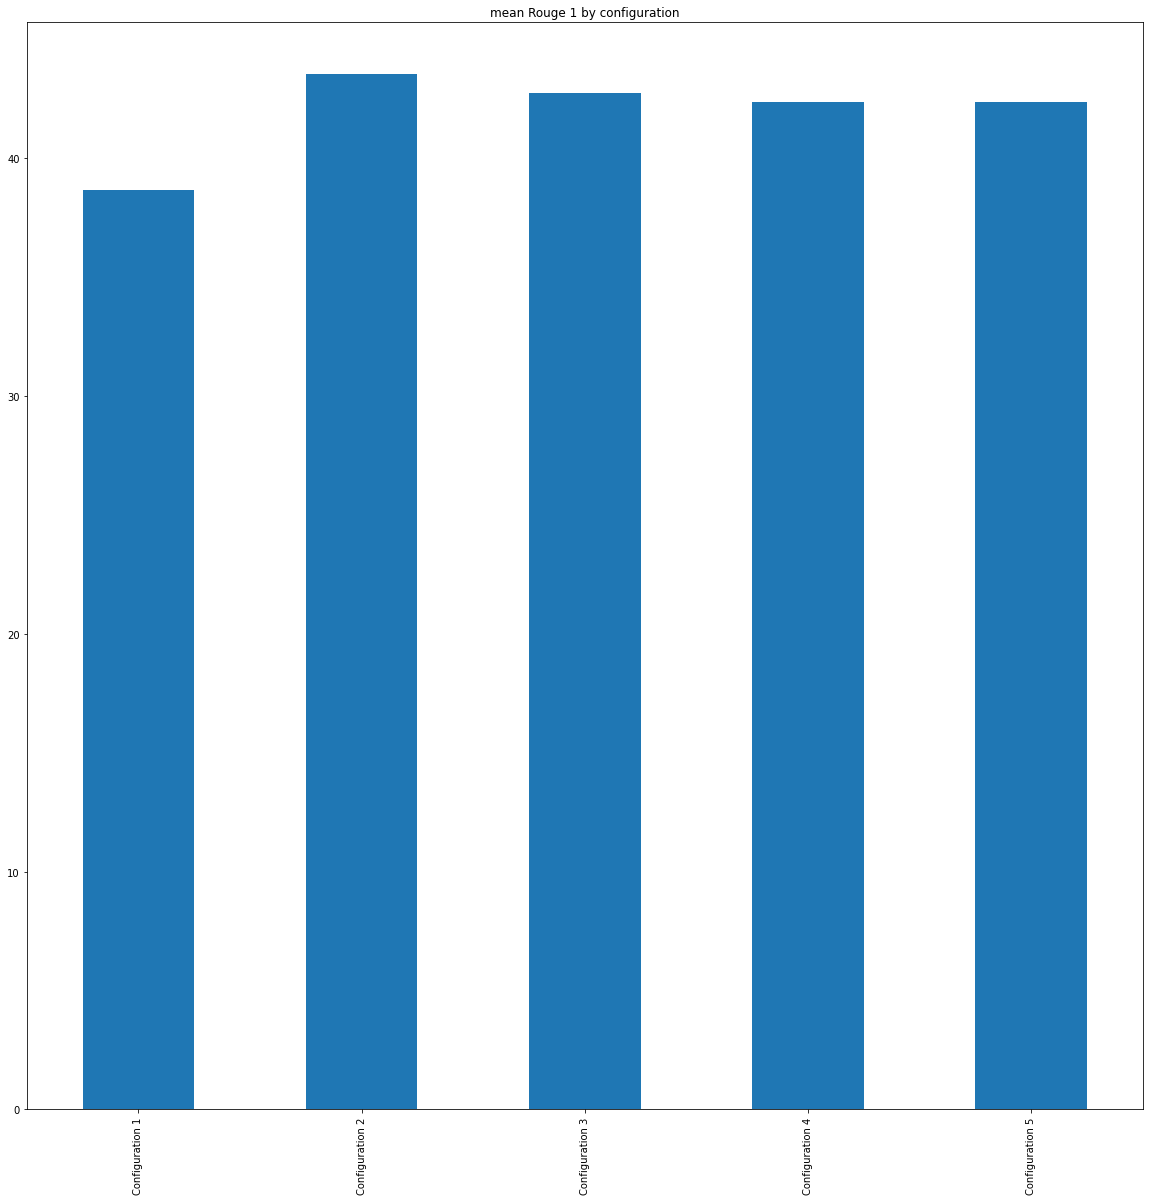

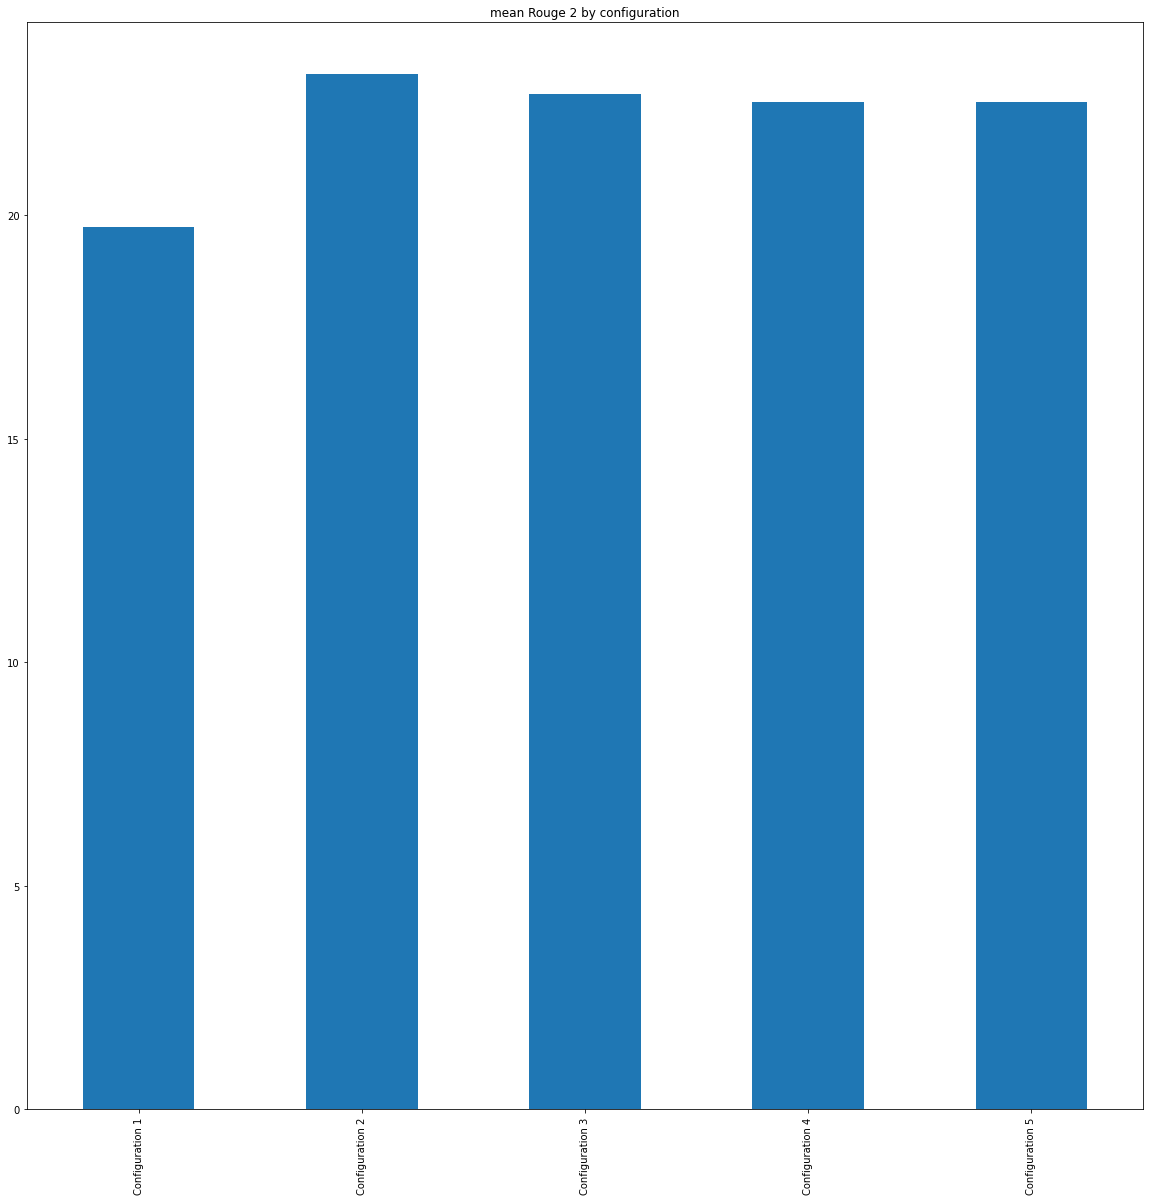

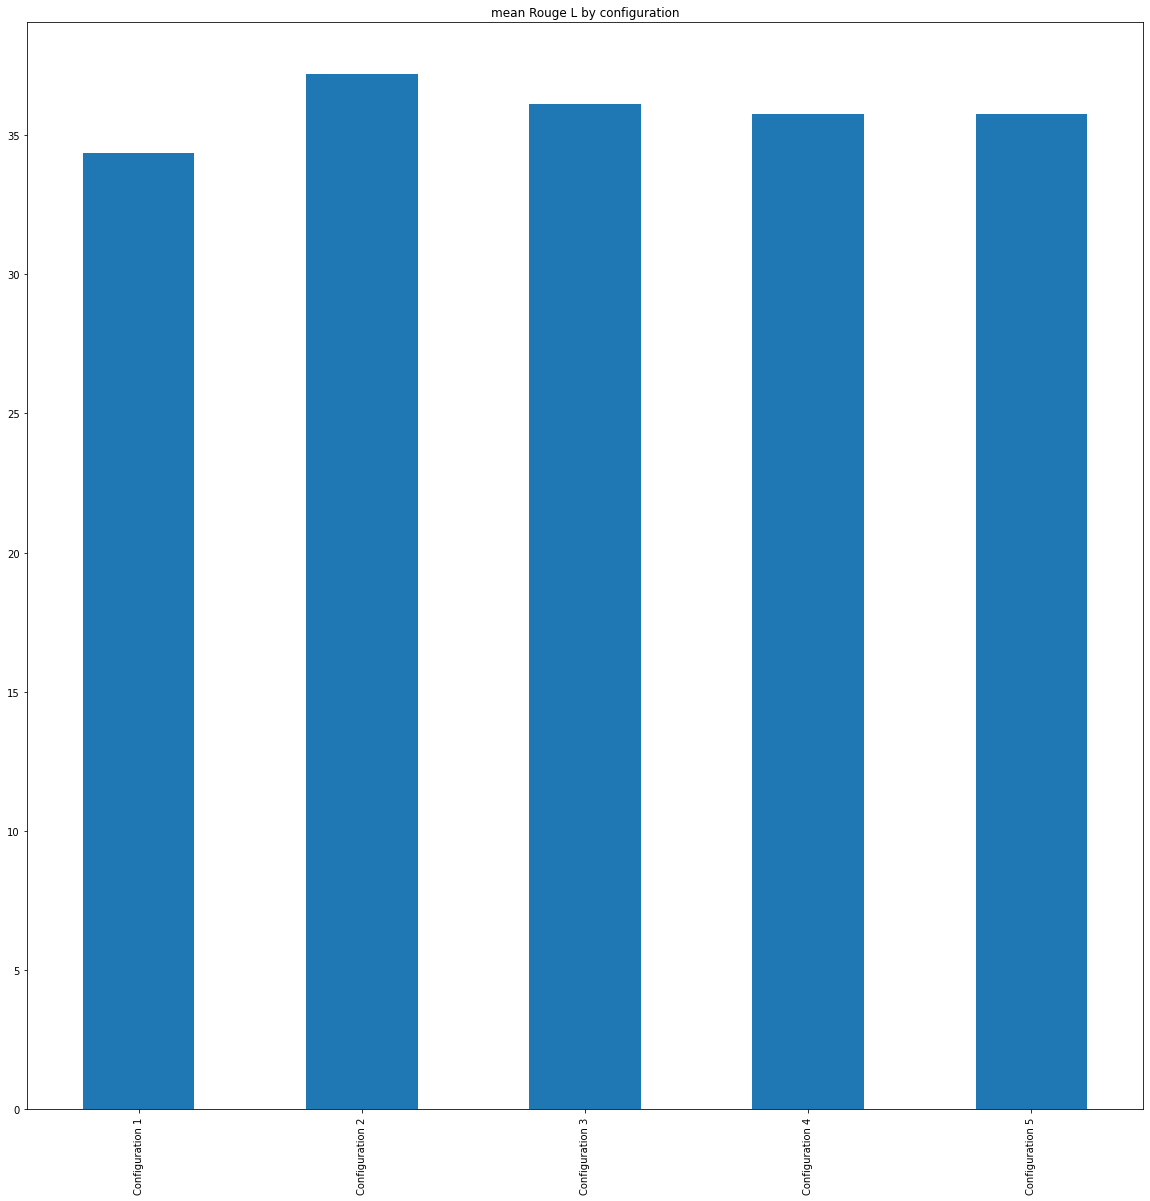

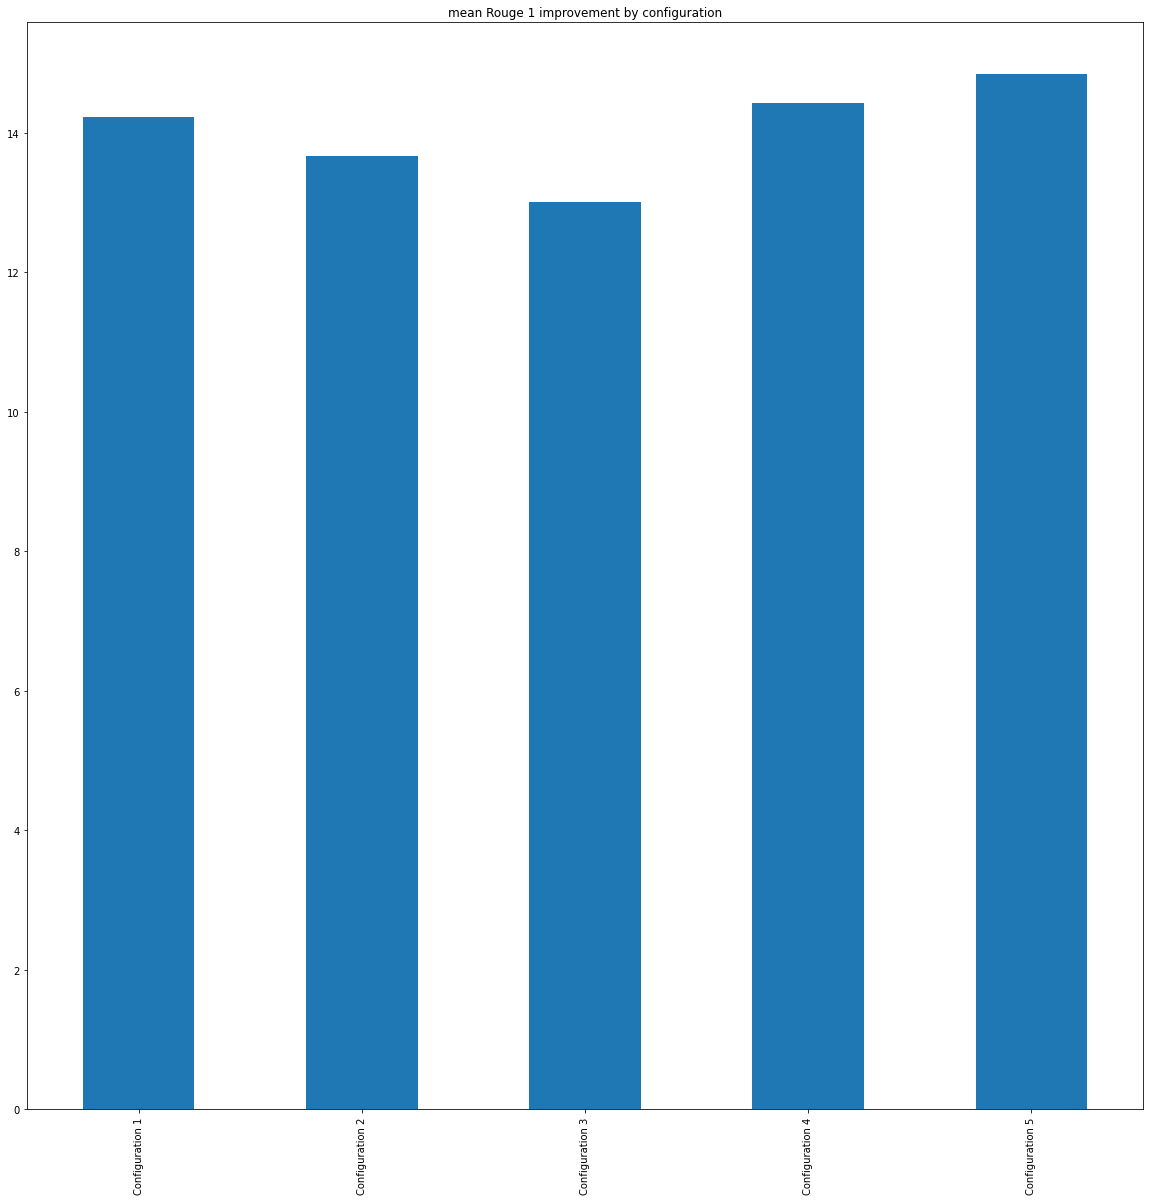

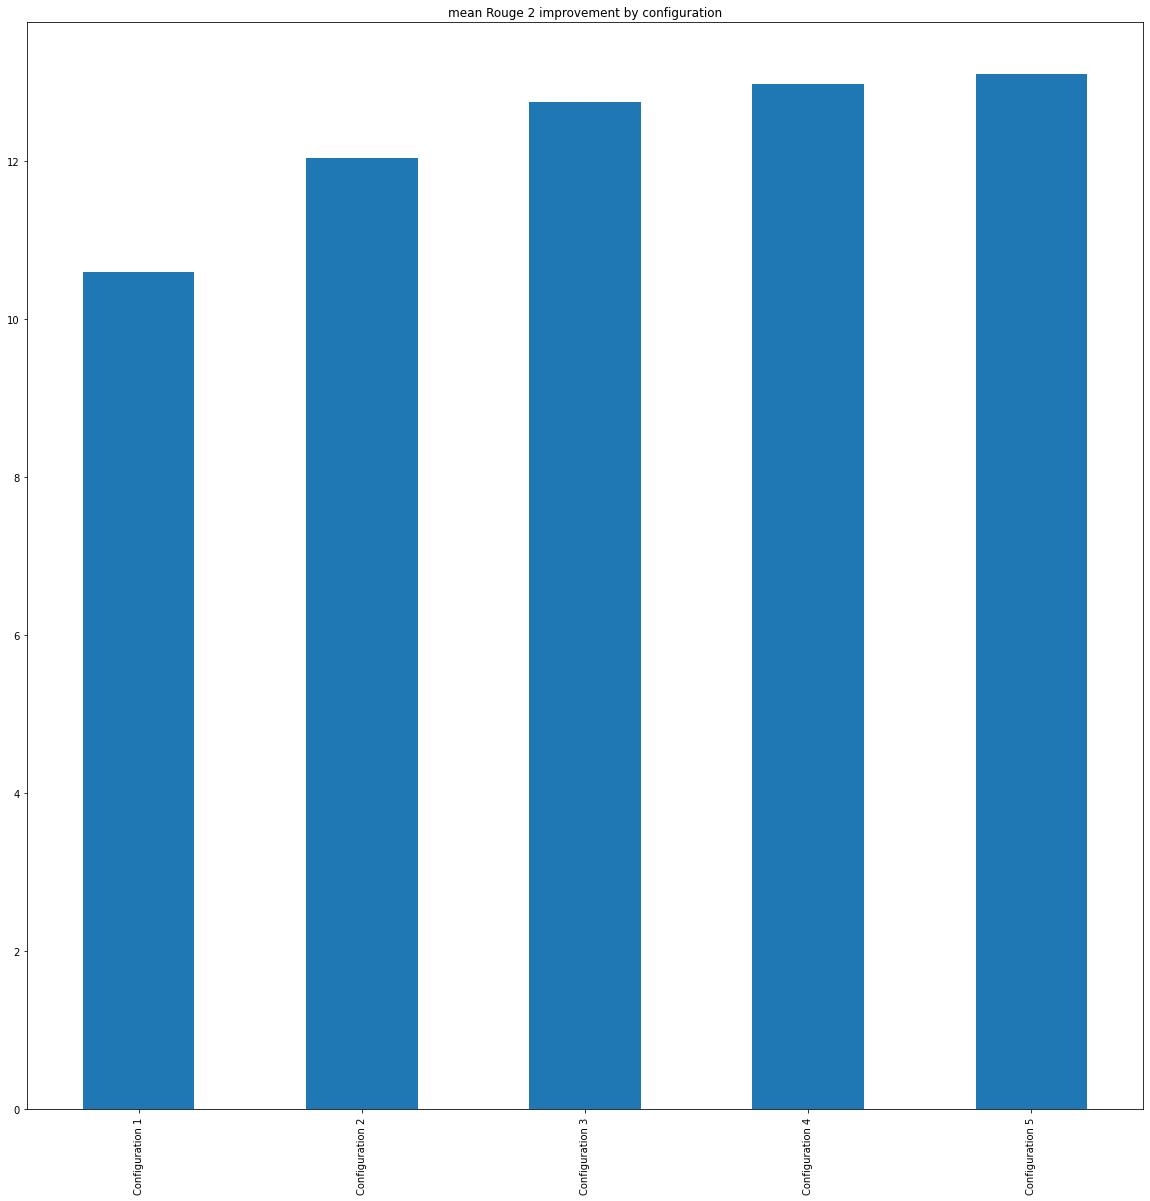

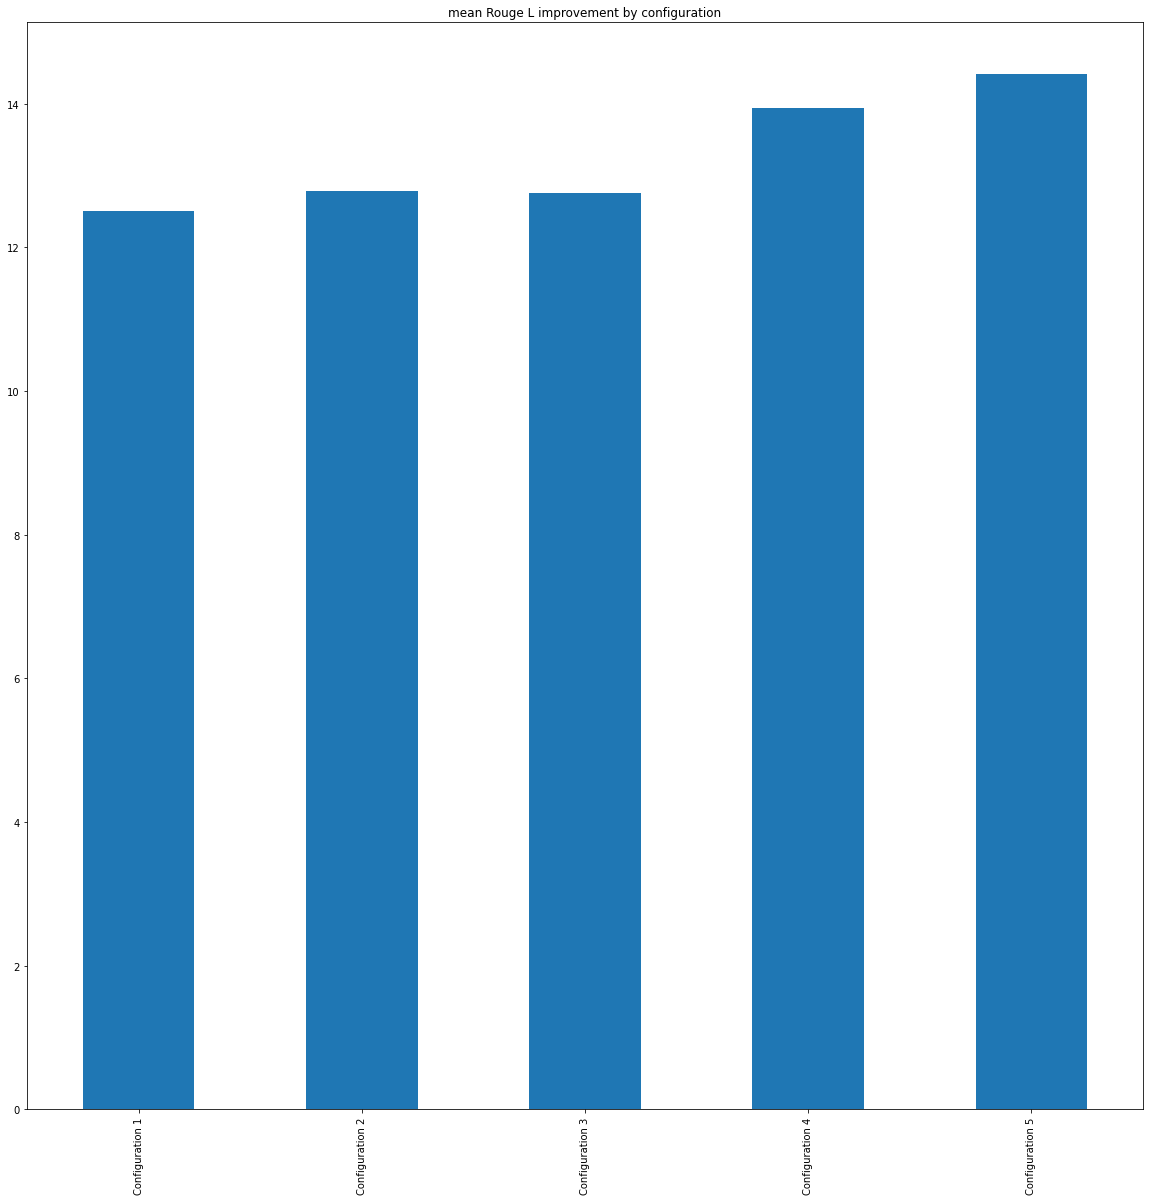

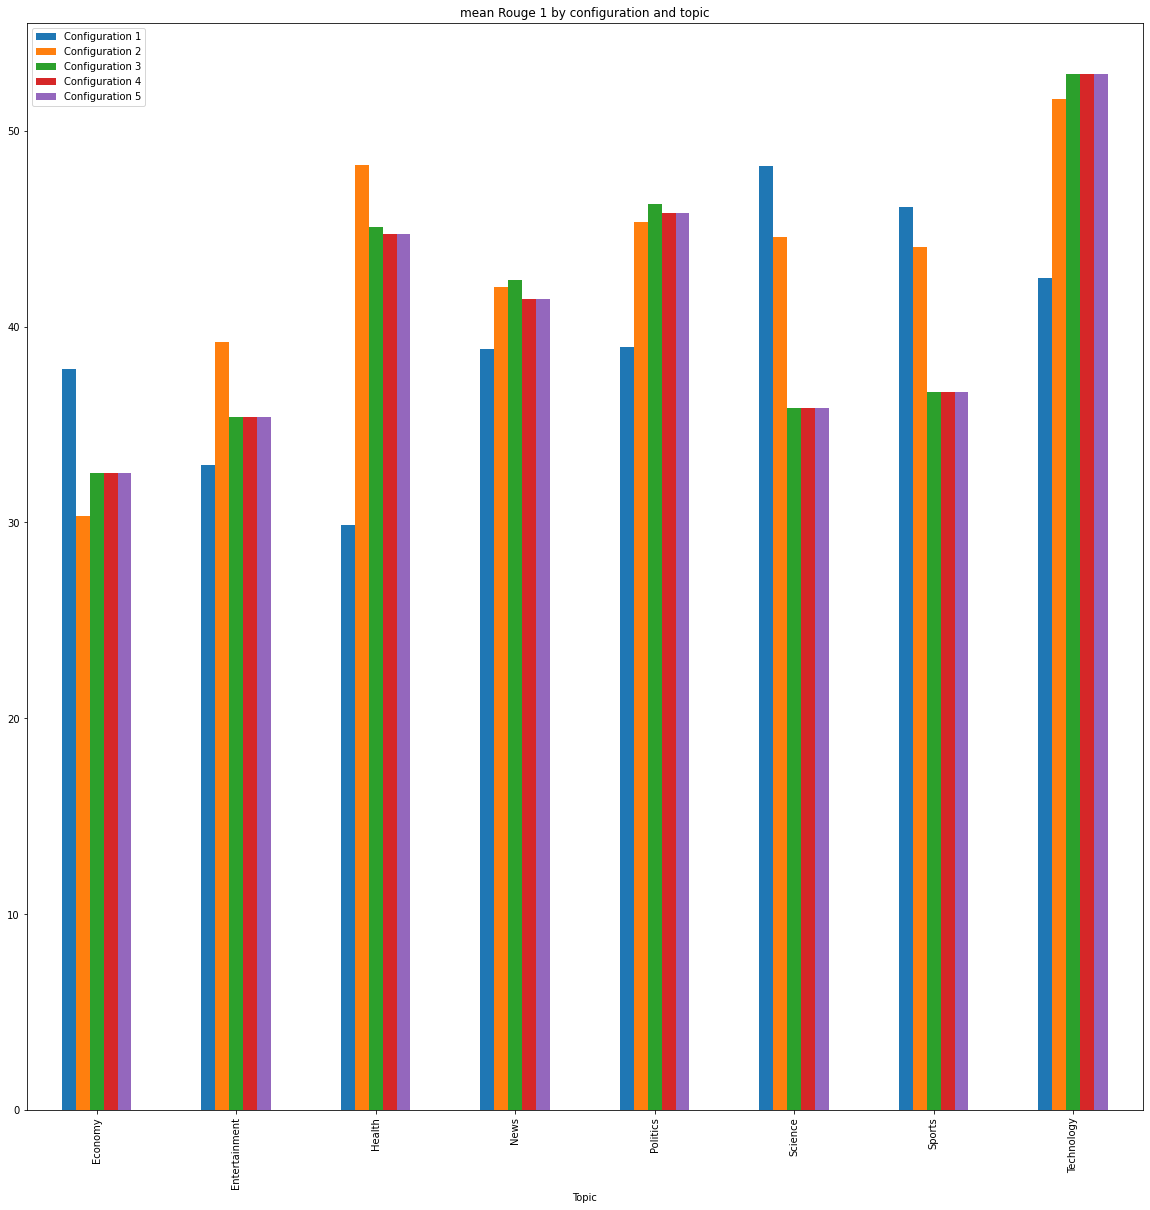

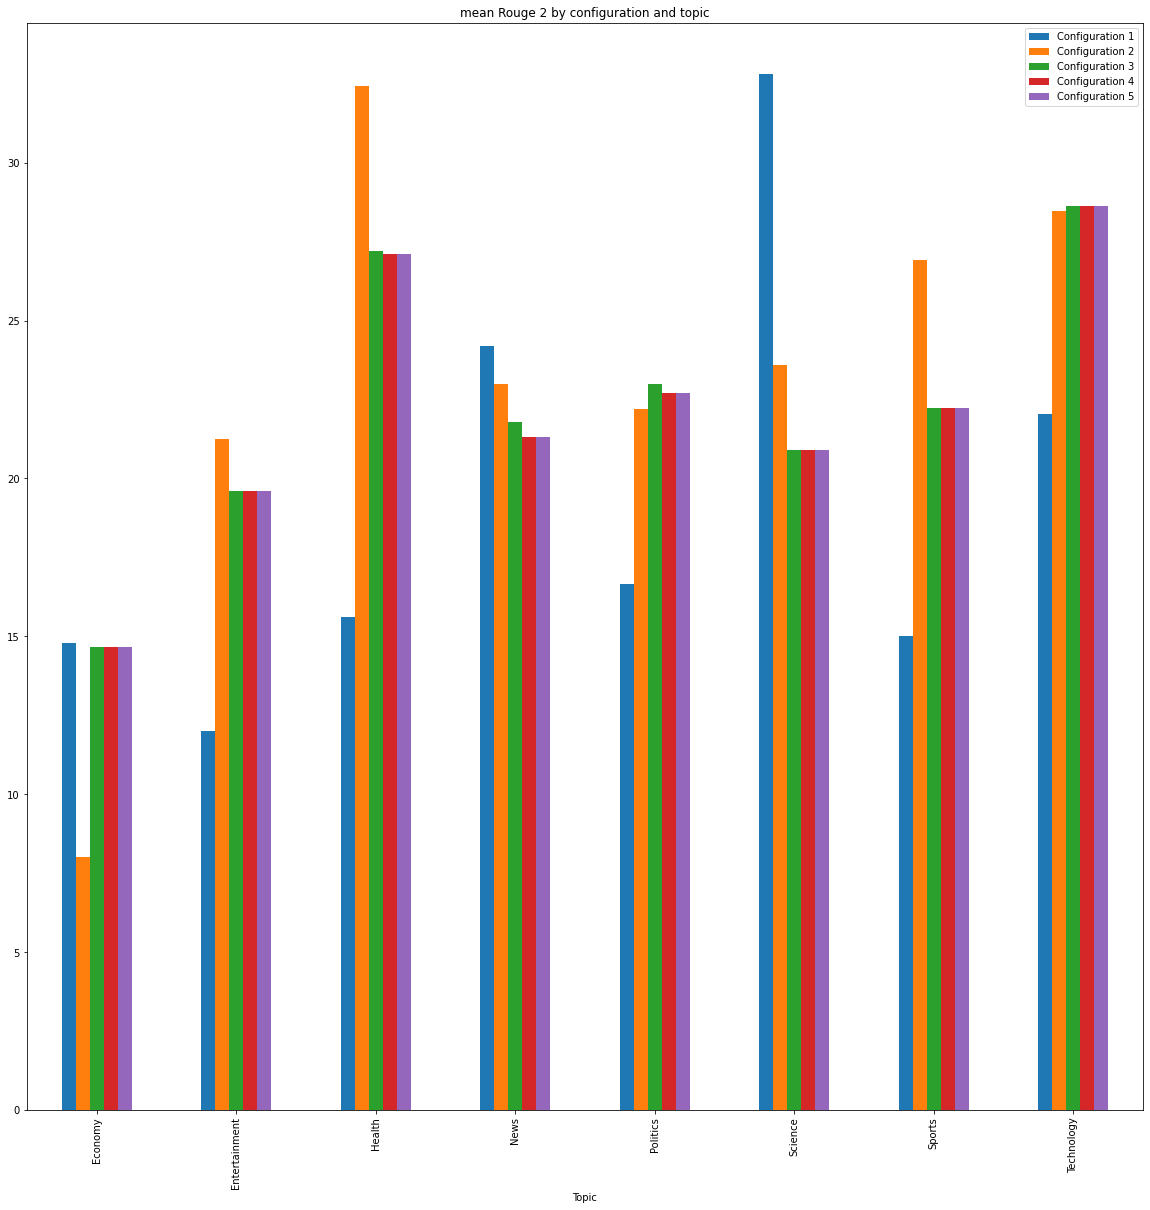

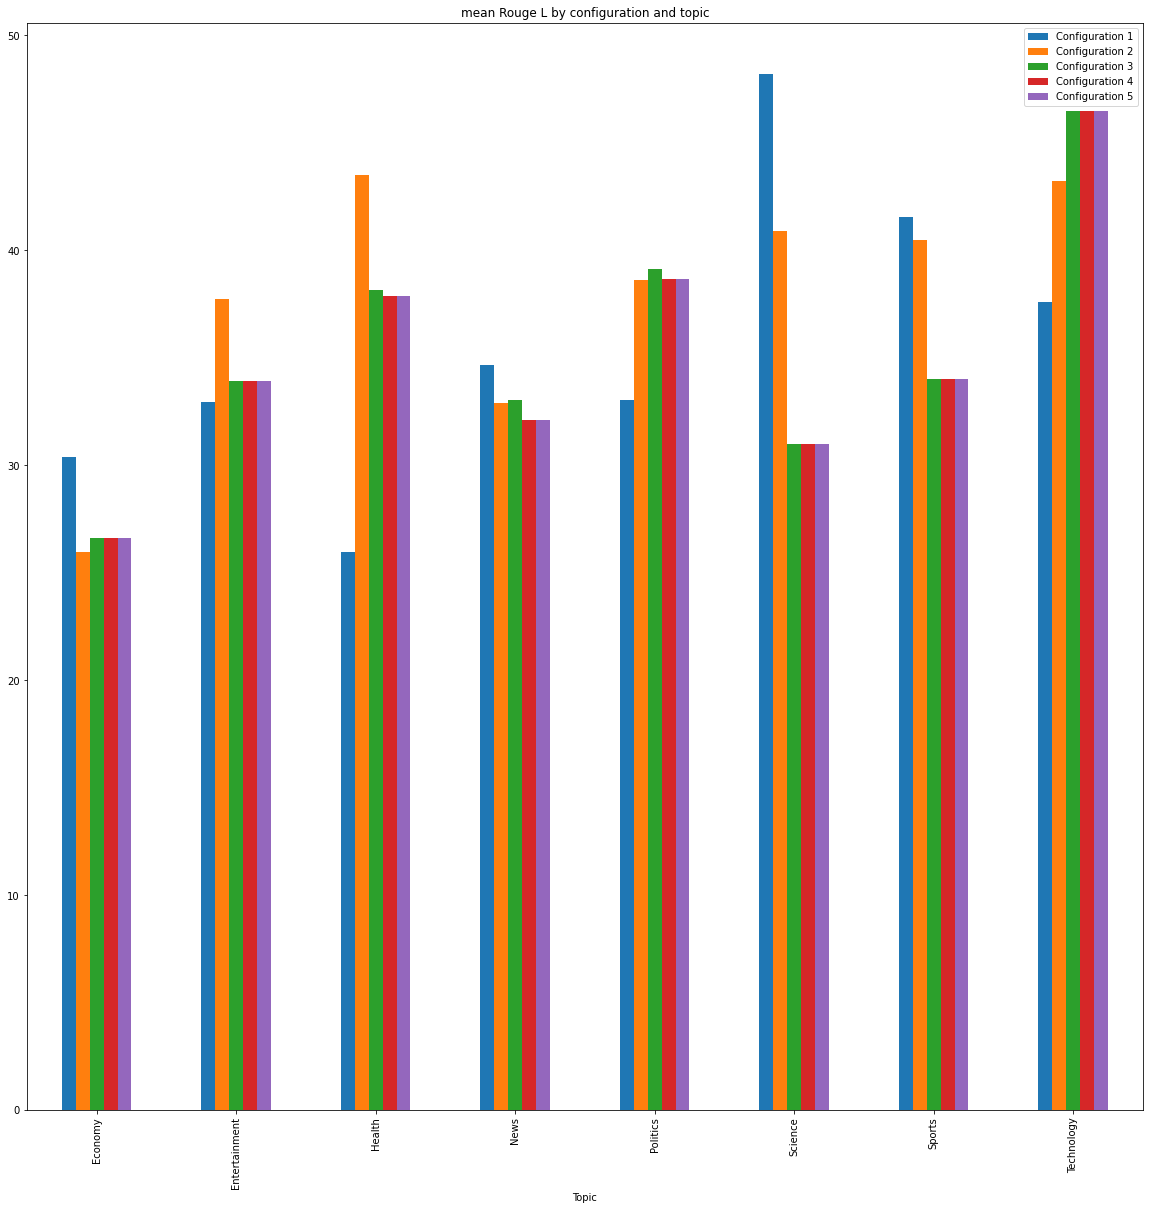

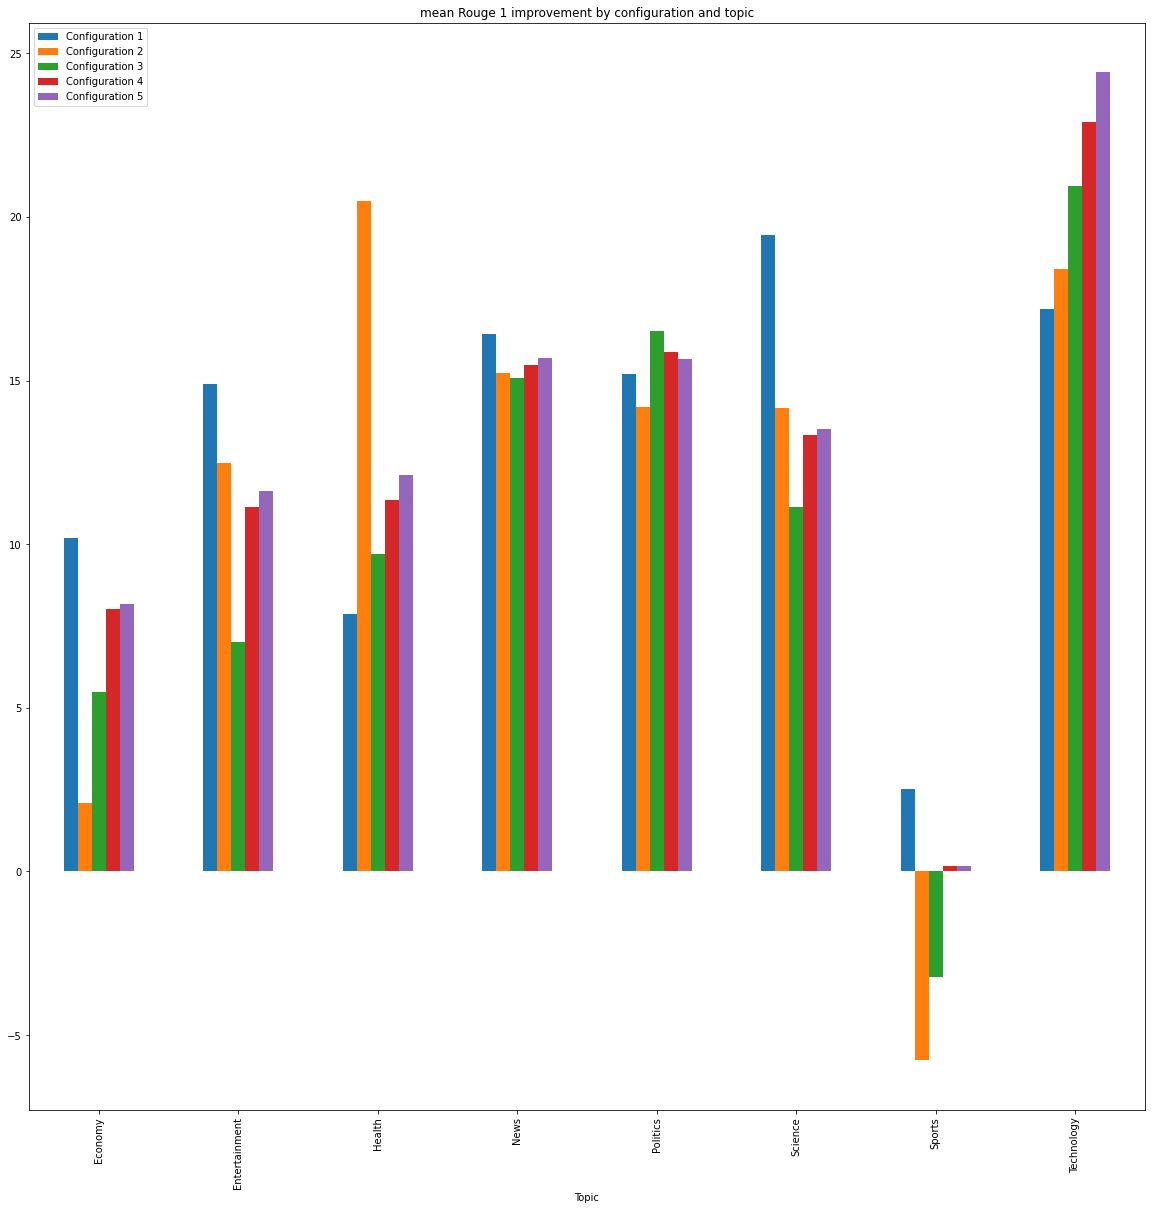

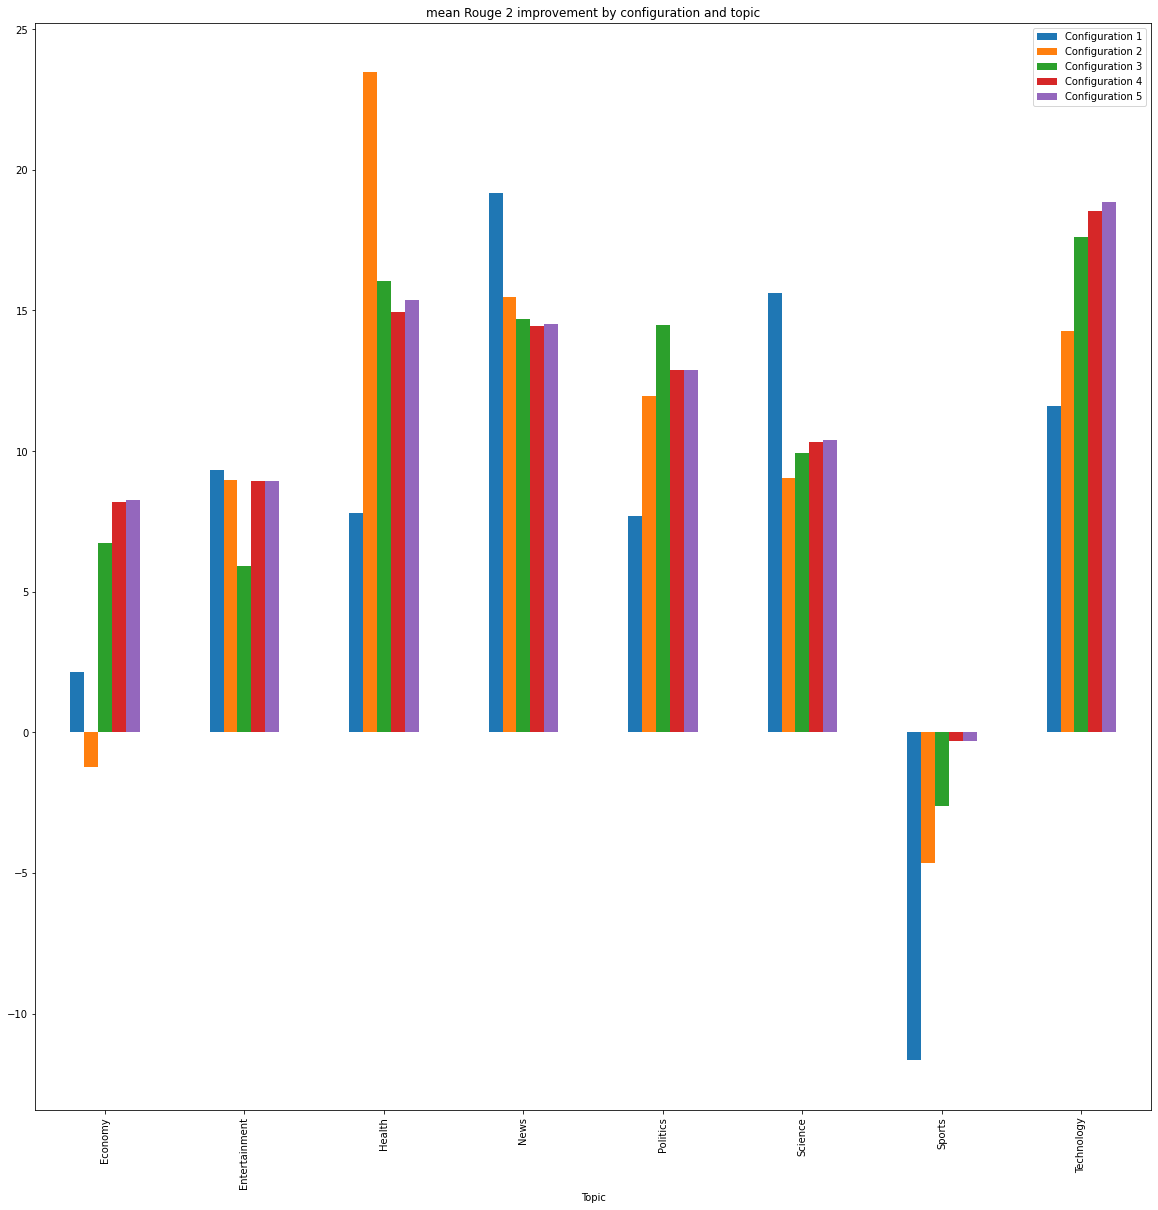

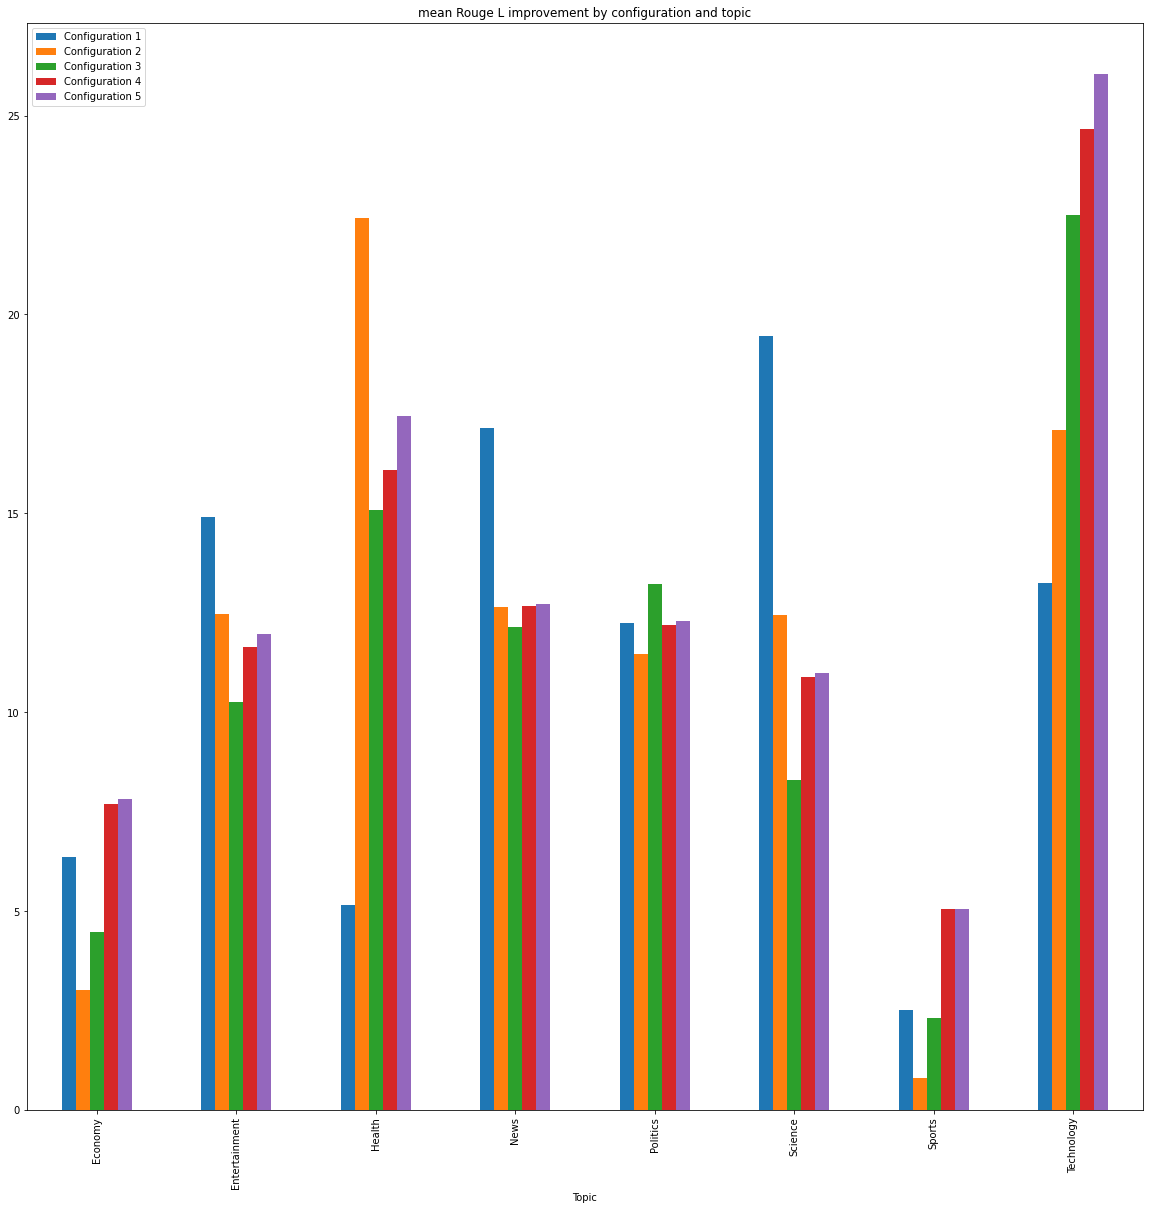

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_1 = pd.DataFrame()
rouge_2 = pd.DataFrame()
rouge_L = pd.DataFrame()
readability = pd.DataFrame()

c = 'Configuration {}'

for i in range(1,6,1):
  r1 = []
  r2 = []
  rl = []
  for _, t in data_best.iterrows():
    r = scorer.score(t[c.format(i)], t['Manually Simplified title'])
    r1.append(r['rouge1'].fmeasure * 100)
    r2.append(r['rouge2'].fmeasure * 100)
    rl.append(r['rougeL'].fmeasure * 100)
  rouge_1[c.format(i)] = r1
  rouge_2[c.format(i)] = r2
  rouge_L[c.format(i)] = rl
  readability[c.format(i)] = pd.Series(compute_scores(data_x_sum['Original title'])) - compute_scores(data_x_sum[c.format(i)]) 

rouge_1.index = X_test.index
rouge_2.index = X_test.index
rouge_L.index = X_test.index
readability.index = X_test.index

rouge_1_c = rouge_1.copy()
rouge_2_c = rouge_2.copy()
rouge_L_c = rouge_L.copy()

for i in range(1,6):
  rouge_1_c[c.format(i)] = rouge_1[c.format(i)] - rouge_1_pt[c.format(i)]
  rouge_2_c[c.format(i)] = rouge_2[c.format(i)] - rouge_2_pt[c.format(i)]
  rouge_L_c[c.format(i)] = rouge_L[c.format(i)] - rouge_L_pt[c.format(i)]

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))
fig5, axes5 = plt.subplots(figsize=(20, 20))
fig6, axes6 = plt.subplots(figsize=(20, 20))
fig7, axes7 = plt.subplots(figsize=(20, 20))
fig8, axes8 = plt.subplots(figsize=(20, 20))
fig9, axes9 = plt.subplots(figsize=(20, 20))
fig10, axes10 = plt.subplots(figsize=(20, 20))
fig11, axes11 = plt.subplots(figsize=(20, 20))
fig12, axes12 = plt.subplots(figsize=(20, 20))

rouge_1.mean().plot(kind='bar', title='mean Rouge 1 by configuration', ax=axes1)
rouge_2.mean().plot(kind='bar', title='mean Rouge 2 by configuration', ax=axes2)
rouge_L.mean().plot(kind='bar', title='mean Rouge L by configuration', ax=axes3)
rouge_1_c.mean().plot(kind='bar', title='mean Rouge 1 improvement by configuration', ax=axes4)
rouge_2_c.mean().plot(kind='bar', title='mean Rouge 2 improvement by configuration', ax=axes5)
rouge_L_c.mean().plot(kind='bar', title='mean Rouge L improvement by configuration', ax=axes6)

rouge_1['Topic'] = X_test['Topic']
rouge_2['Topic'] = X_test['Topic']
rouge_L['Topic'] = X_test['Topic']
rouge_1_c['Topic'] = X_test['Topic']
rouge_2_c['Topic'] = X_test['Topic']
rouge_L_c['Topic'] = X_test['Topic']

rouge_1.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 1 by configuration and topic', ax=axes7)
rouge_2.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 2 by configuration and topic', ax=axes8)
rouge_L.groupby('Topic').mean().plot(kind='bar', title='mean Rouge L by configuration and topic', ax=axes9)
rouge_1_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 1 improvement by configuration and topic', ax=axes10)
rouge_2_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 2 improvement by configuration and topic', ax=axes11)
rouge_L_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge L improvement by configuration and topic', ax=axes12)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_tl_best_configuration.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_tl_best_configuration.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_tl_best_configuration.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_improvement_tl_best_configuration.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_improvement_tl_best_configuration.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_improvement_tl_best_configuration.svg')
fig7.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_tl_best_configuration_by_topic.svg')
fig8.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_tl_best_configuration_by_topic.svg')
fig9.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_tl_best_configuration_by_topic.svg')
fig10.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_improvement_tl_best_configuration_by_topic.svg')
fig11.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_improvement_tl_best_configuration_by_topic.svg')
fig12.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_improvement_tl_best_configuration_by_topic.svg')

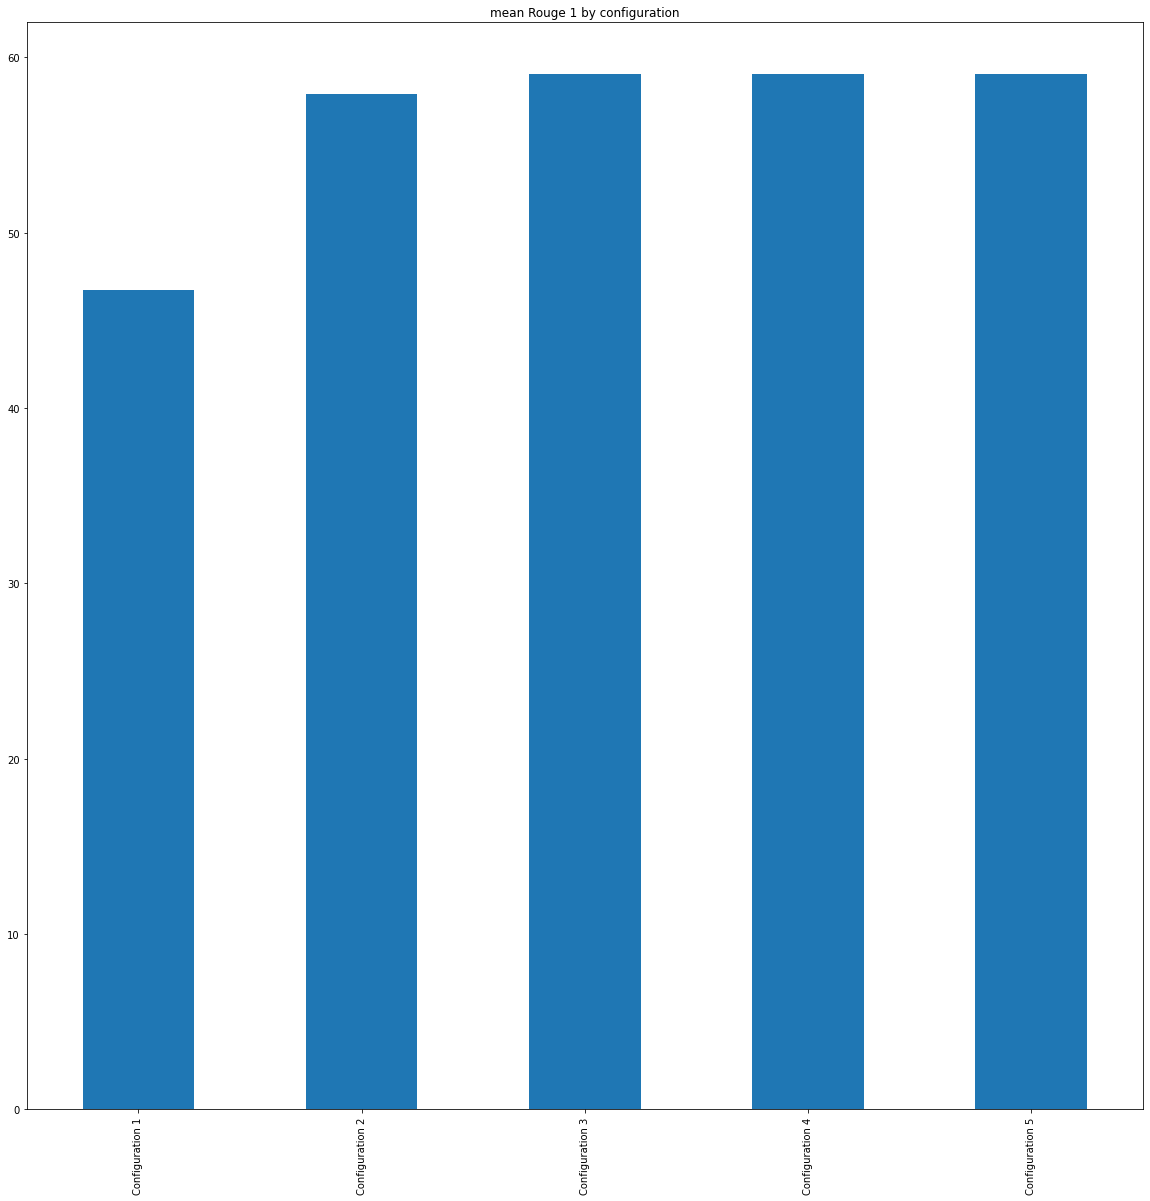

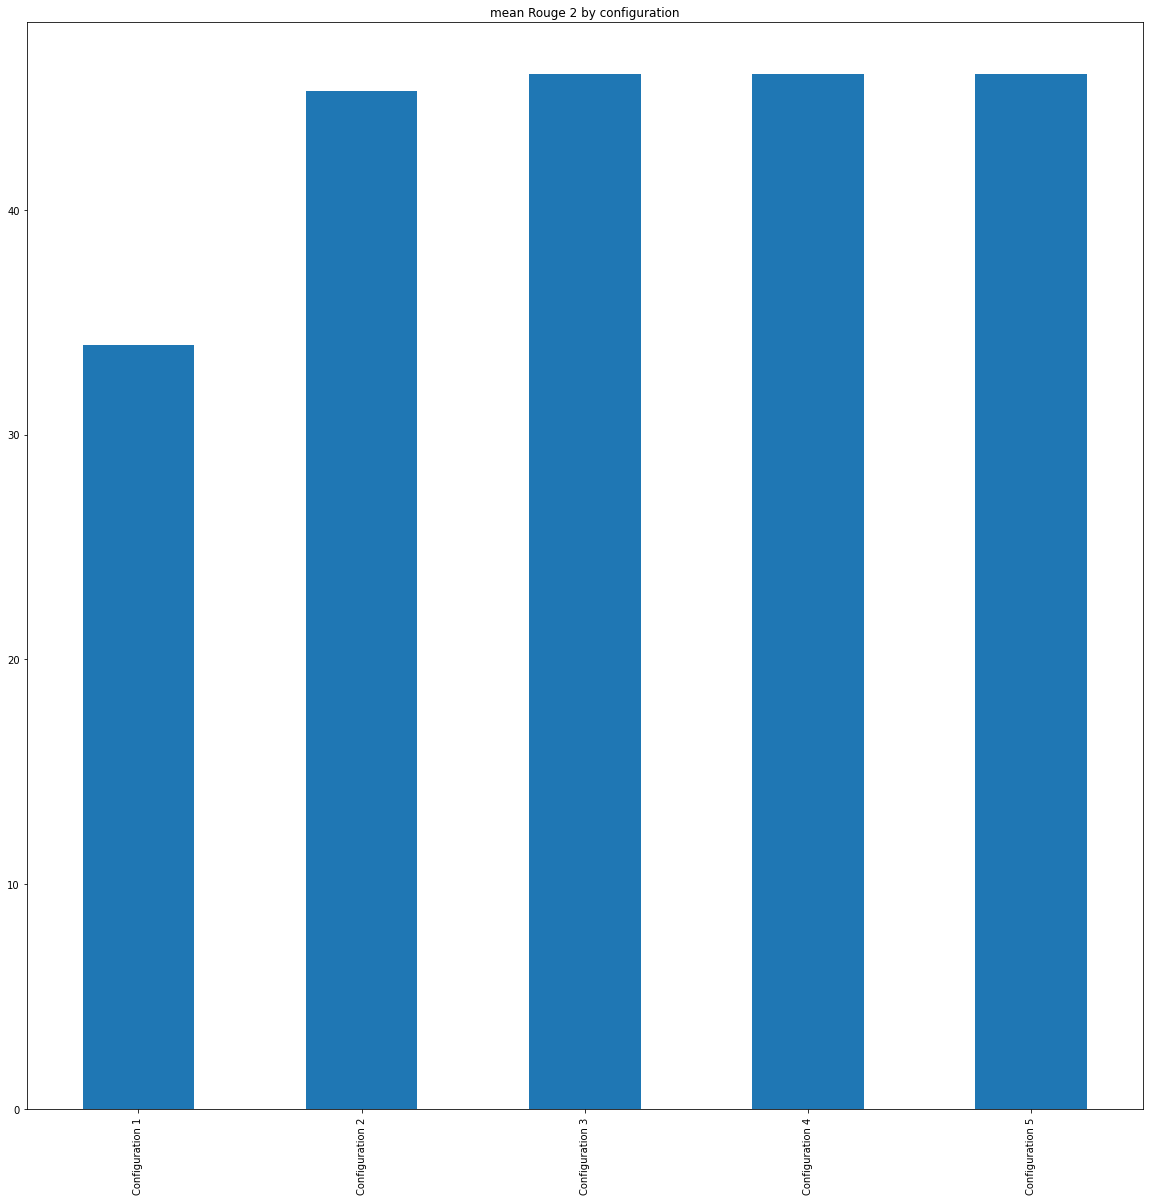

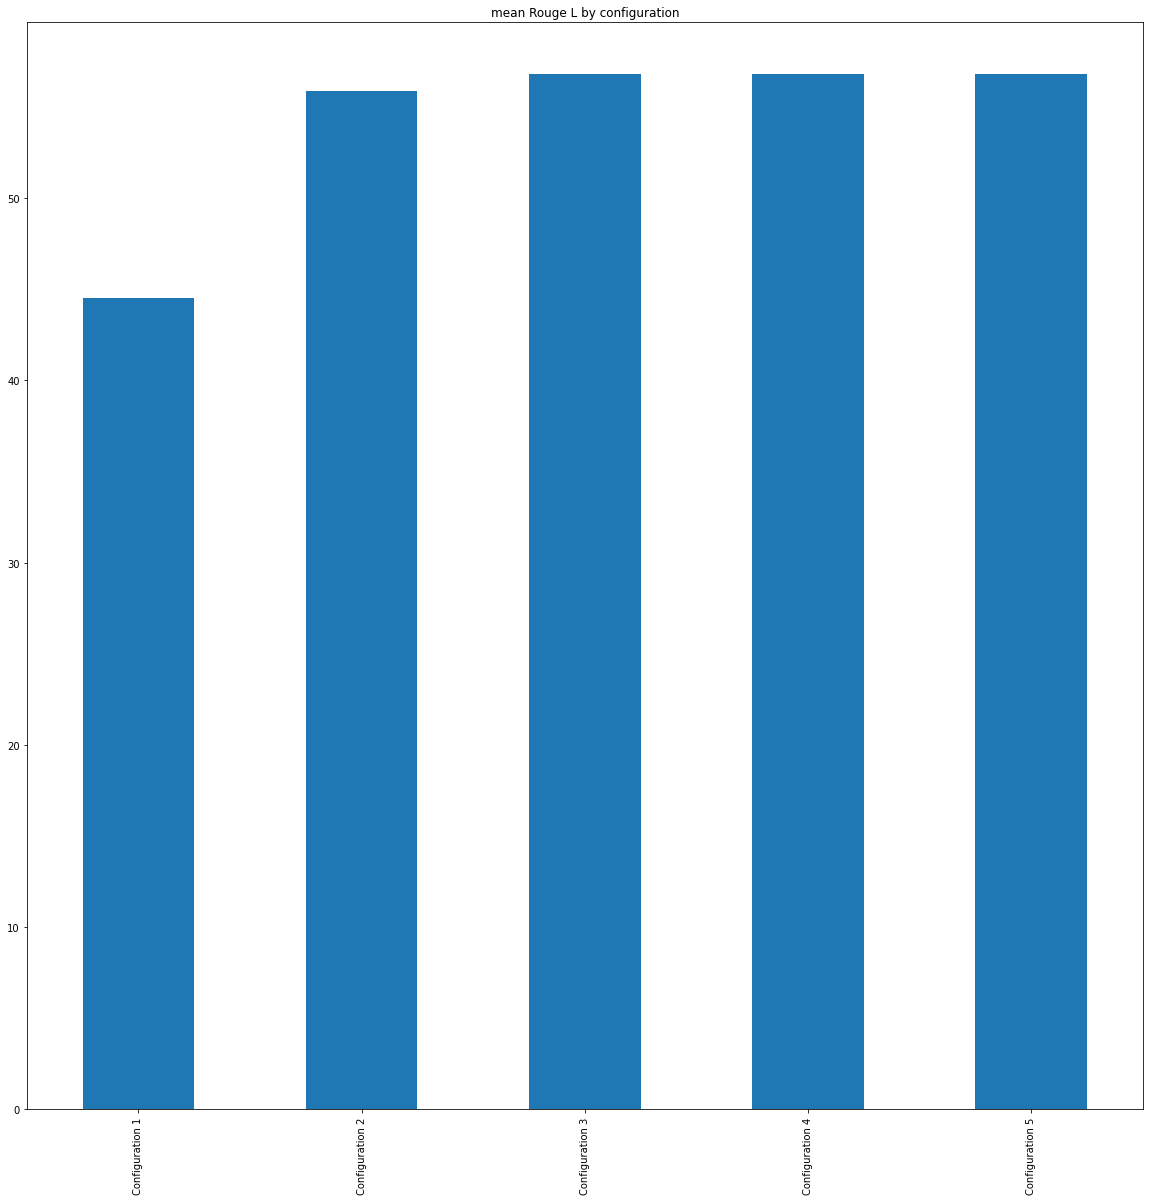

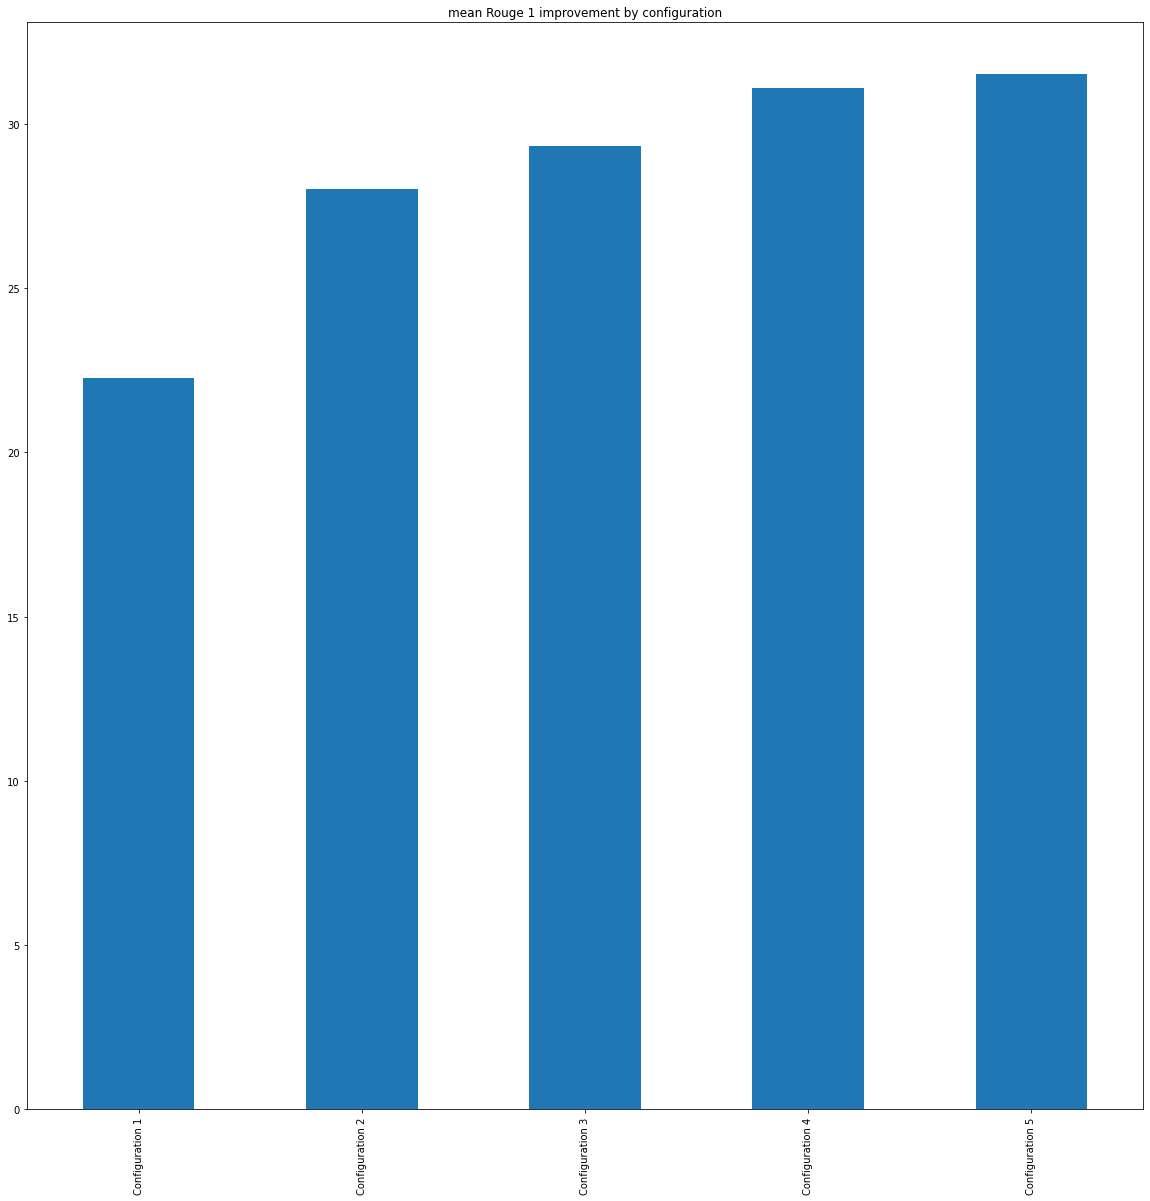

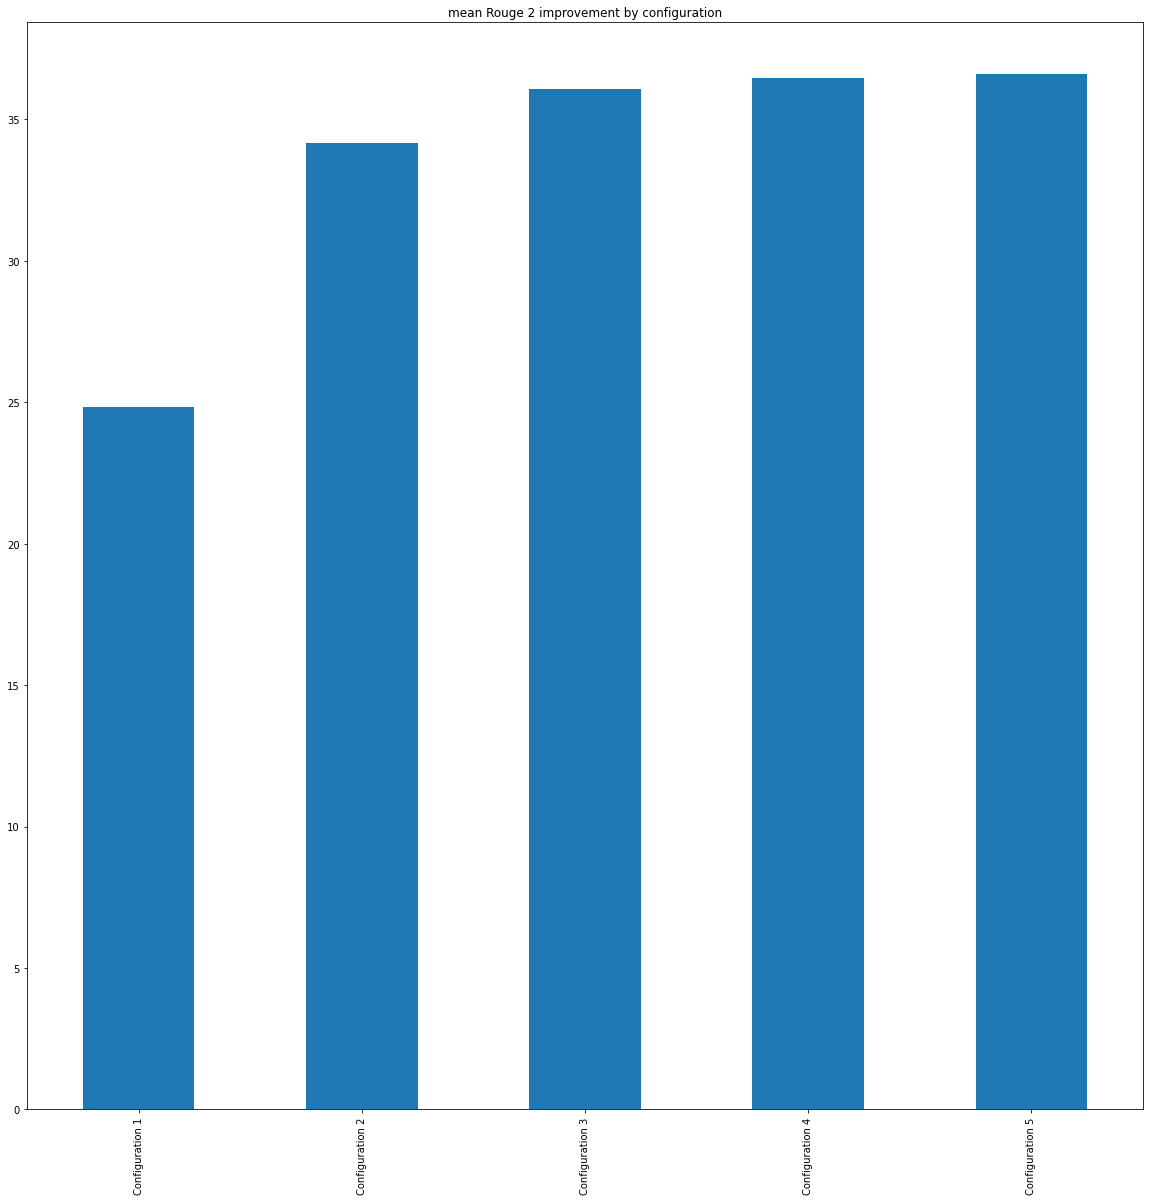

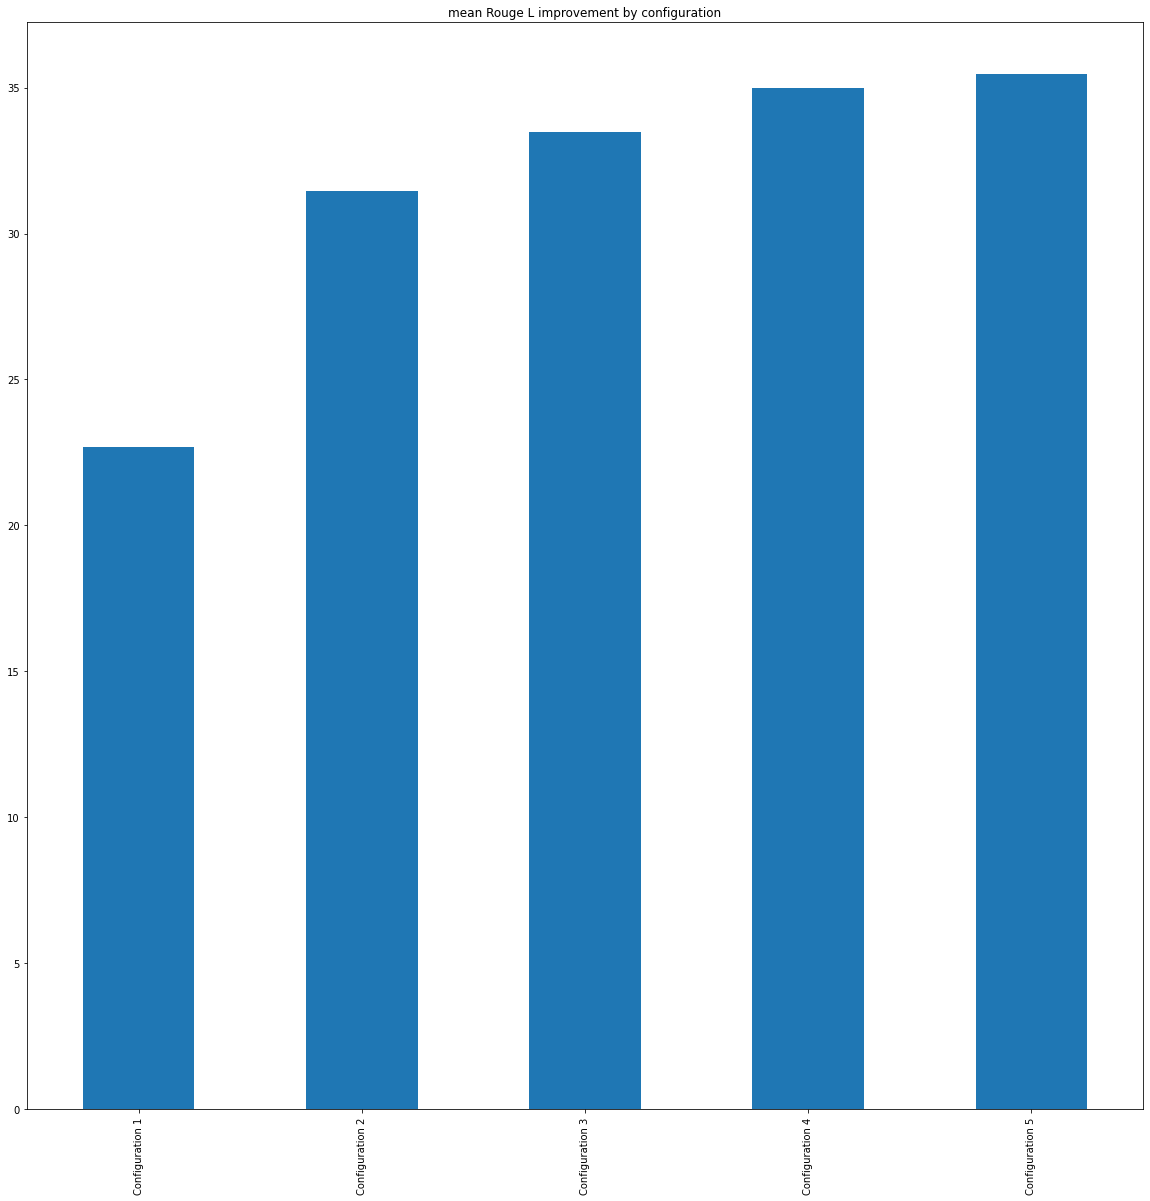

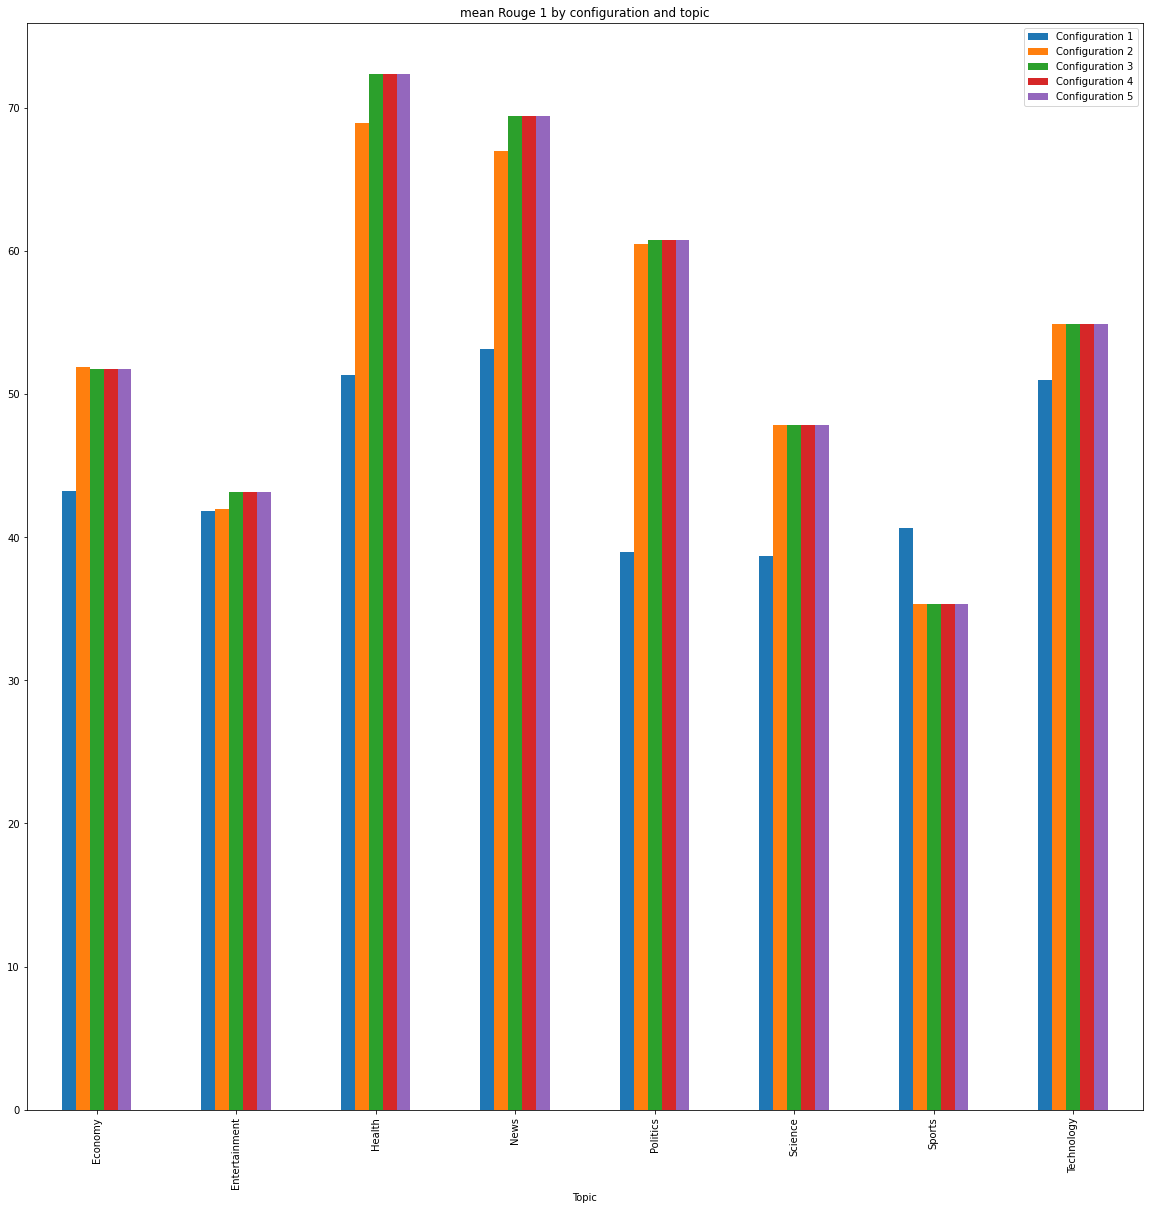

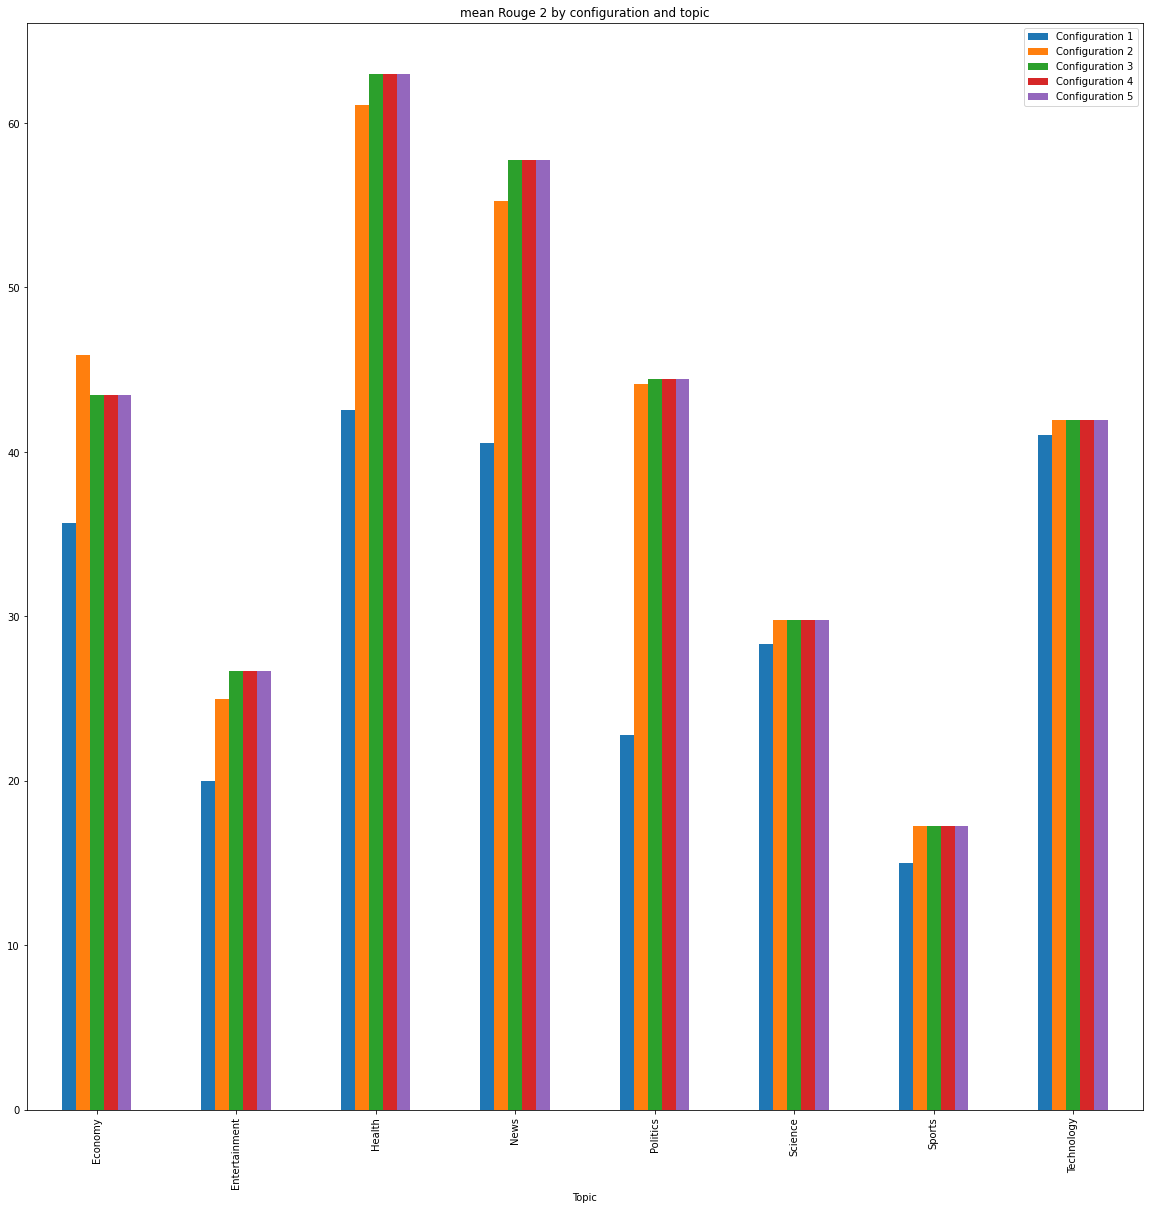

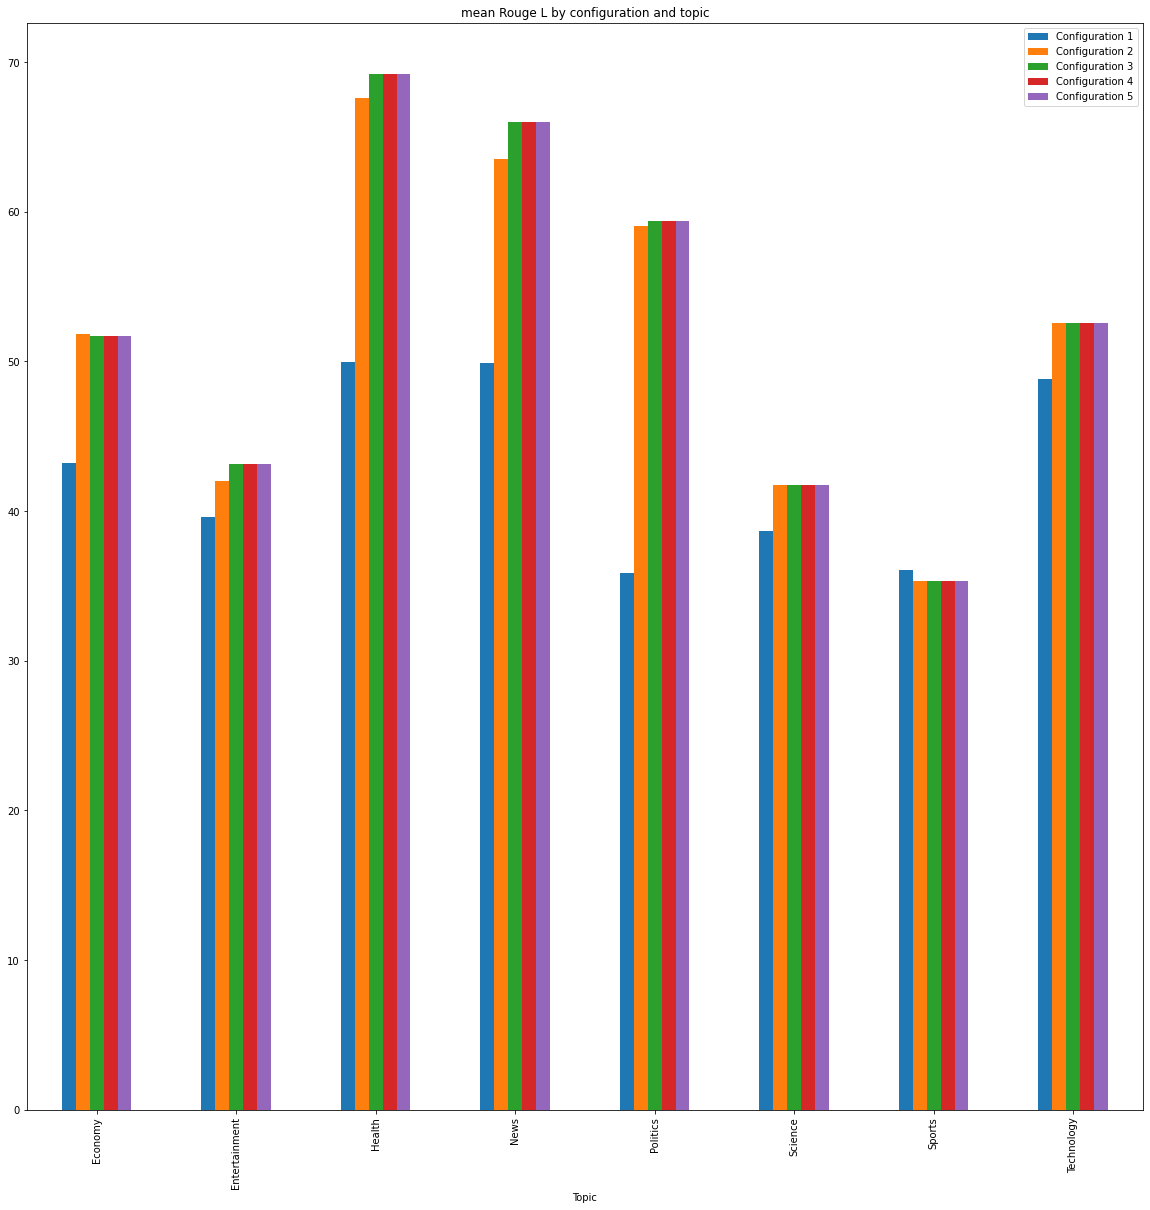

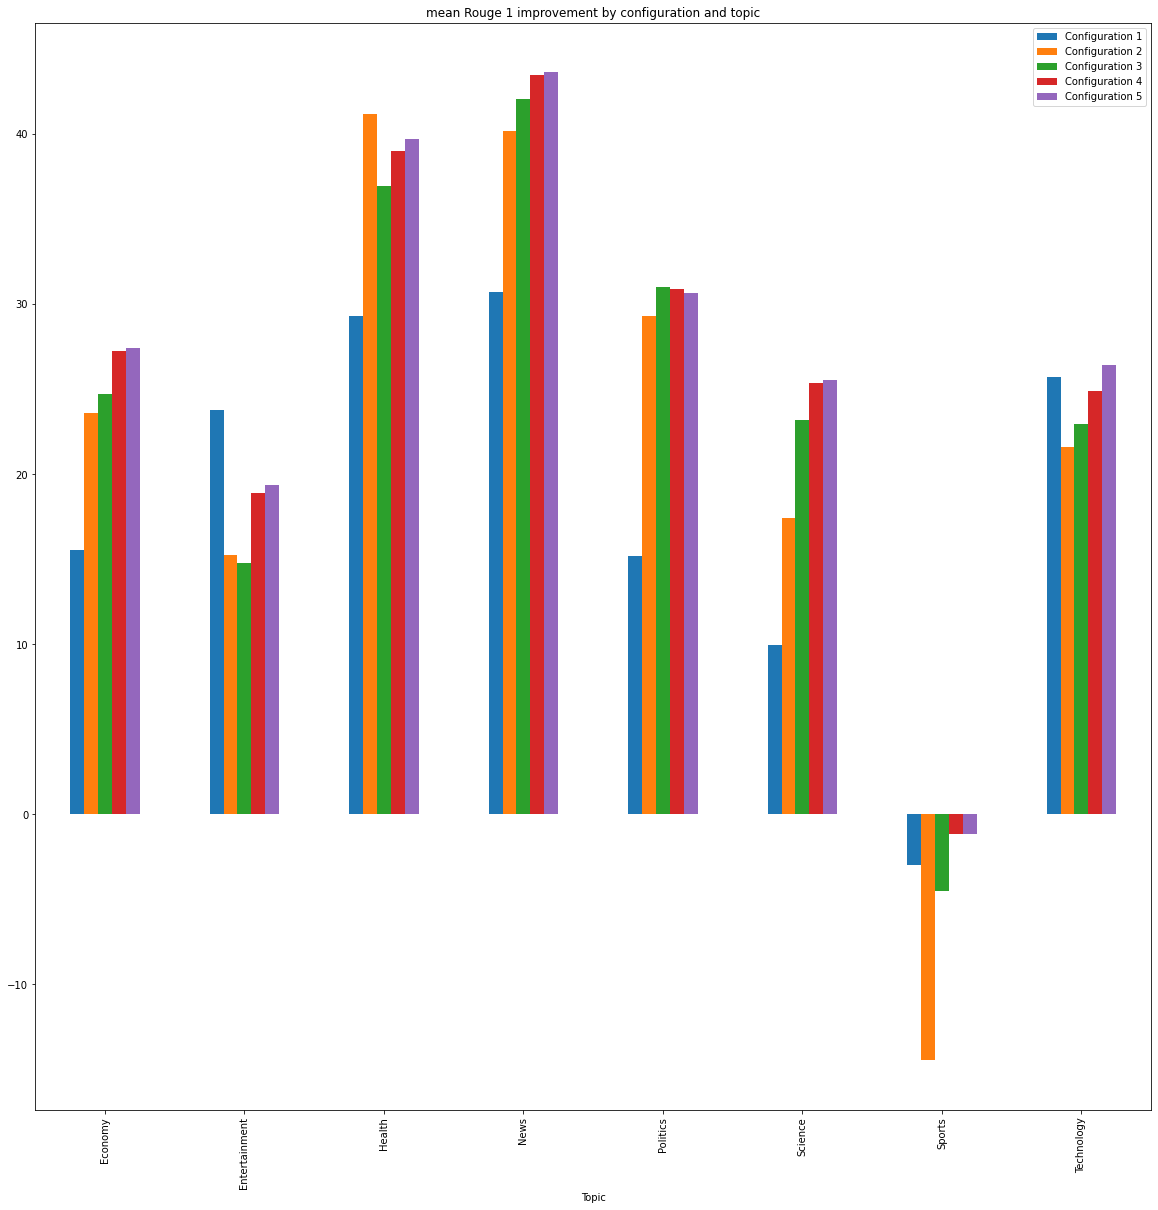

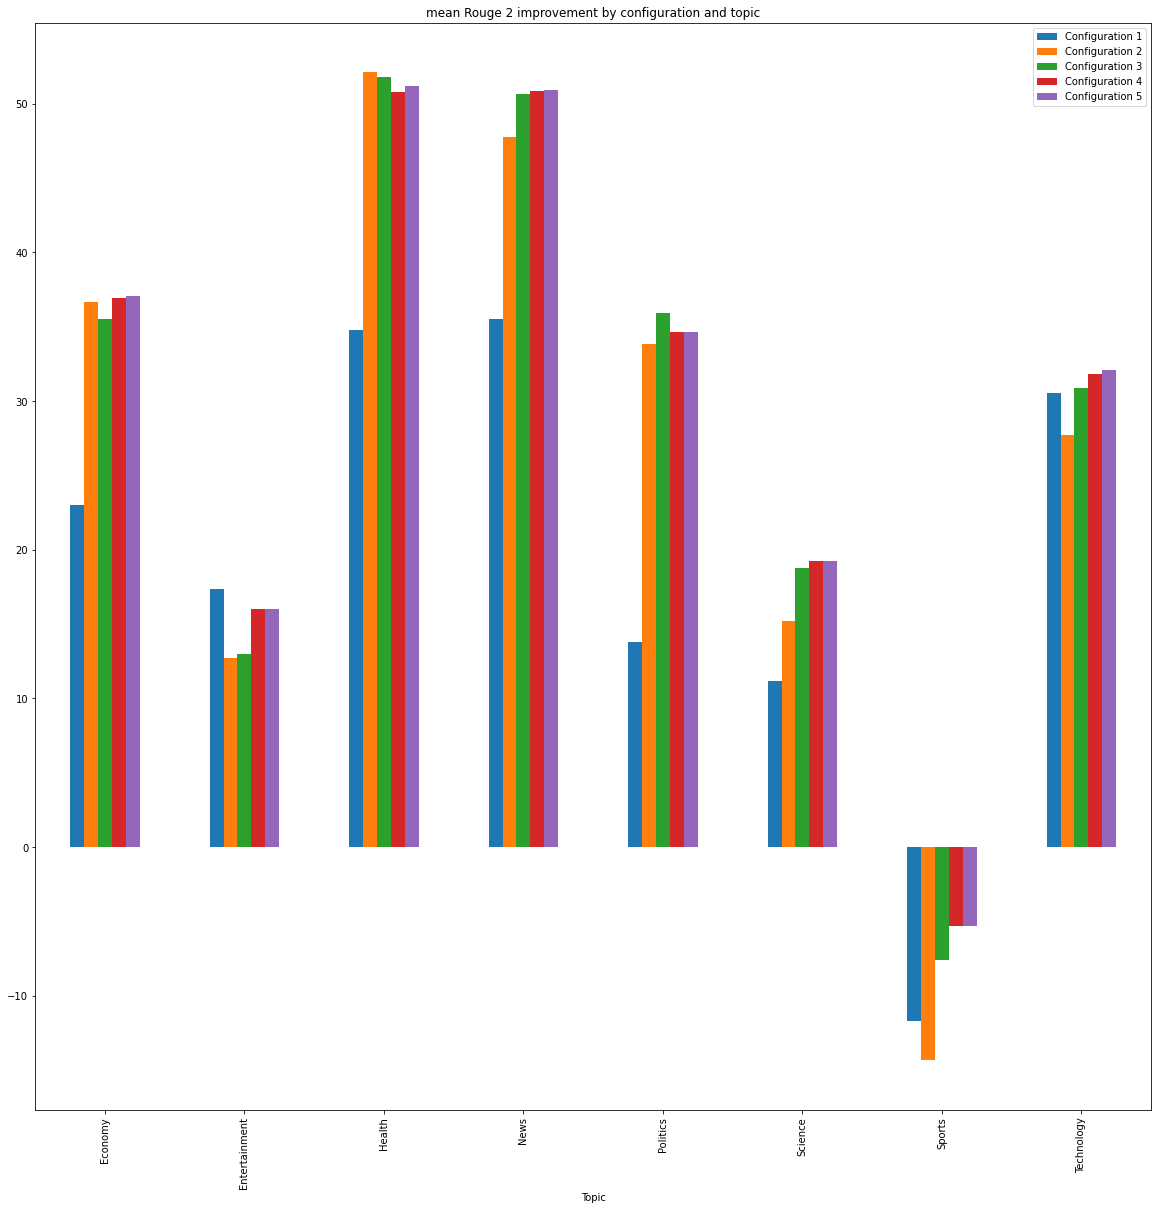

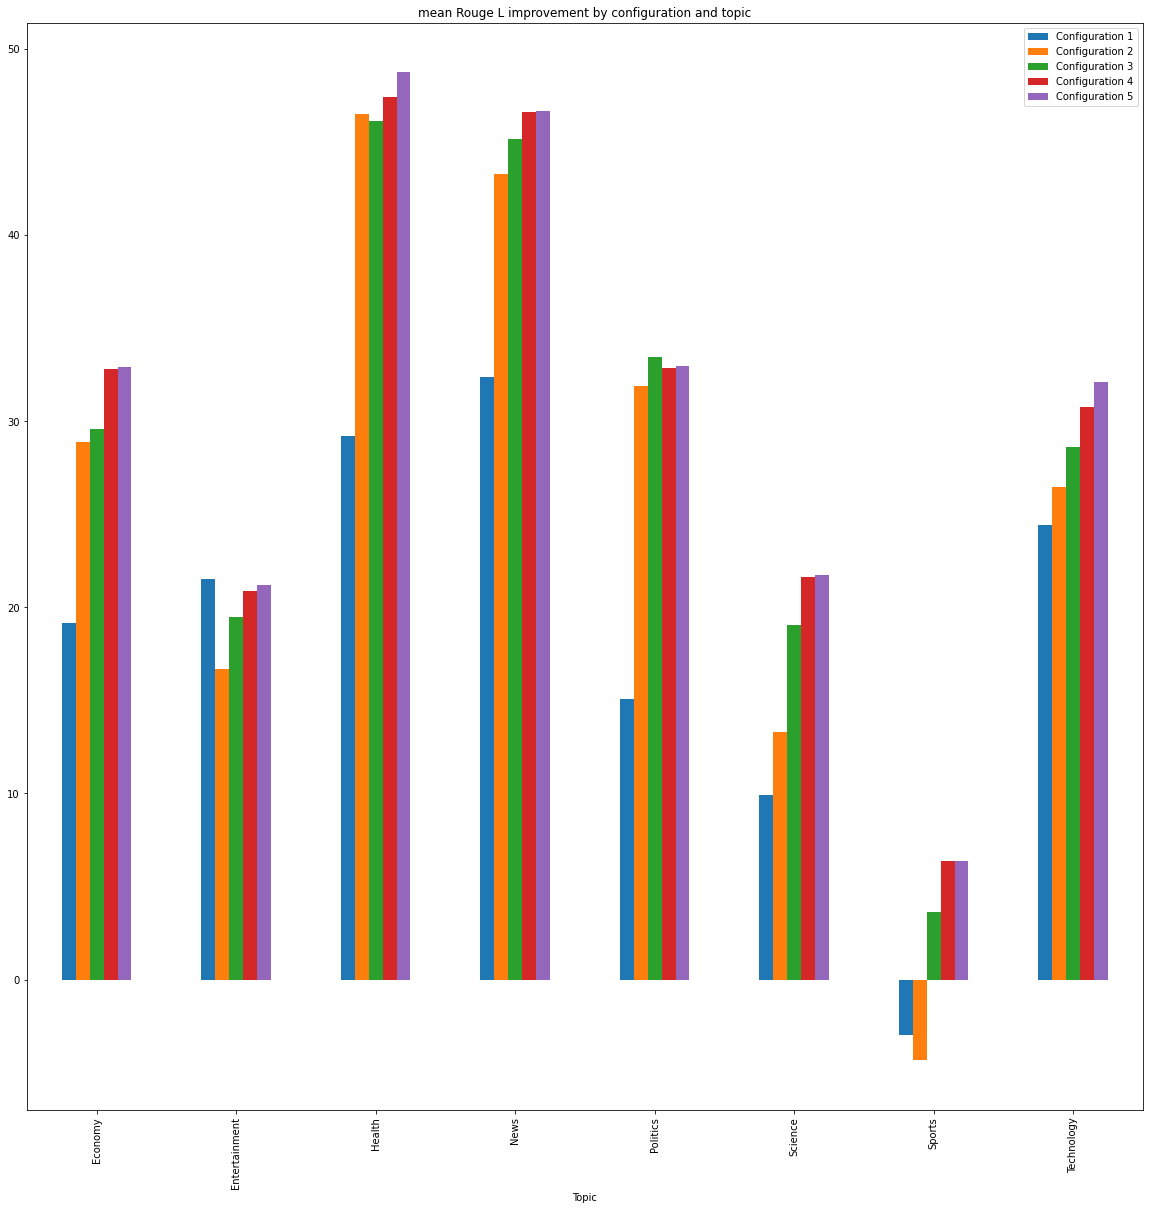

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_1 = pd.DataFrame()
rouge_2 = pd.DataFrame()
rouge_L = pd.DataFrame()
readability = pd.DataFrame()

c = 'Configuration {}'

for i in range(1,6,1):
  r1 = []
  r2 = []
  rl = []
  for _, t in data_last.iterrows():
    r = scorer.score(t[c.format(i)], t['Manually Simplified title'])
    r1.append(r['rouge1'].fmeasure * 100)
    r2.append(r['rouge2'].fmeasure * 100)
    rl.append(r['rougeL'].fmeasure * 100)
  rouge_1[c.format(i)] = r1
  rouge_2[c.format(i)] = r2
  rouge_L[c.format(i)] = rl
  readability[c.format(i)] = pd.Series(compute_scores(data_x_sum['Original title'])) - compute_scores(data_x_sum[c.format(i)]) 

rouge_1.index = X_test.index
rouge_2.index = X_test.index
rouge_L.index = X_test.index
readability.index = X_test.index

rouge_1_c = rouge_1.copy()
rouge_2_c = rouge_2.copy()
rouge_L_c = rouge_L.copy()

for i in range(1,6):
  rouge_1_c[c.format(i)] = rouge_1[c.format(i)] - rouge_1_pt[c.format(i)]
  rouge_2_c[c.format(i)] = rouge_2[c.format(i)] - rouge_2_pt[c.format(i)]
  rouge_L_c[c.format(i)] = rouge_L[c.format(i)] - rouge_L_pt[c.format(i)]

fig1, axes1 = plt.subplots(figsize=(20, 20))
fig2, axes2 = plt.subplots(figsize=(20, 20))
fig3, axes3 = plt.subplots(figsize=(20, 20))
fig4, axes4 = plt.subplots(figsize=(20, 20))
fig5, axes5 = plt.subplots(figsize=(20, 20))
fig6, axes6 = plt.subplots(figsize=(20, 20))
fig7, axes7 = plt.subplots(figsize=(20, 20))
fig8, axes8 = plt.subplots(figsize=(20, 20))
fig9, axes9 = plt.subplots(figsize=(20, 20))
fig10, axes10 = plt.subplots(figsize=(20, 20))
fig11, axes11 = plt.subplots(figsize=(20, 20))
fig12, axes12 = plt.subplots(figsize=(20, 20))

rouge_1.mean().plot(kind='bar', title='mean Rouge 1 by configuration', ax=axes1)
rouge_2.mean().plot(kind='bar', title='mean Rouge 2 by configuration', ax=axes2)
rouge_L.mean().plot(kind='bar', title='mean Rouge L by configuration', ax=axes3)
rouge_1_c.mean().plot(kind='bar', title='mean Rouge 1 improvement by configuration', ax=axes4)
rouge_2_c.mean().plot(kind='bar', title='mean Rouge 2 improvement by configuration', ax=axes5)
rouge_L_c.mean().plot(kind='bar', title='mean Rouge L improvement by configuration', ax=axes6)

rouge_1['Topic'] = X_test['Topic']
rouge_2['Topic'] = X_test['Topic']
rouge_L['Topic'] = X_test['Topic']
rouge_1_c['Topic'] = X_test['Topic']
rouge_2_c['Topic'] = X_test['Topic']
rouge_L_c['Topic'] = X_test['Topic']

rouge_1.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 1 by configuration and topic', ax=axes7)
rouge_2.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 2 by configuration and topic', ax=axes8)
rouge_L.groupby('Topic').mean().plot(kind='bar', title='mean Rouge L by configuration and topic', ax=axes9)
rouge_1_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 1 improvement by configuration and topic', ax=axes10)
rouge_2_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge 2 improvement by configuration and topic', ax=axes11)
rouge_L_c.groupby('Topic').mean().plot(kind='bar', title='mean Rouge L improvement by configuration and topic', ax=axes12)

fig1.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_tl_last_configuration.svg')
fig2.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_tl_last_configuration.svg')
fig3.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_tl_last_configuration.svg')
fig4.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_improvement_tl_last_configuration.svg')
fig5.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_improvement_tl_last_configuration.svg')
fig6.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_improvement_tl_last_configuration.svg')
fig7.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_tl_last_configuration_by_topic.svg')
fig8.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_tl_last_configuration_by_topic.svg')
fig9.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_tl_last_configuration_by_topic.svg')
fig10.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_1_improvement_tl_last_configuration_by_topic.svg')
fig11.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_2_improvement_tl_last_configuration_by_topic.svg')
fig12.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_rouge_L_improvement_tl_last_configuration_by_topic.svg')

## User Based Evaluation

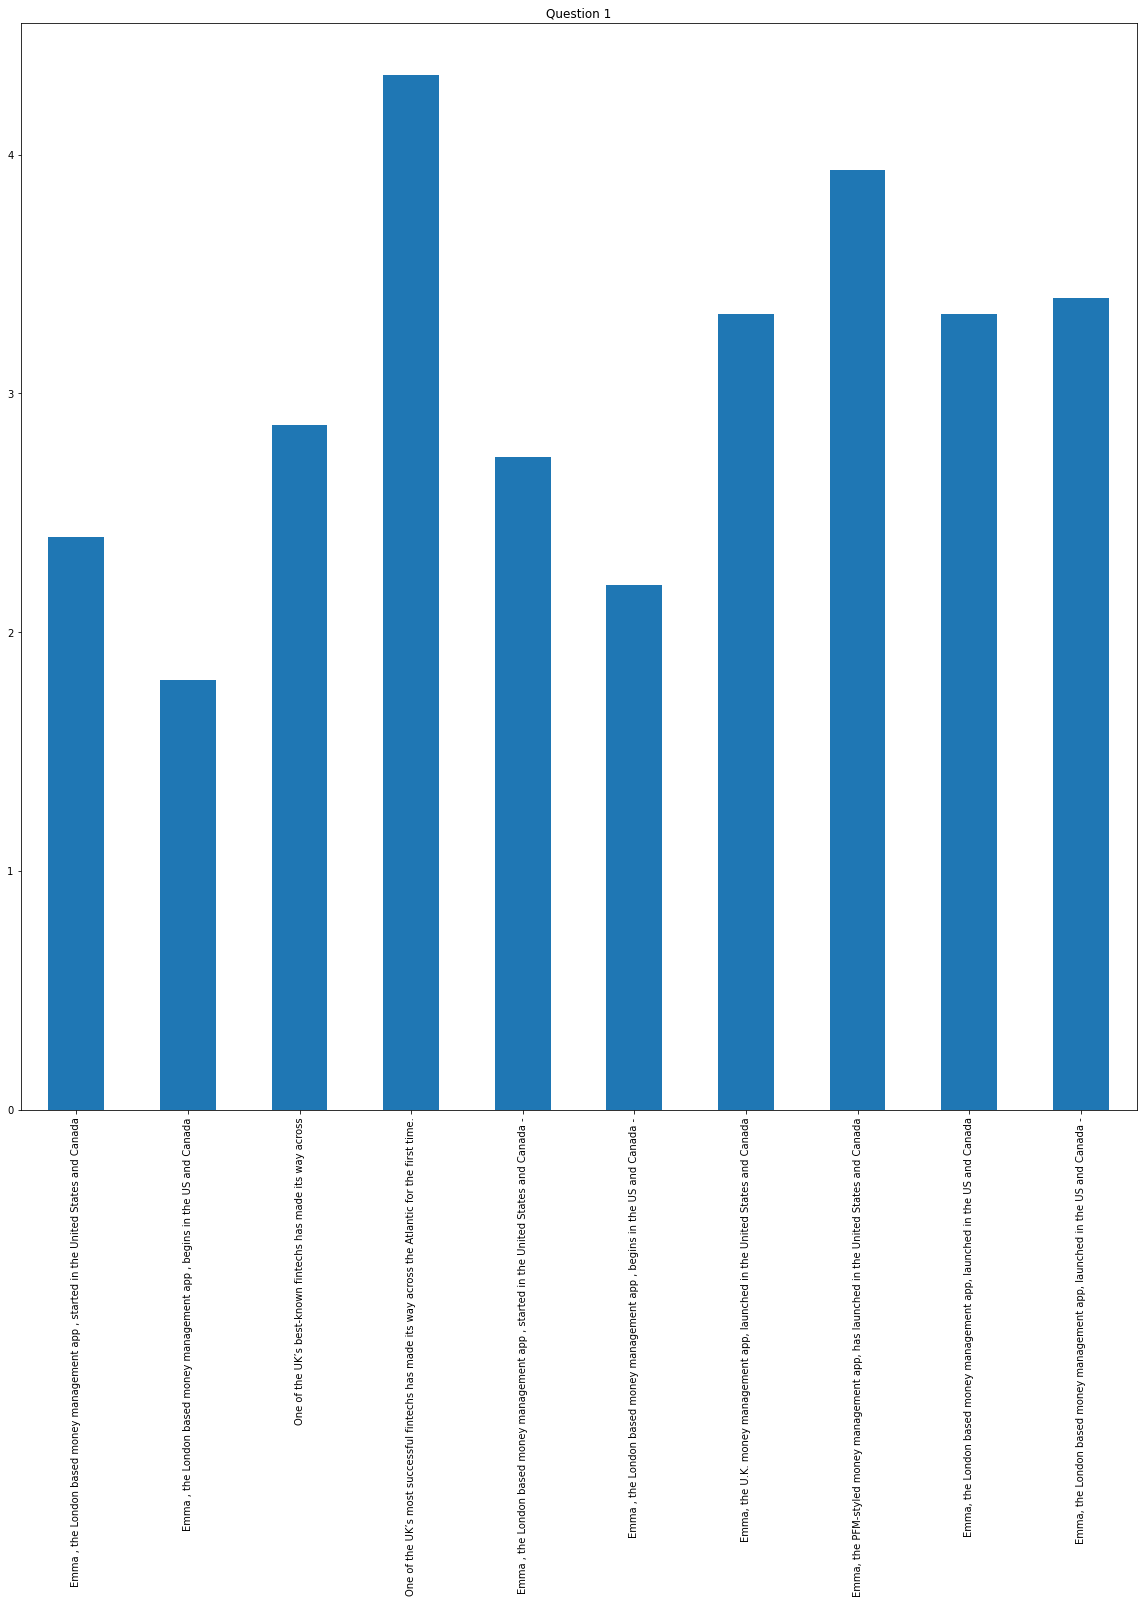

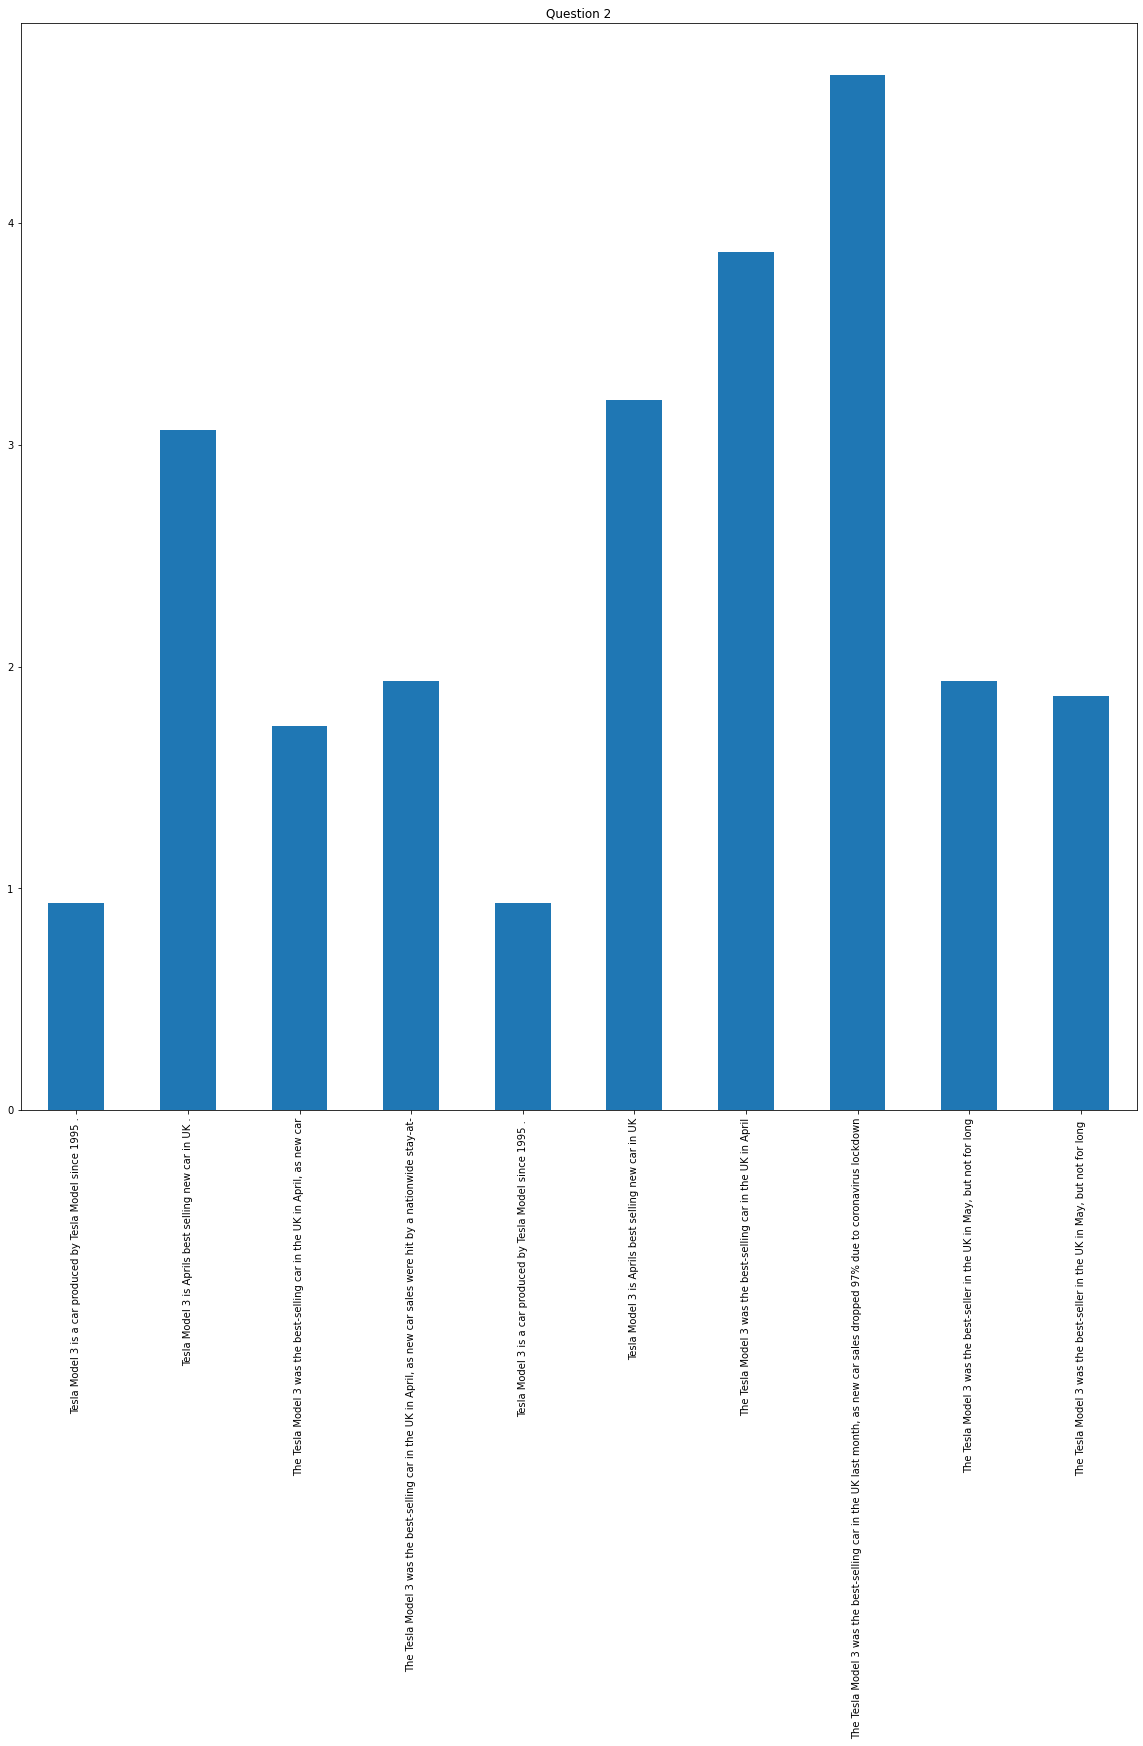

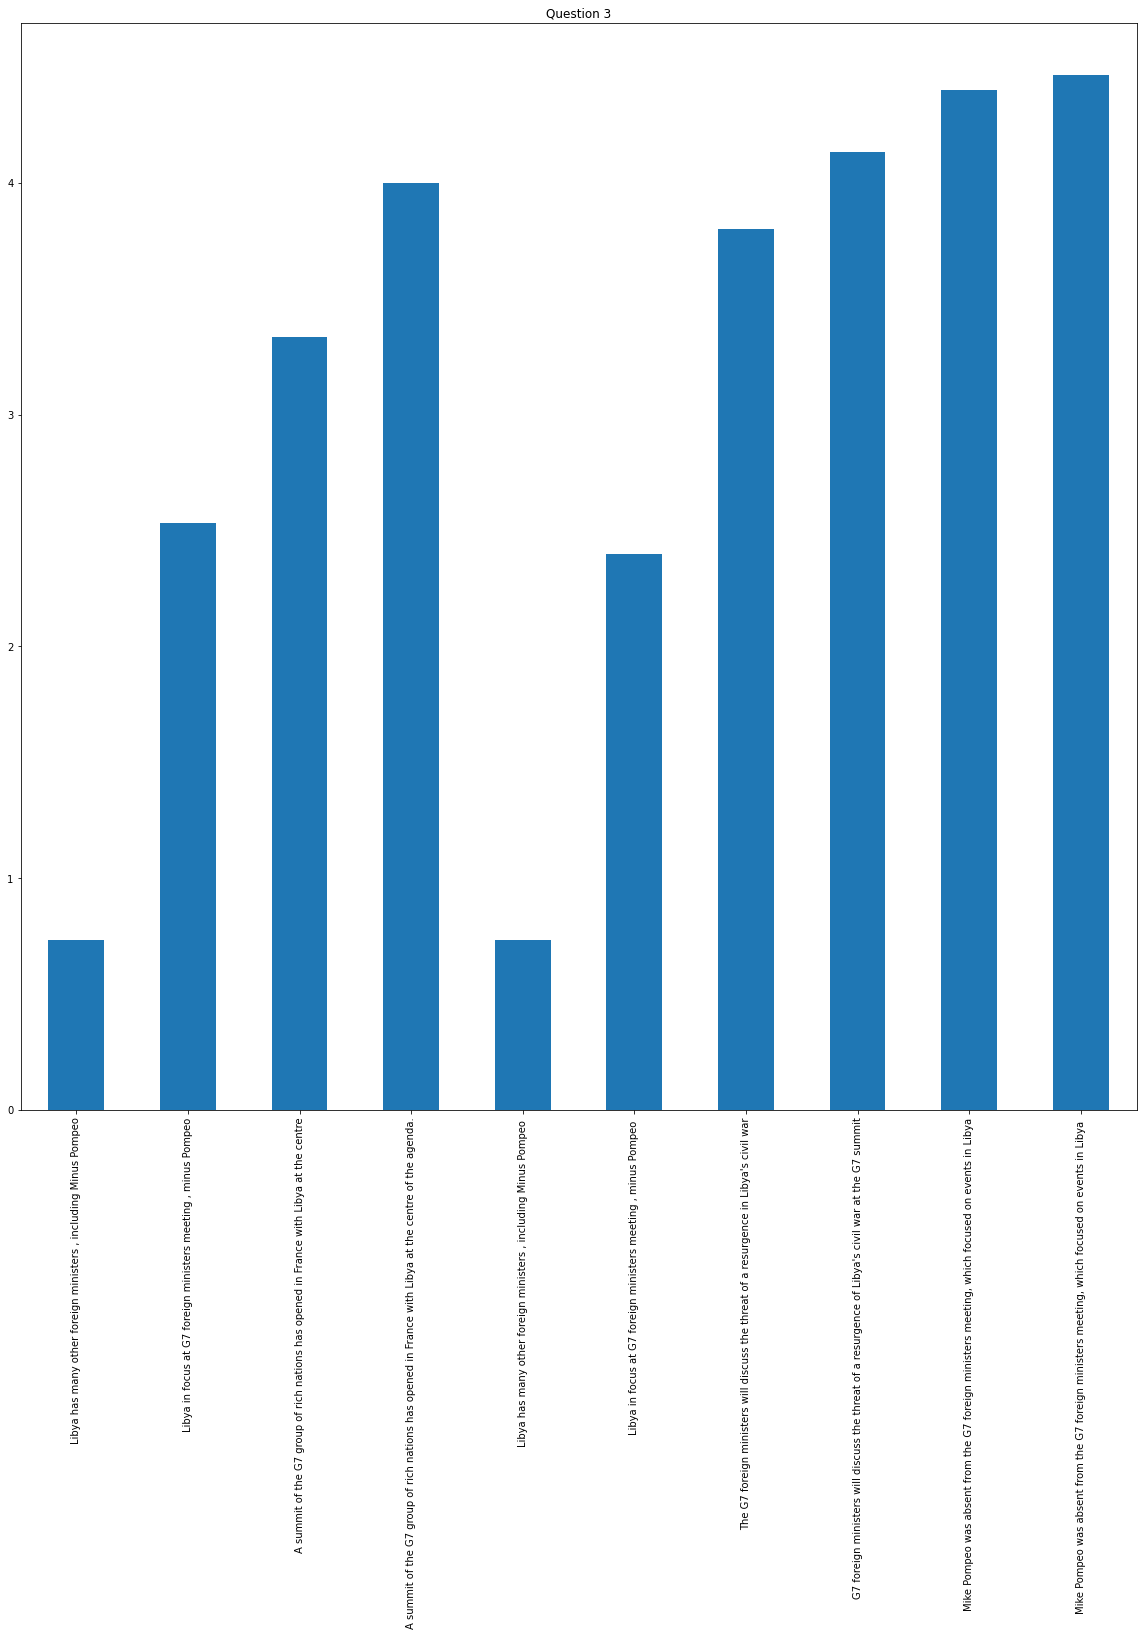

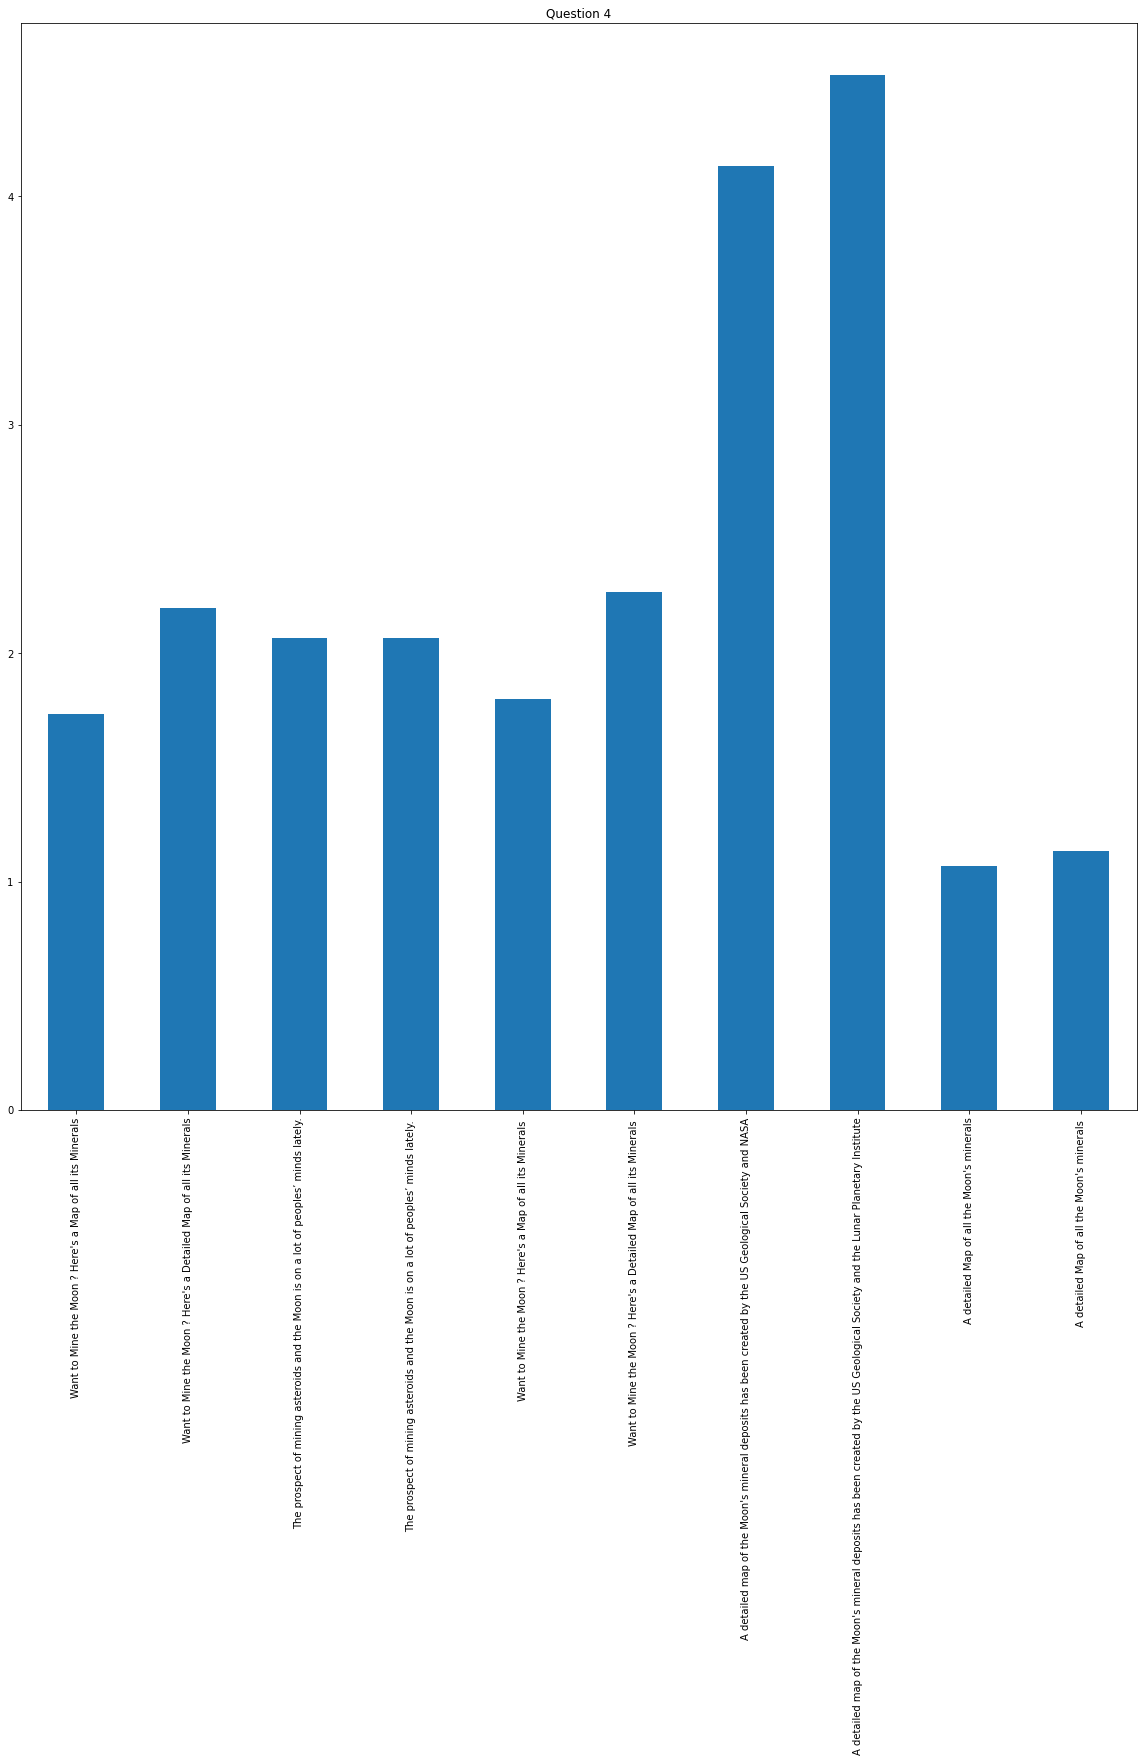

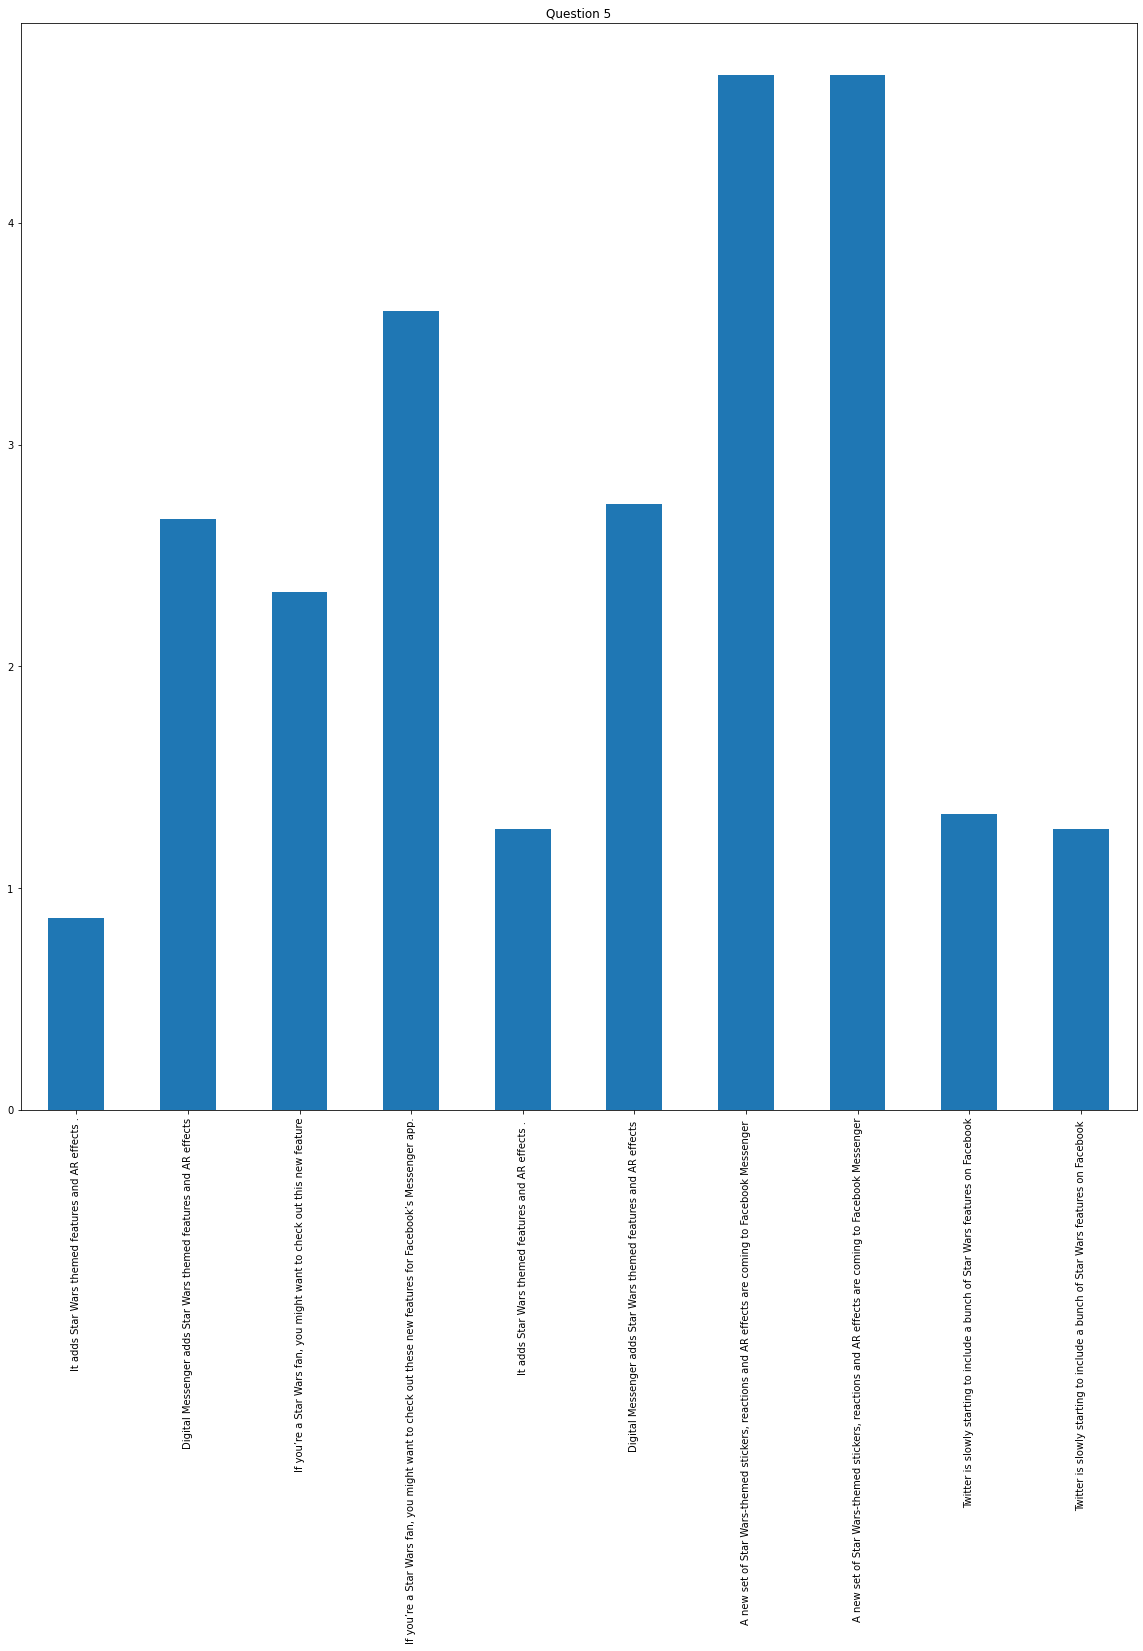

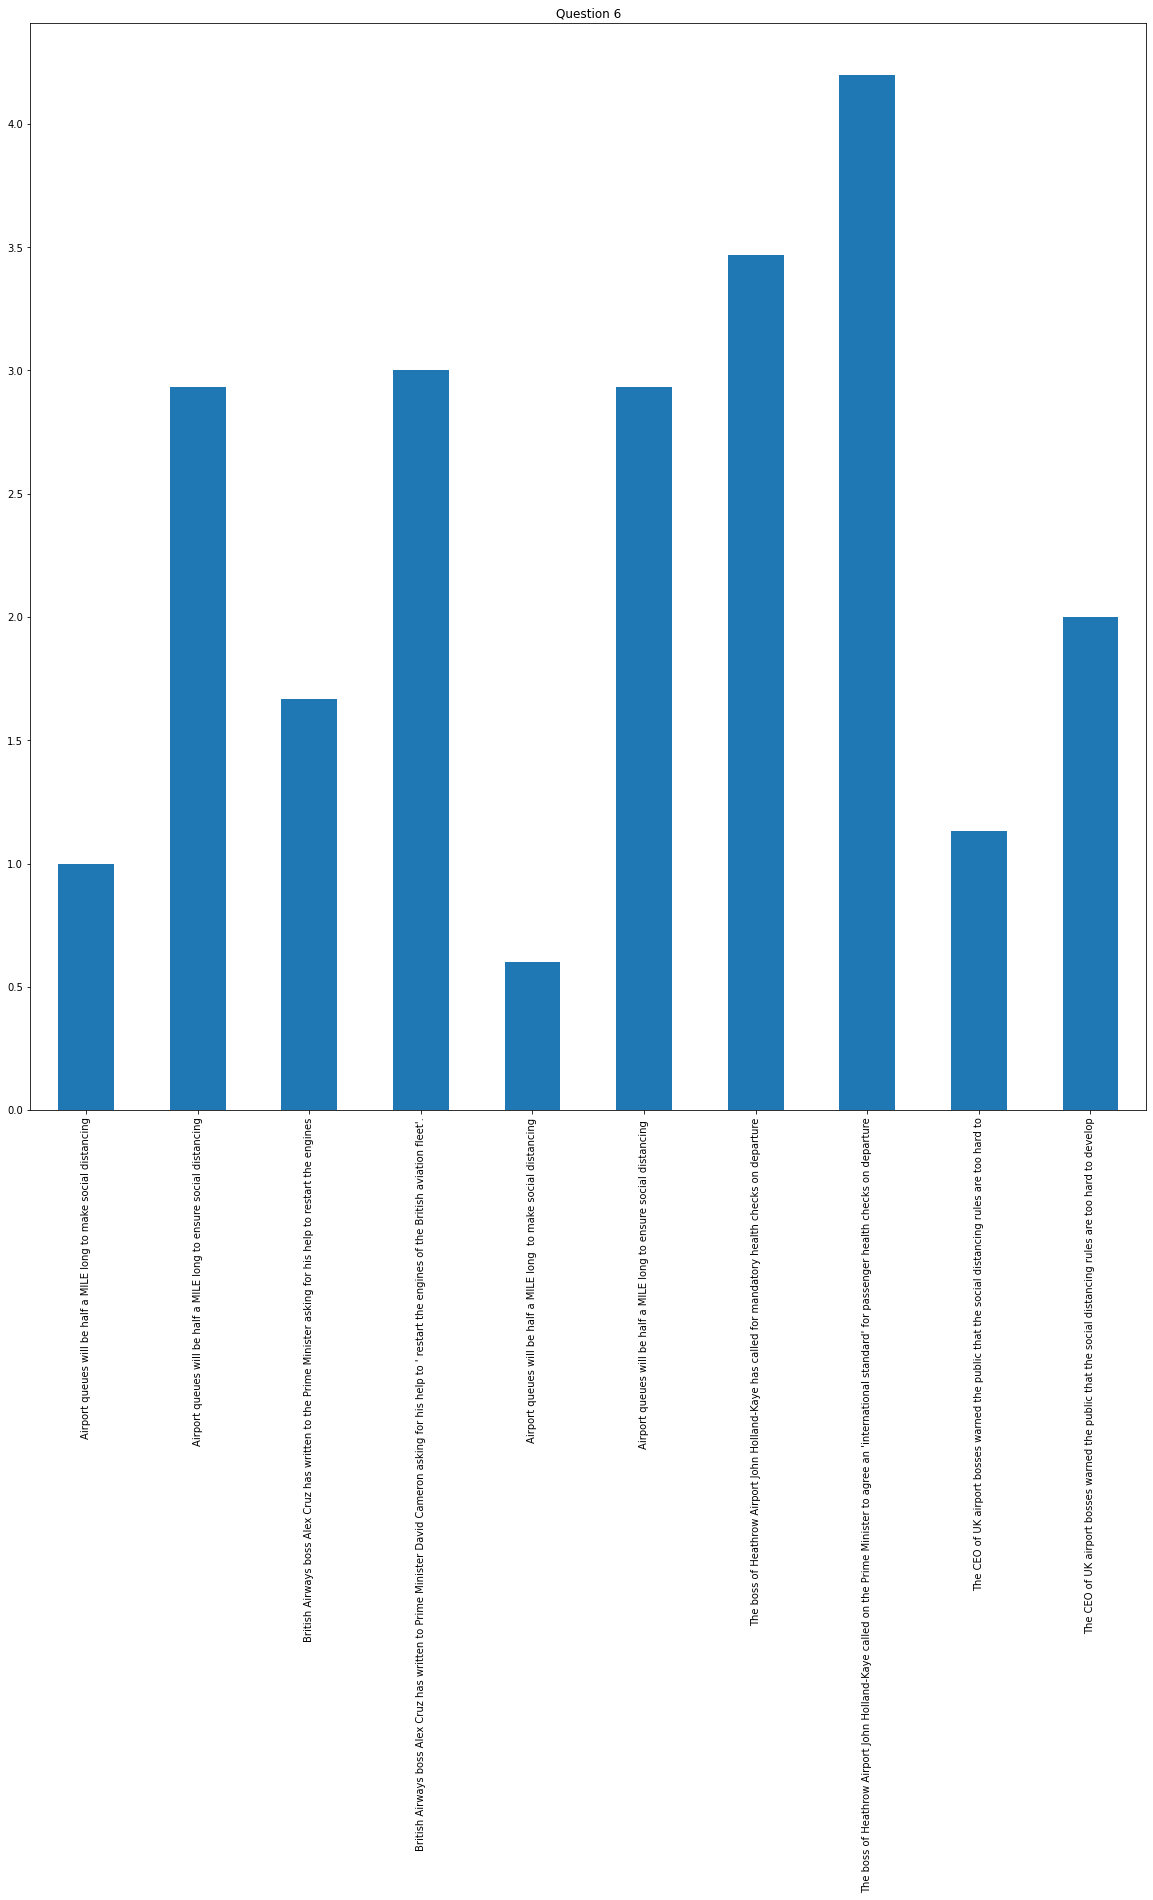

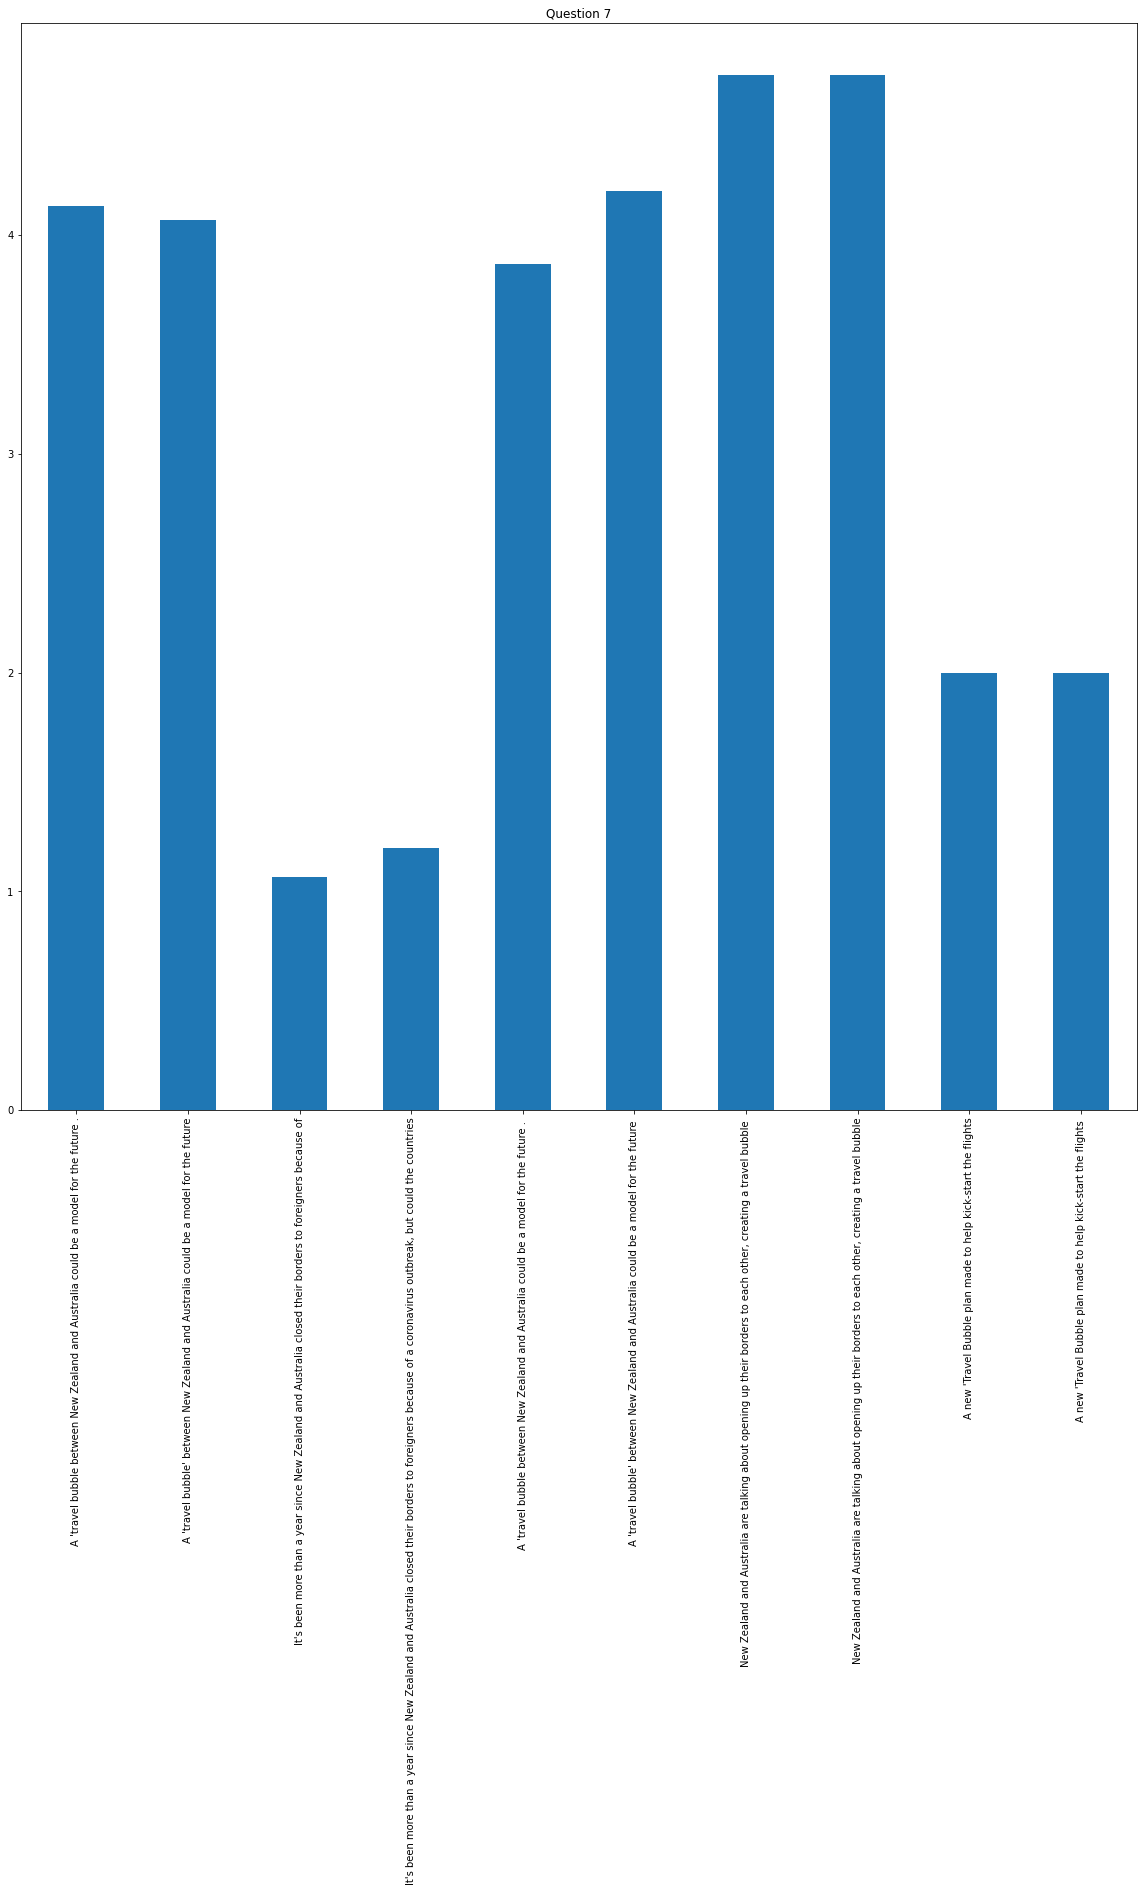

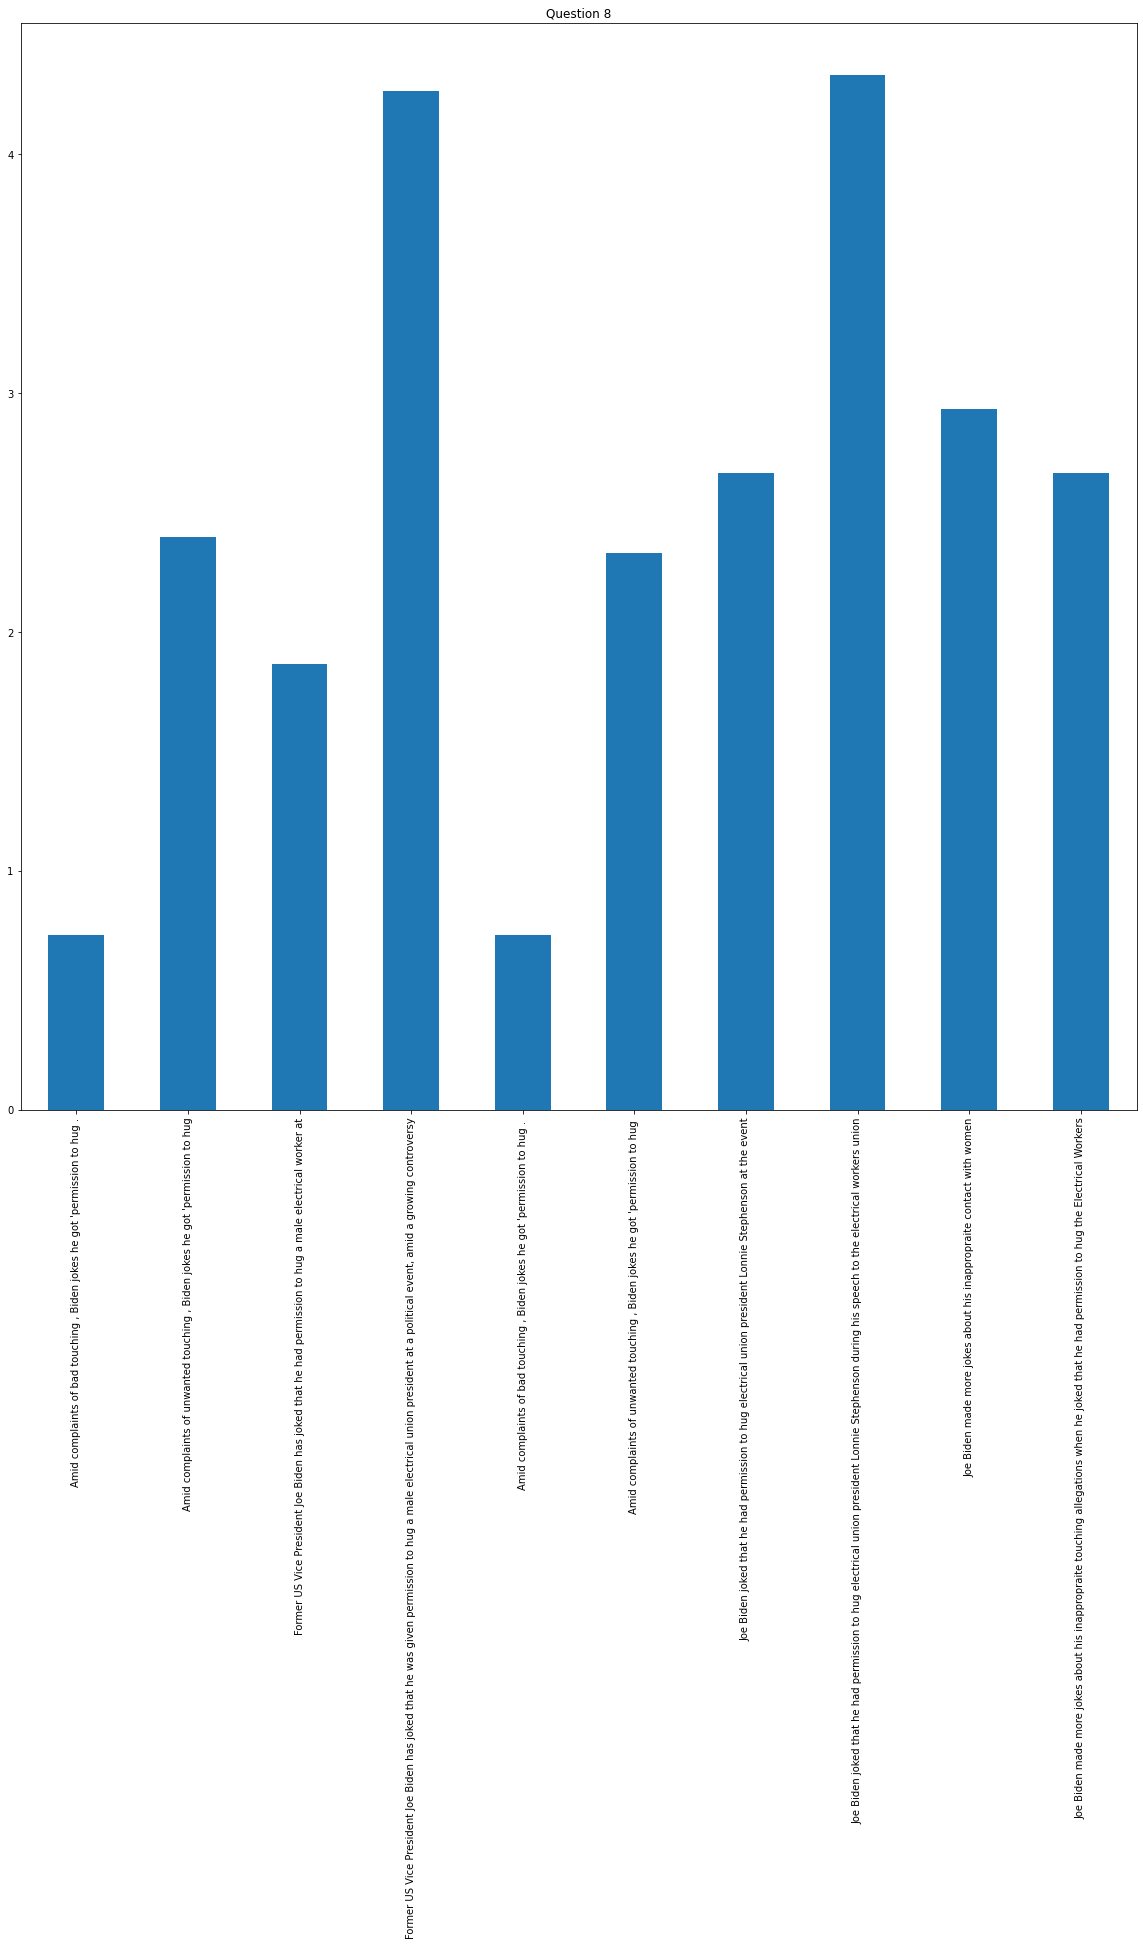

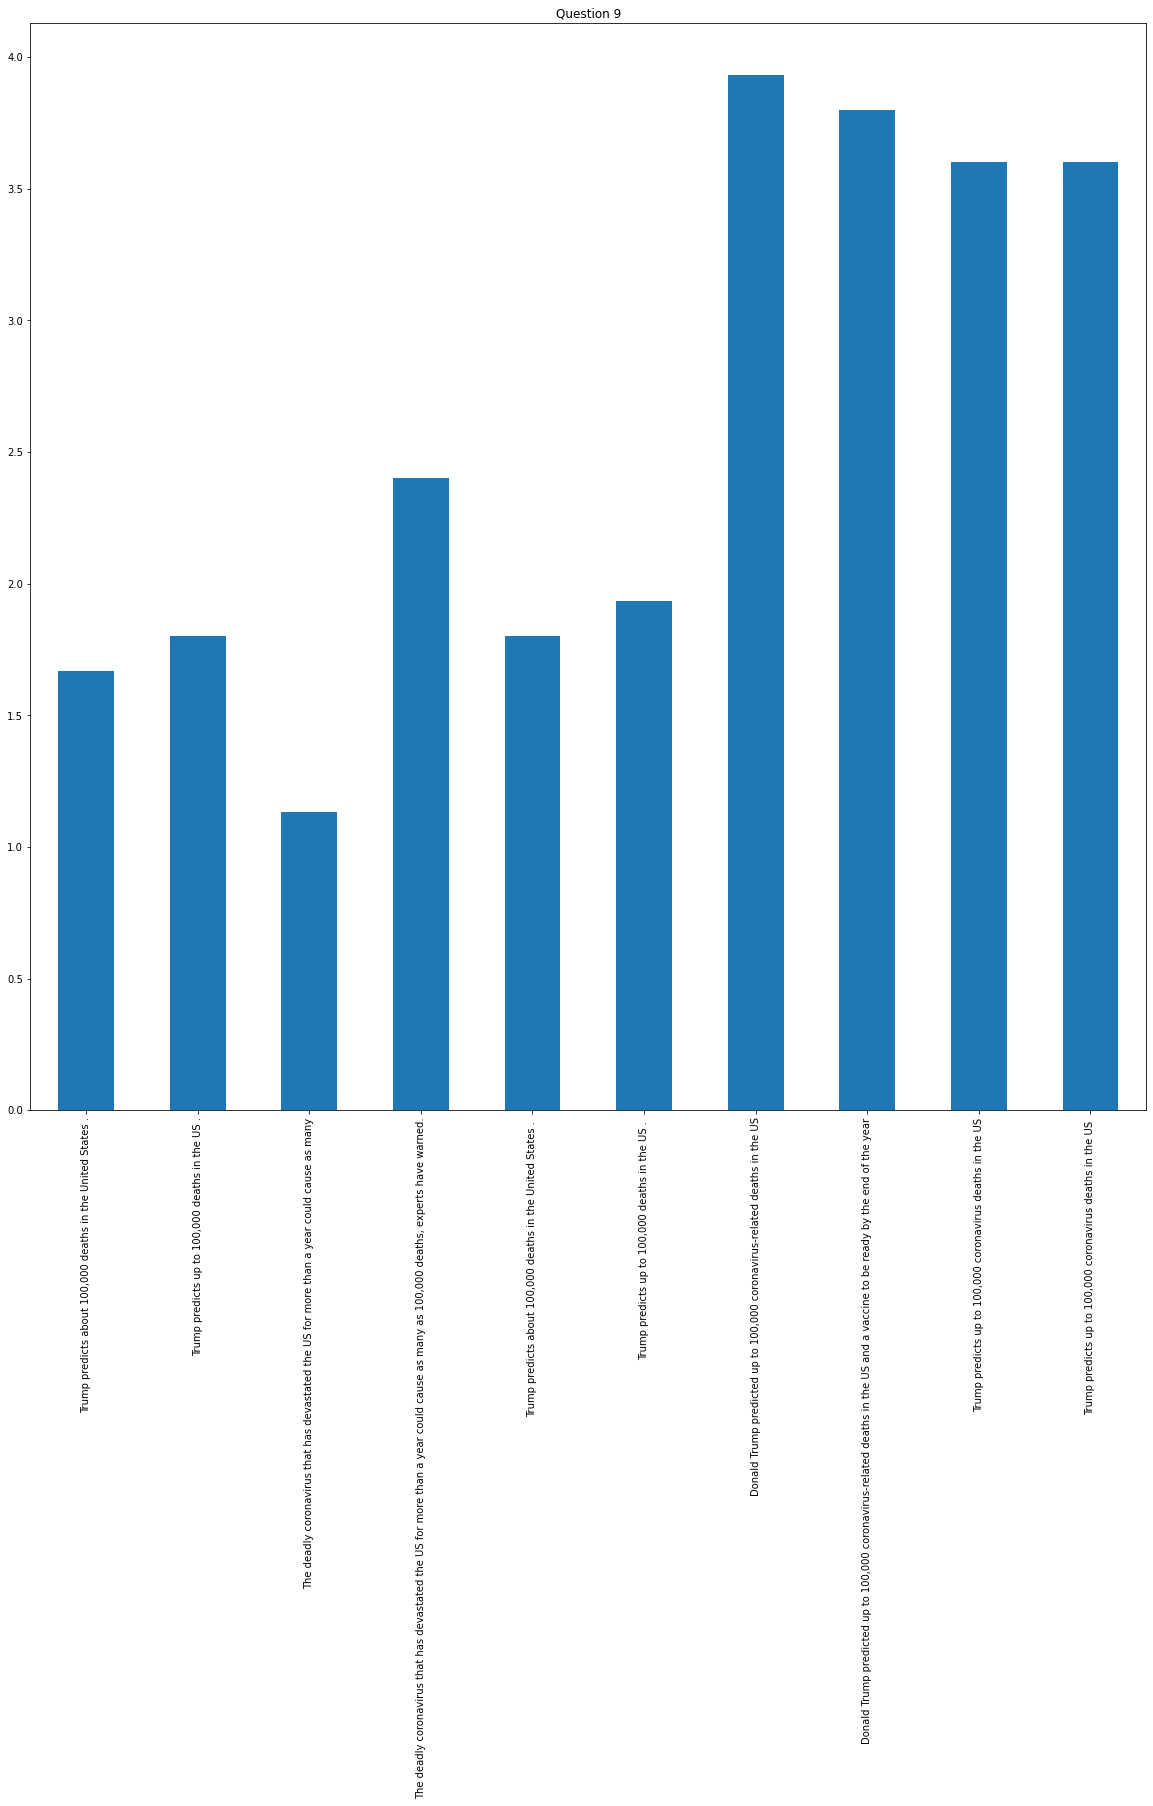

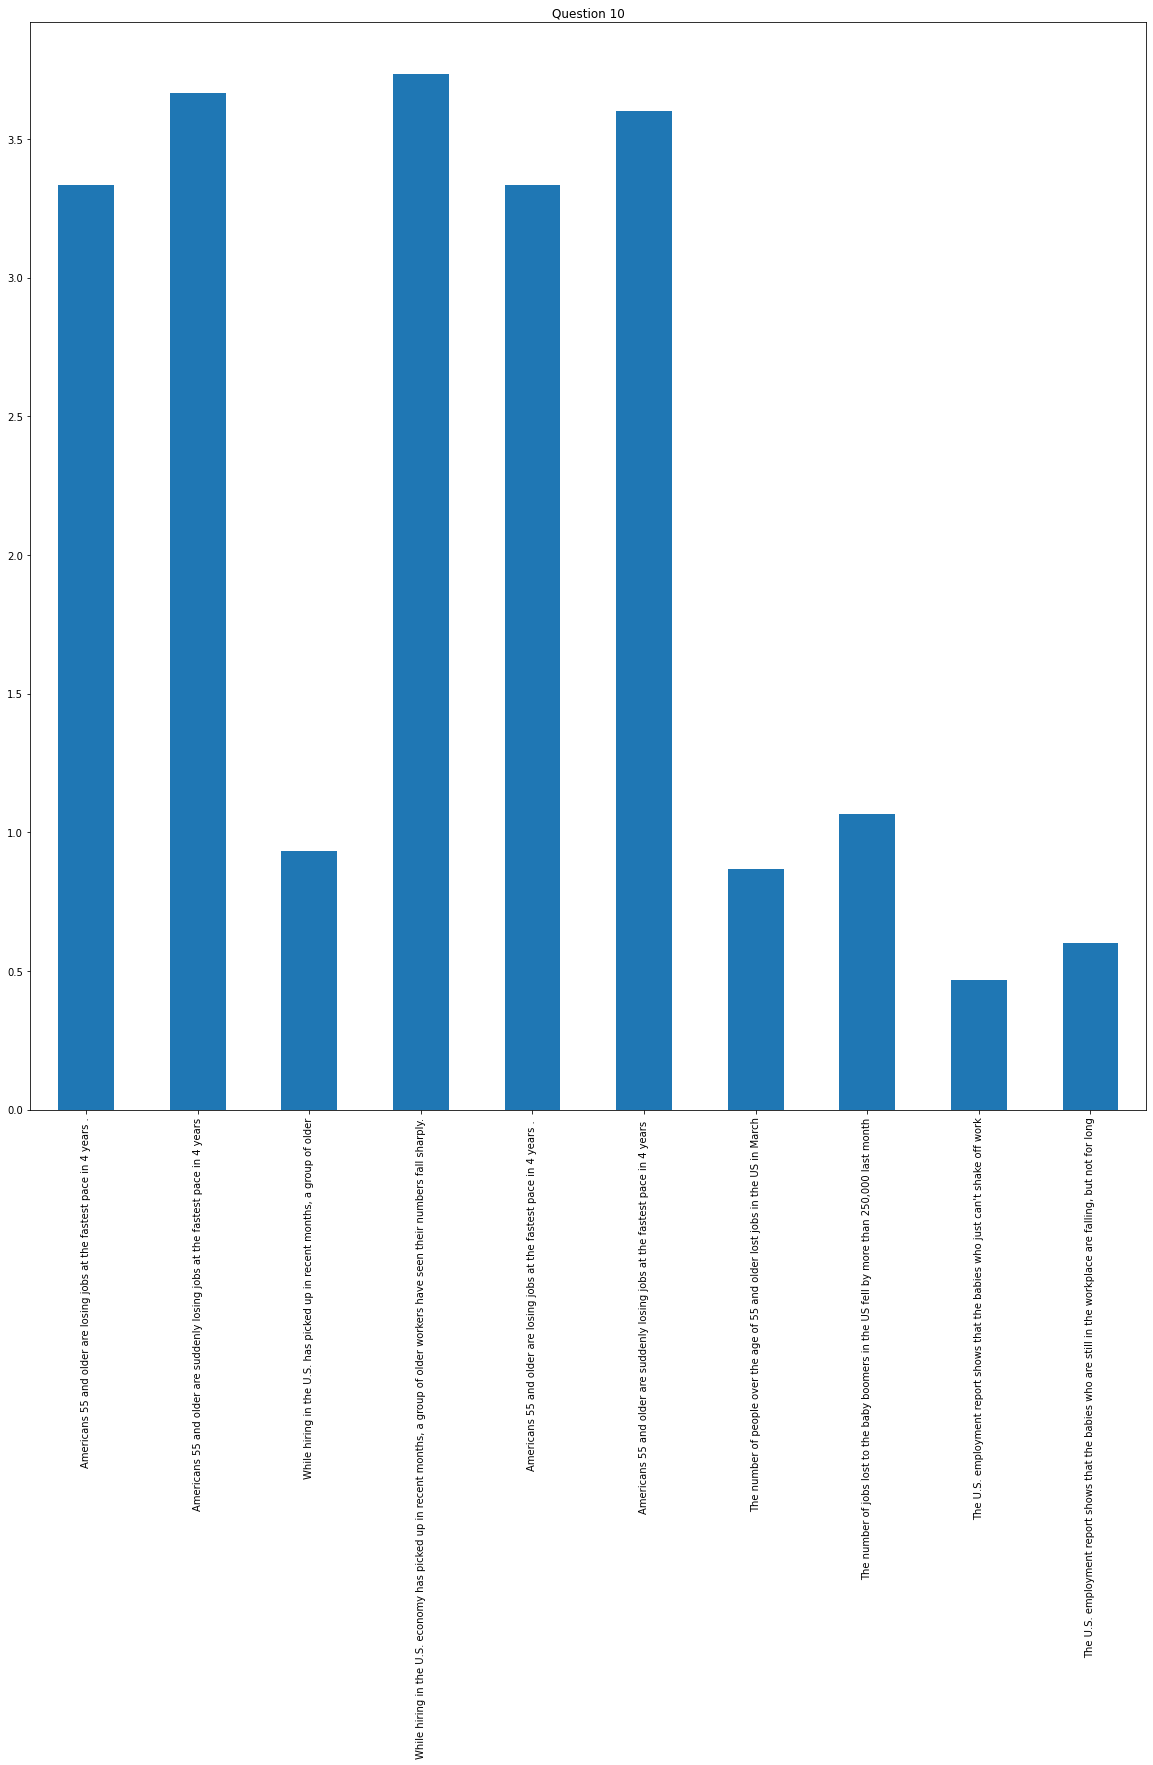

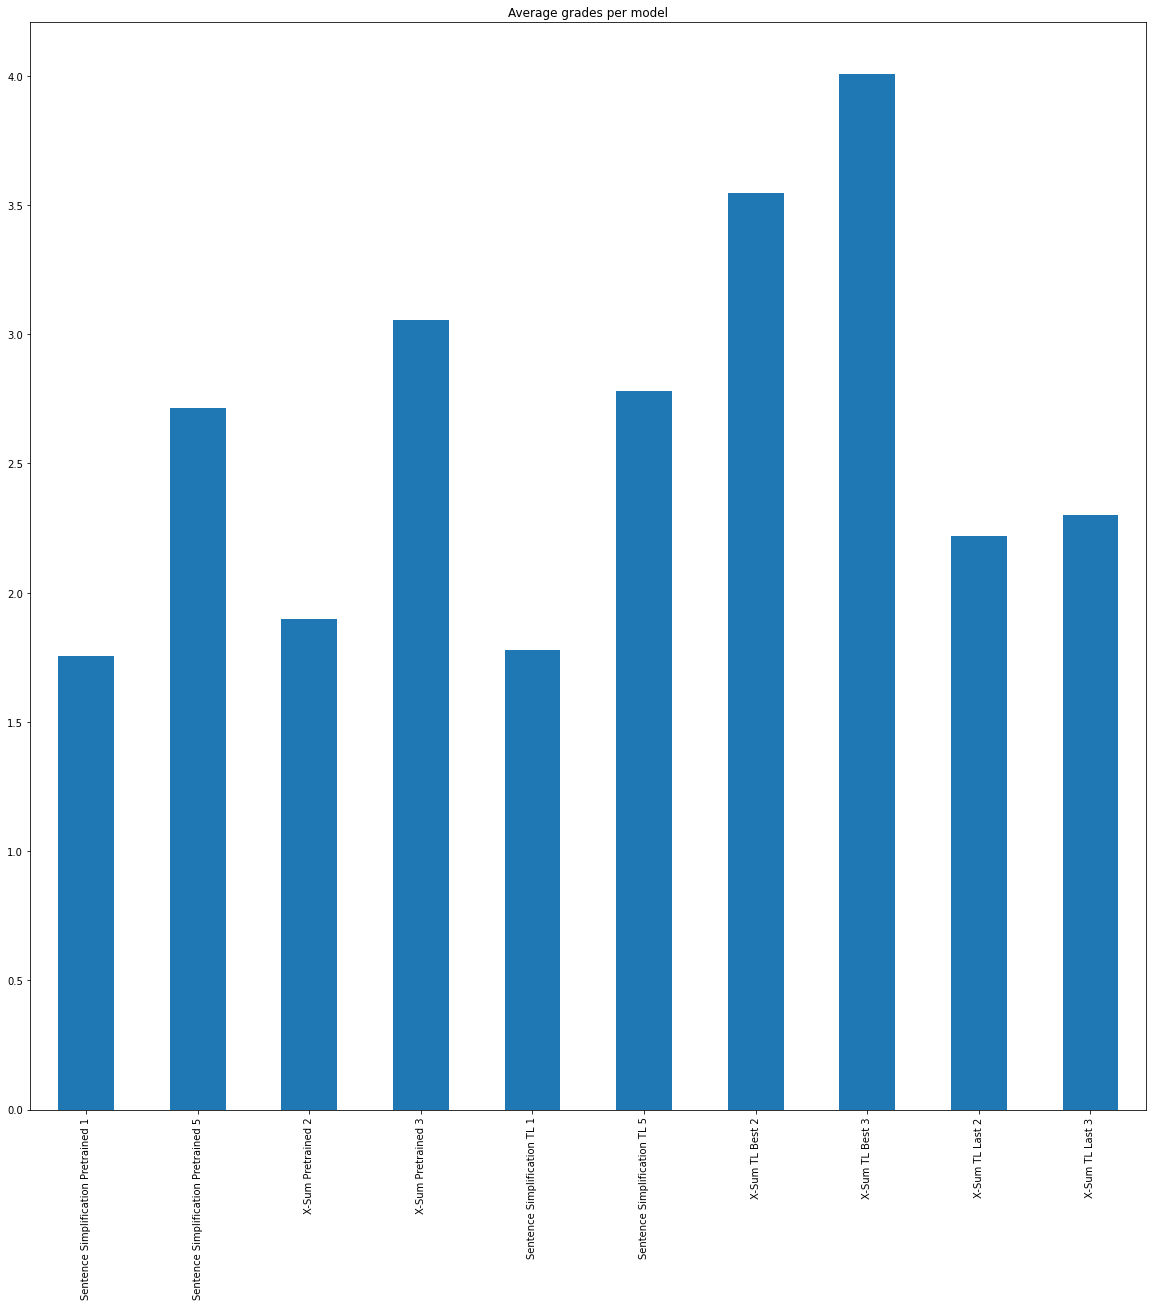

In [29]:
import re
import numpy as np 

spreadsheet = gc.open('Reporting News in a colloquial Manner A (Responses)')
worksheet = spreadsheet.worksheet("Form responses 1")
values = worksheet.get_all_values()

def f(x):
  m = re.search('.*\[(.+?)\].*', x)
  if m:
    return m.group(1)
  else:
    return x

headers = values.pop(0)
headers = list(map(f, headers))

data_ = pd.DataFrame(values, columns=headers).drop(['Timestamp'], axis=1).applymap(int)
data = np.split(data_, np.arange(10, len(data_.columns), 10), axis=1)

axes = []
figs = []
for j in range(len(data)):
  fig, ax =  plt.subplots(figsize=(20, 20))
  figs.append(fig)
  axes.append(ax)

res = []
i = 0
for d in data:
  r = d.mean(axis=0)
  res.append(r.values)
  r.plot(kind='bar', ax=axes[i], title='Question {}'.format(i+1))
  i = i+1

data_f = pd.DataFrame(data = res, columns=['Sentence Simplification Pretrained 1', 'Sentence Simplification Pretrained 5', 'X-Sum Pretrained 2', 'X-Sum Pretrained 3', 'Sentence Simplification TL 1', 'Sentence Simplification TL 5', 'X-Sum TL Best 2', 'X-Sum TL Best 3', 'X-Sum TL Last 2', 'X-Sum TL Last 3'])

fig, axes = plt.subplots(figsize=(20, 20))
data_f.mean(axis=0).plot(kind='bar', ax=axes, title='Average grades per model')

fig.savefig('/content/drive/My Drive/Universita/Tesi/Data/headlines_data/avg_grade_model.svg')
